In [69]:
import json
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# --- Load Files ---

interpretations_path = "../src/interpretations.json"  # Adjust if needed
mapping_csv_path = "../data/alab_synthesis_data/AIFvsDara_LOG_updated.csv"
evaluation_csv_path = "../data/alab_synthesis_data/Dara-AIF_evaluation.csv"

with open(interpretations_path, "r") as f:
    interpretations_data = json.load(f)

mapping_df = pd.read_csv(mapping_csv_path)
evaluation_df = pd.read_csv(evaluation_csv_path)
evaluation_df = evaluation_df[~evaluation_df["Run Name in ALAB"].str.contains("15")]

# Clean evaluation dataframe: keep only completed evaluations
evaluation_df = evaluation_df.dropna(subset=["Interpretation A: Human Evaluation (0-1, 1 is best)", "Interpretation B: Human Evaluation"])

# --- Helper Functions ---

def run_name_to_tri(run_name):
    return run_name.strip().replace("-", "_")

def normalize_chemist_score(score):
    return score * 100  # assuming 0-1 input

def calculate_prior(llm_likelihood, balance_score, llm_weight, balance_weight):
    return (llm_weight * llm_likelihood + balance_weight * balance_score) / (llm_weight + balance_weight)

def calculate_x(normalized_rwp, normalized_score, rwp_weight, peakmatch_weight):
    return (rwp_weight * normalized_rwp + peakmatch_weight * normalized_score) / (rwp_weight + peakmatch_weight)

def calculate_posterior(prior, x):
    return prior * x

# --- Global for best error tracking ---
best_error_so_far = [float('inf')]  # list to allow modification inside objective()

# --- Objective Function ---

def objective(weights):
    llm_weight, balance_weight, rwp_weight, peakmatch_weight = weights
    total_error = 0
    total_samples = 0

    print("\n🔎 Trying Weights:")
    print(f"  LLM Weight        = {llm_weight:.4f}")
    print(f"  Balance Weight    = {balance_weight:.4f}")
    print(f"  RWP Weight        = {rwp_weight:.4f}")
    print(f"  Peak Match Weight = {peakmatch_weight:.4f}")

    for _, eval_row in evaluation_df.iterrows():
        run_name = eval_row["Run Name in ALAB"]
        tri_name = run_name_to_tri(run_name)

        mapping_row = mapping_df[mapping_df["Run Name in ALAB"] == run_name]
        if mapping_row.empty:
            continue
        explanation_a = mapping_row.iloc[0]["Interpr A - explanation"]
        explanation_b = mapping_row.iloc[0]["Interpr B - explanation"]

        interpretations = interpretations_data.get(tri_name, {})
        if not interpretations:
            continue

        interp_dara = interpretations.get("I_1", None)
        if not interp_dara:
            continue

        aif_candidates = {k: v for k, v in interpretations.items() if k.startswith("I_") and k != "I_1"}
        if not aif_candidates:
            continue

        best_aif_key = max(aif_candidates, key=lambda k: aif_candidates[k].get("posterior_probability", 0))
        interp_aif = aif_candidates[best_aif_key]

        if explanation_a == "AIF interpretation":
            interp_a = interp_aif
            interp_b = interp_dara
        elif explanation_a == "Dara interpretation":
            interp_a = interp_dara
            interp_b = interp_aif
        else:
            continue

        prior_a = calculate_prior(interp_a.get("LLM_interpretation_likelihood", 0), interp_a.get("balance_score", 0), llm_weight, balance_weight)
        x_a = calculate_x(interp_a.get("normalized_rwp", 0), interp_a.get("normalized_score", 0), rwp_weight, peakmatch_weight)
        posterior_a = calculate_posterior(prior_a, x_a) * 100

        prior_b = calculate_prior(interp_b.get("LLM_interpretation_likelihood", 0), interp_b.get("balance_score", 0), llm_weight, balance_weight)
        x_b = calculate_x(interp_b.get("normalized_rwp", 0), interp_b.get("normalized_score", 0), rwp_weight, peakmatch_weight)
        posterior_b = calculate_posterior(prior_b, x_b) * 100

        chemist_score_a = normalize_chemist_score(eval_row["Interpretation A: Human Evaluation (0-1, 1 is best)"])
        chemist_score_b = normalize_chemist_score(eval_row["Interpretation B: Human Evaluation"])
        preferred = eval_row["Prefered Interpretation"]

        # Error: squared differences
        total_error += (posterior_a - chemist_score_a) ** 2
        total_error += (posterior_b - chemist_score_b) ** 2
        total_samples += 2

        # Preference penalty
        if preferred == "A" and posterior_a < posterior_b:
            total_error += 50
        elif preferred == "B" and posterior_b < posterior_a:
            total_error += 50
        elif preferred == "neither A nor B":
            if posterior_a > 70 or posterior_b > 70:
                total_error += 50

    avg_error = total_error / total_samples if total_samples > 0 else float("inf")

    print(f"📊 Total Samples Evaluated: {total_samples}")
    print(f"❌ Total Error for this weight set: {total_error:.2f}")
    print(f"📈 Average Error per Sample: {avg_error:.4f}")

    if avg_error < best_error_so_far[0]:
        print("✅ This is the BEST set so far! Updating best_error.")
        best_error_so_far[0] = avg_error
    else:
        print("⚠️ Not better than previous best.")

    return avg_error

# --- Optimization ---

# Initial weights (equal)
initial_weights = [1.0, 1.0, 1.0, 1.0]

# Bounds
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]  # each weight between 0 and 1

# Run minimize
# result = minimize(objective, initial_weights, method='L-BFGS-B', bounds=bounds)
result = minimize(objective, initial_weights, method='Nelder-Mead', bounds=bounds)

# --- Save Optimized Weights ---

print("\n🏁 Optimized Weights:")
print(f"LLM Weight: {result.x[0]:.4f}")
print(f"Balance Weight: {result.x[1]:.4f}")
print(f"RWP Weight: {result.x[2]:.4f}")
print(f"Peak Match Weight: {result.x[3]:.4f}")

with open("optimized_weights.txt", "w") as f:
    f.write(f"LLM Weight: {result.x[0]:.4f}\n")
    f.write(f"Balance Weight: {result.x[1]:.4f}\n")
    f.write(f"RWP Weight: {result.x[2]:.4f}\n")
    f.write(f"Peak Match Weight: {result.x[3]:.4f}\n")

print("\n✅ Optimization completed and weights saved.")


🔎 Trying Weights:
  LLM Weight        = 1.0000
  Balance Weight    = 1.0000
  RWP Weight        = 1.0000
  Peak Match Weight = 1.0000
📊 Total Samples Evaluated: 16
❌ Total Error for this weight set: 38598.98
📈 Average Error per Sample: 2412.4360
✅ This is the BEST set so far! Updating best_error.

🔎 Trying Weights:
  LLM Weight        = 0.9500
  Balance Weight    = 1.0000
  RWP Weight        = 1.0000
  Peak Match Weight = 1.0000
📊 Total Samples Evaluated: 16
❌ Total Error for this weight set: 38092.03
📈 Average Error per Sample: 2380.7520
✅ This is the BEST set so far! Updating best_error.

🔎 Trying Weights:
  LLM Weight        = 1.0000
  Balance Weight    = 0.9500
  RWP Weight        = 1.0000
  Peak Match Weight = 1.0000
📊 Total Samples Evaluated: 16
❌ Total Error for this weight set: 39111.19
📈 Average Error per Sample: 2444.4495
⚠️ Not better than previous best.

🔎 Trying Weights:
  LLM Weight        = 1.0000
  Balance Weight    = 1.0000
  RWP Weight        = 0.9500
  Peak Match We

In [94]:
import json
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# --- Load Files ---
interpretations_path = "../src/interpretations.json"
mapping_csv_path = "../data/alab_synthesis_data/AIFvsDara_LOG_updated.csv"
evaluation_csv_path = "../data/alab_synthesis_data/Dara-AIF_evaluation.csv"

with open(interpretations_path, "r") as f:
    interpretations_data = json.load(f)

mapping_df = pd.read_csv(mapping_csv_path)
evaluation_df = pd.read_csv(evaluation_csv_path)
evaluation_df = evaluation_df[~evaluation_df["Run Name in ALAB"].str.contains("15")]
evaluation_df = evaluation_df.dropna(subset=["Interpretation A: Human Evaluation (0-1, 1 is best)", "Interpretation B: Human Evaluation"])

# --- Helper Functions ---

def run_name_to_tri(run_name):
    return run_name.strip().replace("-", "_")

def normalize_chemist_score(score):
    return score * 100

def llm_to_evaluation_score(llm_value):
    if llm_value is None:
        return 0.0
    if llm_value < 0.45:
        return 0.0
    elif 0.45 <= llm_value < 0.55:
        return 0.5
    else:
        return 1.0

def calculate_prior(llm_eval_score, balance_score, llm_weight, balance_weight):
    total_weight = llm_weight + balance_weight
    if total_weight == 0:
        return 0.0
    return (llm_weight * llm_eval_score + balance_weight * balance_score) / total_weight

def calculate_x(normalized_rwp, normalized_score, rwp_weight, peakmatch_weight):
    total_weight = rwp_weight + peakmatch_weight
    if total_weight == 0:
        return 0.0
    return (rwp_weight * normalized_rwp + peakmatch_weight * normalized_score) / total_weight

def calculate_posterior(prior, x):
    return prior * x

# --- Global tracker ---
best_error_so_far = [float('inf')]

# --- Objective Function ---

def objective(weights):
    llm_weight, balance_weight, rwp_weight, peakmatch_weight = weights
    total_error = 0
    total_samples = 0

    # print("\n🔎 Trying Weights:")
    # print(f"  LLM Weight        = {llm_weight:.4f}")
    # print(f"  Balance Weight    = {balance_weight:.4f}")
    # print(f"  RWP Weight        = {rwp_weight:.4f}")
    # print(f"  Peak Match Weight = {peakmatch_weight:.4f}")

    for _, eval_row in evaluation_df.iterrows():
        run_name = eval_row["Run Name in ALAB"]
        tri_name = run_name_to_tri(run_name)

        mapping_row = mapping_df[mapping_df["Run Name in ALAB"] == run_name]
        if mapping_row.empty:
            continue

        explanation_a = mapping_row.iloc[0]["Interpr A - explanation"]
        interpretations = interpretations_data.get(tri_name, {})
        if not interpretations or "I_1" not in interpretations:
            continue

        interp_dara = interpretations["I_1"]
        aif_candidates = {k: v for k, v in interpretations.items() if k.startswith("I_") and k != "I_1"}
        if not aif_candidates:
            continue

        best_aif_key = max(aif_candidates, key=lambda k: aif_candidates[k].get("posterior_probability", 0))
        interp_aif = aif_candidates[best_aif_key]

        if explanation_a == "AIF interpretation":
            interp_a, interp_b = interp_aif, interp_dara
        elif explanation_a == "Dara interpretation":
            interp_a, interp_b = interp_dara, interp_aif
        else:
            continue

        llm_eval_a = llm_to_evaluation_score(interp_a.get("LLM_interpretation_likelihood", 0))
        prior_a = calculate_prior(llm_eval_a, interp_a.get("balance_score", 0), llm_weight, balance_weight)
        x_a = calculate_x(interp_a.get("normalized_rwp", 0), interp_a.get("normalized_score", 0), rwp_weight, peakmatch_weight)
        posterior_a = calculate_posterior(prior_a, x_a) * 100

        llm_eval_b = llm_to_evaluation_score(interp_b.get("LLM_interpretation_likelihood", 0))
        prior_b = calculate_prior(llm_eval_b, interp_b.get("balance_score", 0), llm_weight, balance_weight)
        x_b = calculate_x(interp_b.get("normalized_rwp", 0), interp_b.get("normalized_score", 0), rwp_weight, peakmatch_weight)
        posterior_b = calculate_posterior(prior_b, x_b) * 100

        chemist_score_a = normalize_chemist_score(eval_row["Interpretation A: Human Evaluation (0-1, 1 is best)"])
        chemist_score_b = normalize_chemist_score(eval_row["Interpretation B: Human Evaluation"])
        preferred = eval_row["Prefered Interpretation"]

        total_error += (posterior_a - chemist_score_a) ** 2
        total_error += (posterior_b - chemist_score_b) ** 2
        total_samples += 2

        if preferred == "A" and posterior_a < posterior_b:
            total_error += 50
        elif preferred == "B" and posterior_b < posterior_a:
            total_error += 50
        elif preferred == "neither A nor B":
            if posterior_a > 70 or posterior_b > 70:
                total_error += 50

    avg_error = total_error / total_samples if total_samples > 0 else float("inf")

    # print(f"📊 Total Samples Evaluated: {total_samples}")
    # print(f"❌ Total Error for this weight set: {total_error:.2f}")
    # print(f"📈 Average Error per Sample: {avg_error:.4f}")

    if avg_error < best_error_so_far[0]:
        # print("✅ This is the BEST set so far! Updating best_error.")
        best_error_so_far[0] = avg_error
    # else:
        # print("⚠️ Not better than previous best.")

    return avg_error

# --- Optimization ---

initial_weights = [1.0, 1.0, 1.0, 1.0]
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
result = minimize(objective, initial_weights, method='Nelder-Mead', bounds=bounds)

# --- Save Results ---

print("\n🏁 Optimized Weights:")
print(f"LLM Weight: {result.x[0]:.4f}")
print(f"Balance Weight: {result.x[1]:.4f}")
print(f"RWP Weight: {result.x[2]:.4f}")
print(f"Peak Match Weight: {result.x[3]:.4f}")

with open("optimized_weights.txt", "w") as f:
    f.write(f"LLM Weight: {result.x[0]:.4f}\n")
    f.write(f"Balance Weight: {result.x[1]:.4f}\n")
    f.write(f"RWP Weight: {result.x[2]:.4f}\n")
    f.write(f"Peak Match Weight: {result.x[3]:.4f}\n")

print("\n✅ Optimization completed and weights saved.")


🏁 Optimized Weights:
LLM Weight: 0.0000
Balance Weight: 1.0000
RWP Weight: 0.5983
Peak Match Weight: 0.0000

✅ Optimization completed and weights saved.


/var/folders/h9/xq939v1d36x6_ggshzfwxr840000gn/T/ipykernel_22893/1016669440.py:85: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


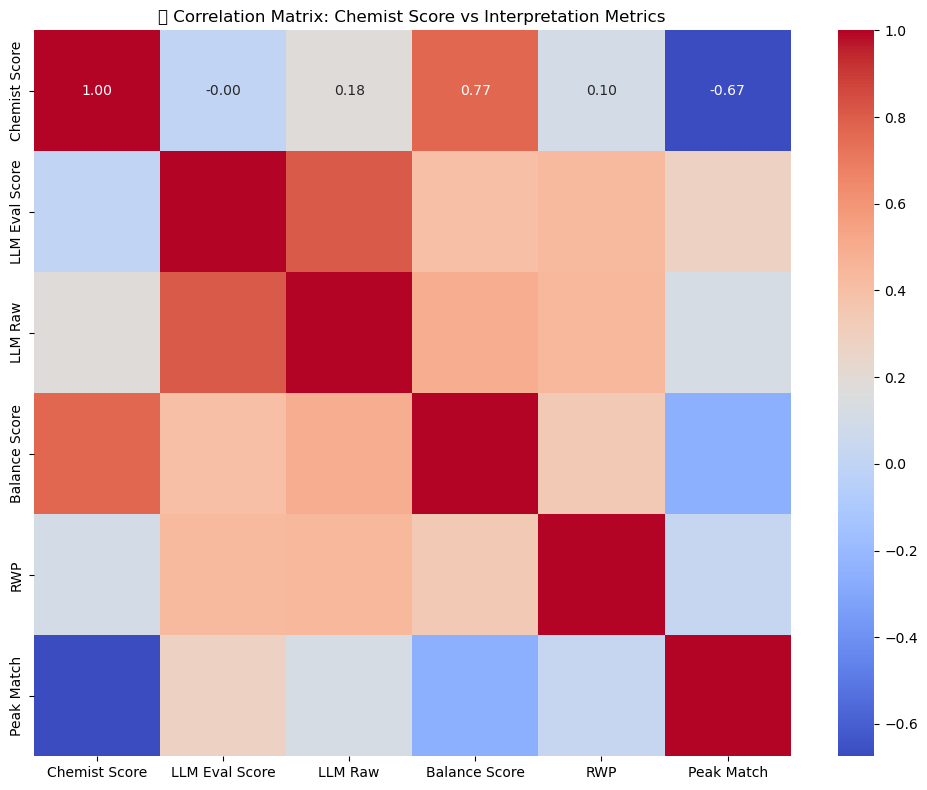

In [100]:
import json
import pandas as pd
import seaborn as sns

# Load your interpretation and evaluation data
with open("../src/interpretations.json", "r") as f:
    interpretations_data = json.load(f)

mapping_df = pd.read_csv("../data/alab_synthesis_data/AIFvsDara_LOG_updated.csv")
evaluation_df = pd.read_csv("../data/alab_synthesis_data/Dara-AIF_evaluation.csv")
evaluation_df = evaluation_df[~evaluation_df["Run Name in ALAB"].str.contains("15")]
evaluation_df = evaluation_df.dropna(subset=["Interpretation A: Human Evaluation (0-1, 1 is best)", "Interpretation B: Human Evaluation"])

def run_name_to_tri(run_name):
    return run_name.strip().replace("-", "_")

def normalize_chemist_score(score):
    return score * 100

def llm_to_evaluation_score(llm_value):
    if llm_value is None:
        return 0.0
    if llm_value <= 0.2:
        return 0.0
    elif 0.3 <= llm_value < 0.5:
        return 0.5
    else:
        return 1.0

# Collect rows for correlation analysis
data_rows = []

for _, eval_row in evaluation_df.iterrows():
    run_name = eval_row["Run Name in ALAB"]
    tri_name = run_name_to_tri(run_name)

    mapping_row = mapping_df[mapping_df["Run Name in ALAB"] == run_name]
    if mapping_row.empty:
        continue

    explanation_a = mapping_row.iloc[0]["Interpr A - explanation"]
    interpretations = interpretations_data.get(tri_name, {})
    if not interpretations or "I_1" not in interpretations:
        continue

    interp_dara = interpretations["I_1"]
    aif_candidates = {k: v for k, v in interpretations.items() if k.startswith("I_") and k != "I_1"}
    if not aif_candidates:
        continue

    best_aif_key = max(aif_candidates, key=lambda k: aif_candidates[k].get("posterior_probability", 0))
    interp_aif = aif_candidates[best_aif_key]

    if explanation_a == "AIF interpretation":
        interp_a, interp_b = interp_aif, interp_dara
    elif explanation_a == "Dara interpretation":
        interp_a, interp_b = interp_dara, interp_aif
    else:
        continue

    def extract_row(source, chemist_score, label):
        return {
            "Label": label,
            "Chemist Score": chemist_score,
            "LLM Eval Score": llm_to_evaluation_score(source.get("LLM_interpretation_likelihood", 0)),
            "LLM Raw": source.get("LLM_interpretation_likelihood", 0),
            "Balance Score": source.get("balance_score", 0),
            "RWP": source.get("normalized_rwp", 0),
            "Peak Match": source.get("normalized_score", 0)
        }

    chemist_score_a = normalize_chemist_score(eval_row["Interpretation A: Human Evaluation (0-1, 1 is best)"])
    chemist_score_b = normalize_chemist_score(eval_row["Interpretation B: Human Evaluation"])

    data_rows.append(extract_row(interp_a, chemist_score_a, "Interpretation A"))
    data_rows.append(extract_row(interp_b, chemist_score_b, "Interpretation B"))

# Convert to DataFrame
correlation_df = pd.DataFrame(data_rows)

# Compute and plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df.drop(columns=["Label"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔗 Correlation Matrix: Chemist Score vs Interpretation Metrics")
plt.tight_layout()
plt.show()

In [99]:
correlation_df

Label  Chemist Score  LLM Eval Score  LLM Raw  Balance Score  \
0   Interpretation A            0.0             1.0     0.50       0.921600   
1   Interpretation B          100.0             1.0     0.60       1.000000   
2   Interpretation A          100.0             1.0     0.85       0.995100   
3   Interpretation B          100.0             1.0     0.85       0.993600   
4   Interpretation A          100.0             1.0     0.70       0.995556   
5   Interpretation B          100.0             1.0     0.70       0.996789   
6   Interpretation A          100.0             0.5     0.30       0.937500   
7   Interpretation B          100.0             0.0     0.20       0.980400   
8   Interpretation A           50.0             0.5     0.40       0.897600   
9   Interpretation B           50.0             0.5     0.30       0.891100   
10  Interpretation A          100.0             1.0     0.50       0.993600   
11  Interpretation B          100.0             1.0     0.50       0.997500   
12  Interpretation A          100.0             0.5     0.40       0.960000   
13  Interpretation B          100.0             0.5     0.30       0.990000   
14  Interpretation A          100.0             1.0     0.50       0.980400   
15  Interpretation B          100.0             0.5     0.40       0.977500   

        RWP  Peak Match  
0   0.83650    0.650867  
1   0.85850    0.416152  
2   0.85875    0.508233  
3   0.85625    0.460805  
4   0.84550    0.459637  
5   0.85350    0.482862  
6   0.82725    0.468052  
7   0.86325    0.450838  
8   0.74775    0.479075  
9   0.74225    0.434540  
10  0.82900    0.505409  
11  0.87975    0.439636  
12  0.62500    0.471093  
13  0.61875    0.475528  
14  0.84950    0.484432  
15  0.84925    0.453594

In [101]:
def match_rate(df):
    match = (df["LLM Eval Score"] * 100).round() == df["Chemist Score"].round()
    return match.sum() / len(df)

accuracy = match_rate(correlation_df)
print(f"✅ LLM-Chemist Agreement Accuracy: {accuracy*100:.1f}%")

✅ LLM-Chemist Agreement Accuracy: 62.5%


In [102]:
from sklearn.metrics import cohen_kappa_score

# Step 1: Convert scores to discrete classes
def to_class_label(score):
    if score == 0.0:
        return 0
    elif score == 0.5:
        return 1
    else:
        return 2

llm_classes = correlation_df["LLM Eval Score"].apply(to_class_label)
chemist_classes = correlation_df["Chemist Score"].apply(lambda x: to_class_label(x / 100))

# Step 2: Compute Cohen’s Kappa
kappa = cohen_kappa_score(chemist_classes, llm_classes)
print(f"🧠 Cohen’s Kappa (LLM vs Chemist): {kappa:.3f}")

🧠 Cohen’s Kappa (LLM vs Chemist): 0.238


In [6]:
import json
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Load your data
with open("../src/interpretations_new.json", "r") as f:
    interpretations_data = json.load(f)

# # Load your data
# with open("../src/interpretations_llm_flat.json", "r") as f:
#     interpretations_data = json.load(f)

mapping_df = pd.read_csv("../data/alab_synthesis_data/AIFvsDara_LOG_updated.csv")
evaluation_df = pd.read_csv("../data/alab_synthesis_data/Dara-AIF_evaluation.csv")
evaluation_df = evaluation_df[~evaluation_df["Run Name in ALAB"].str.contains("15")]
evaluation_df = evaluation_df.dropna(subset=[
    "Interpretation A: Human Evaluation (0-1, 1 is best)",
    "Interpretation B: Human Evaluation"
])

# Helper functions
def run_name_to_tri(run_name):
    return run_name.strip().replace("-", "_")

def normalize_chemist_score(score):
    return score * 100

def llm_to_evaluation_score(llm_value):
    if llm_value is None:
        return 0.0
    elif llm_value < 0.45:
        return 0.0
    elif llm_value < 0.55:
        return 0.5
    else:
        return 1.0

# Collect rows for both prior and X components
prior_rows = []
x_rows = []

for _, eval_row in evaluation_df.iterrows():
    run_name = eval_row["Run Name in ALAB"]
    tri_name = run_name_to_tri(run_name)

    mapping_row = mapping_df[mapping_df["Run Name in ALAB"] == run_name]
    if mapping_row.empty:
        continue
    explanation_a = mapping_row.iloc[0]["Interpr A - explanation"]
    interpretations = interpretations_data.get(tri_name, {})
    if not interpretations or "I_1" not in interpretations:
        continue

    interp_dara = interpretations["I_1"]
    aif_candidates = {k: v for k, v in interpretations.items() if k.startswith("I_") and k != "I_1"}
    if not aif_candidates:
        continue

    best_aif_key = max(aif_candidates, key=lambda k: aif_candidates[k].get("posterior_probability", 0))
    interp_aif = aif_candidates[best_aif_key]


    if explanation_a == "AIF interpretation":
        interp_a, interp_b = interp_aif, interp_dara
    elif explanation_a == "Dara interpretation":
        interp_a, interp_b = interp_dara, interp_aif
    else:
        continue

    chemist_score_a = normalize_chemist_score(eval_row["Interpretation A: Human Evaluation (0-1, 1 is best)"])
    chemist_score_b = normalize_chemist_score(eval_row["Interpretation B: Human Evaluation"])

    for interp, score in [(interp_a, chemist_score_a), (interp_b, chemist_score_b)]:
        prior_rows.append({
            "LLM_eval": llm_to_evaluation_score(interp.get("LLM_interpretation_likelihood", 0)),
            "Balance": interp.get("balance_score", 0),
            "Chemist": score
        })
        x_rows.append({
            "RWP": interp.get("normalized_rwp", 0),
            "PeakMatch": interp.get("normalized_score", 0),
            "Chemist": score
        })

# Convert to DataFrames
prior_df = pd.DataFrame(prior_rows)
x_df = pd.DataFrame(x_rows)

# Define optimization functions
def optimize_prior(weights):
    w_llm, w_balance = weights
    prior = (w_llm * prior_df["LLM_eval"] + w_balance * prior_df["Balance"]) / (w_llm + w_balance + 1e-8)
    return mean_squared_error(prior_df["Chemist"], prior * 100)

def optimize_x(weights):
    w_rwp, w_peak = weights
    x = (w_rwp * x_df["RWP"] + w_peak * x_df["PeakMatch"]) / (w_rwp + w_peak + 1e-8)
    return mean_squared_error(x_df["Chemist"], x * 100)

# Run optimizations
res_prior = minimize(optimize_prior, [1.0, 1.0], method='Nelder-Mead', bounds=[(0, 1), (0, 1)])
res_x = minimize(optimize_x, [1.0, 1.0], method='Nelder-Mead', bounds=[(0, 1), (0, 1)])

# Output learned weights
print("✅ Optimized Prior Weights:")
print(f"  LLM_eval weight:     {res_prior.x[0]:.4f}")
print(f"  Balance score weight:{res_prior.x[1]:.4f}")

print("\n✅ Optimized X (Fit Quality) Weights:")
print(f"  RWP weight:          {res_x.x[0]:.4f}")
print(f"  Peak match weight:   {res_x.x[1]:.4f}")

✅ Optimized Prior Weights:
  LLM_eval weight:     0.1488
  Balance score weight:1.0000

✅ Optimized X (Fit Quality) Weights:
  RWP weight:          0.7809
  Peak match weight:   1.0000


In [7]:
import json

# Load the nested JSON
with open("../src/interpretations_llm_updated.json", "r") as f:
    nested_data = json.load(f)

# Flatten the data
flattened_data = {}
for key, value in nested_data.items():
    if isinstance(value, list) and len(value) == 1 and isinstance(value[0], dict):
        flattened_data[key] = value[0]
    else:
        print(f"⚠️ Warning: Unexpected format for {key}, keeping original.")
        flattened_data[key] = value  # fallback: keep as is

# Save the flattened JSON
with open("../src/interpretations_llm_flat.json", "w") as f:
    json.dump(flattened_data, f, indent=4)

print("✅ Flattening complete. File saved as 'interpretations_llm_flat.json'.")

✅ Flattening complete. File saved as 'interpretations_llm_flat.json'.


In [8]:
llm_success_count = 0
total_interpretations = 0

for tri_key, sample in interpretations_data.items():
    if not sample or "I_1" not in sample:
        continue

    for interp_key, interp_data in sample.items():
        llm_value = interp_data.get("LLM_interpretation_likelihood", None)
        if llm_value is None:
            continue
        total_interpretations += 1

        # Check if it is the best and >=0.5
        if llm_is_confident_and_best(interp_key, llm_value, sample):
            llm_success_count += 1

print(f"✅ LLM Confidence Successful in {llm_success_count}/{total_interpretations} interpretations.")
print(f"({(llm_success_count / total_interpretations) * 100:.2f}% of the time)")

NameError: name 'llm_is_confident_and_best' is not defined

In [9]:
# Your specific samples
selected_samples = ["TRI_15", "TRI_27", "TRI_28", "TRI_78", "TRI_80", "TRI_81", "TRI_82", "TRI_83", "TRI_84", "TRI_86"]
selected_keys = [sample.replace("-", "_") for sample in selected_samples]  # Make sure format matches interpretations

llm_success_count = 0
total_interpretations = 0

for tri_key in selected_keys:
    sample = interpretations_data.get(tri_key, {})
    if not sample or "I_1" not in sample:
        continue

    for interp_key, interp_data in sample.items():
        llm_value = interp_data.get("LLM_interpretation_likelihood", None)
        if llm_value is None:
            continue
        total_interpretations += 1

        if llm_is_confident_and_best(interp_key, llm_value, sample):
            llm_success_count += 1

print(f"✅ LLM Confidence Successful in {llm_success_count}/{total_interpretations} interpretations (Selected Samples).")
print(f"({(llm_success_count / total_interpretations) * 100:.2f}% of the time)")

NameError: name 'llm_is_confident_and_best' is not defined

In [10]:
import itertools
import pandas as pd

# --- Corrected calculation functions ---

def calculate_prior(llm_likelihood, balance_score, llm_weight, balance_weight):
    total_weight = llm_weight + balance_weight
    if total_weight == 0:
        return 0.0  # Safe fallback
    return (llm_weight * llm_likelihood + balance_weight * balance_score) / total_weight

def calculate_x(normalized_rwp, normalized_score, rwp_weight, peakmatch_weight):
    total_weight = rwp_weight + peakmatch_weight
    if total_weight == 0:
        return 0.0  # Safe fallback
    return (rwp_weight * normalized_rwp + peakmatch_weight * normalized_score) / total_weight

# --- Now your objective function (assume it’s already defined above) ---
# Make sure it uses the above corrected `calculate_prior` and `calculate_x`

# --- Grid Search Setup ---

# Candidate values for each weight
weight_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Generate all possible combinations
all_combinations = list(itertools.product(weight_values, repeat=4))

print(f"📊 Total combinations to try: {len(all_combinations)}")

best_weights = None
best_error = float('inf')
results = []

# --- Grid search loop ---

for idx, weights in enumerate(all_combinations):
    llm_weight, balance_weight, rwp_weight, peakmatch_weight = weights

    # Skip combinations where both llm+balance or rwp+peakmatch are 0
    if (llm_weight + balance_weight == 0) or (rwp_weight + peakmatch_weight == 0):
        print(f"⚠️ Skipping invalid combination {weights} (division by zero)")
        continue

    print(f"\n🔍 Testing combination {idx + 1}/{len(all_combinations)}: {weights}")

    error = objective(weights)  # call your real objective function here

    results.append((weights, error))

    if error < best_error:
        print(f"✅ New Best! Error = {error:.4f}")
        best_error = error
        best_weights = weights
    else:
        print(f"⚠️ Error {error:.4f} is worse than current best {best_error:.4f}")

# --- After search: Report best result ---

print("\n🏁 Grid Search Completed!")
print(f"🏆 Best Weights Found: {best_weights}")
print(f"🎯 Best Average Error: {best_error:.4f}")

# --- Save all results to CSV for later analysis ---

df_results = pd.DataFrame(
    [(w[0], w[1], w[2], w[3], err) for w, err in results],
    columns=["LLM Weight", "Balance Weight", "RWP Weight", "Peak Match Weight", "Average Error"]
)

df_results.to_csv("grid_search_results.csv", index=False)
print("\n✅ All grid search results saved to 'grid_search_results.csv'.")

📊 Total combinations to try: 1296
⚠️ Skipping invalid combination (0.0, 0.0, 0.0, 0.0) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.0, 0.2) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.0, 0.4) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.0, 0.6) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.0, 0.8) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.0, 1.0) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.2, 0.0) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.2, 0.2) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.2, 0.4) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.2, 0.6) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.2, 0.8) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.2, 1.0) (division by zero)
⚠️ Skipping invalid combination (0.0, 0.0, 0.4, 0.0) (division by zero)
⚠️ Skipping invalid combinatio

NameError: name 'objective' is not defined

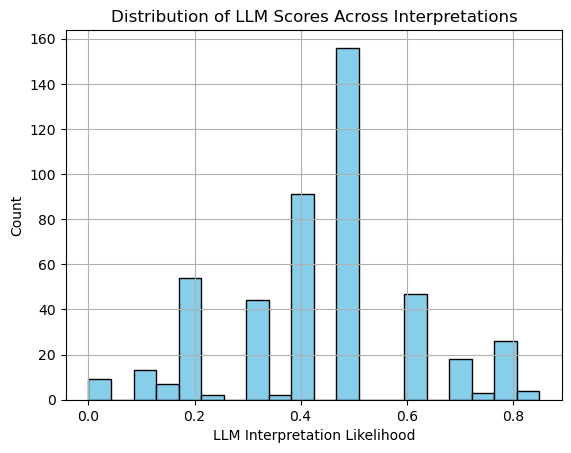

In [11]:
import matplotlib.pyplot as plt

all_llm_scores = []
# ["TRI-15", "TRI-27", "TRI-28","TRI-78","TRI-80", "TRI-81","TRI-82","TRI-83","TRI-84","TRI-86"]
for sample in interpretations_data.values():
    for interp in sample.values():
        llm_score = interp.get("LLM_interpretation_likelihood", None)
        if llm_score is not None:
            all_llm_scores.append(llm_score)

plt.hist(all_llm_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("LLM Interpretation Likelihood")
plt.ylabel("Count")
plt.title("Distribution of LLM Scores Across Interpretations")
plt.grid(True)
plt.show()

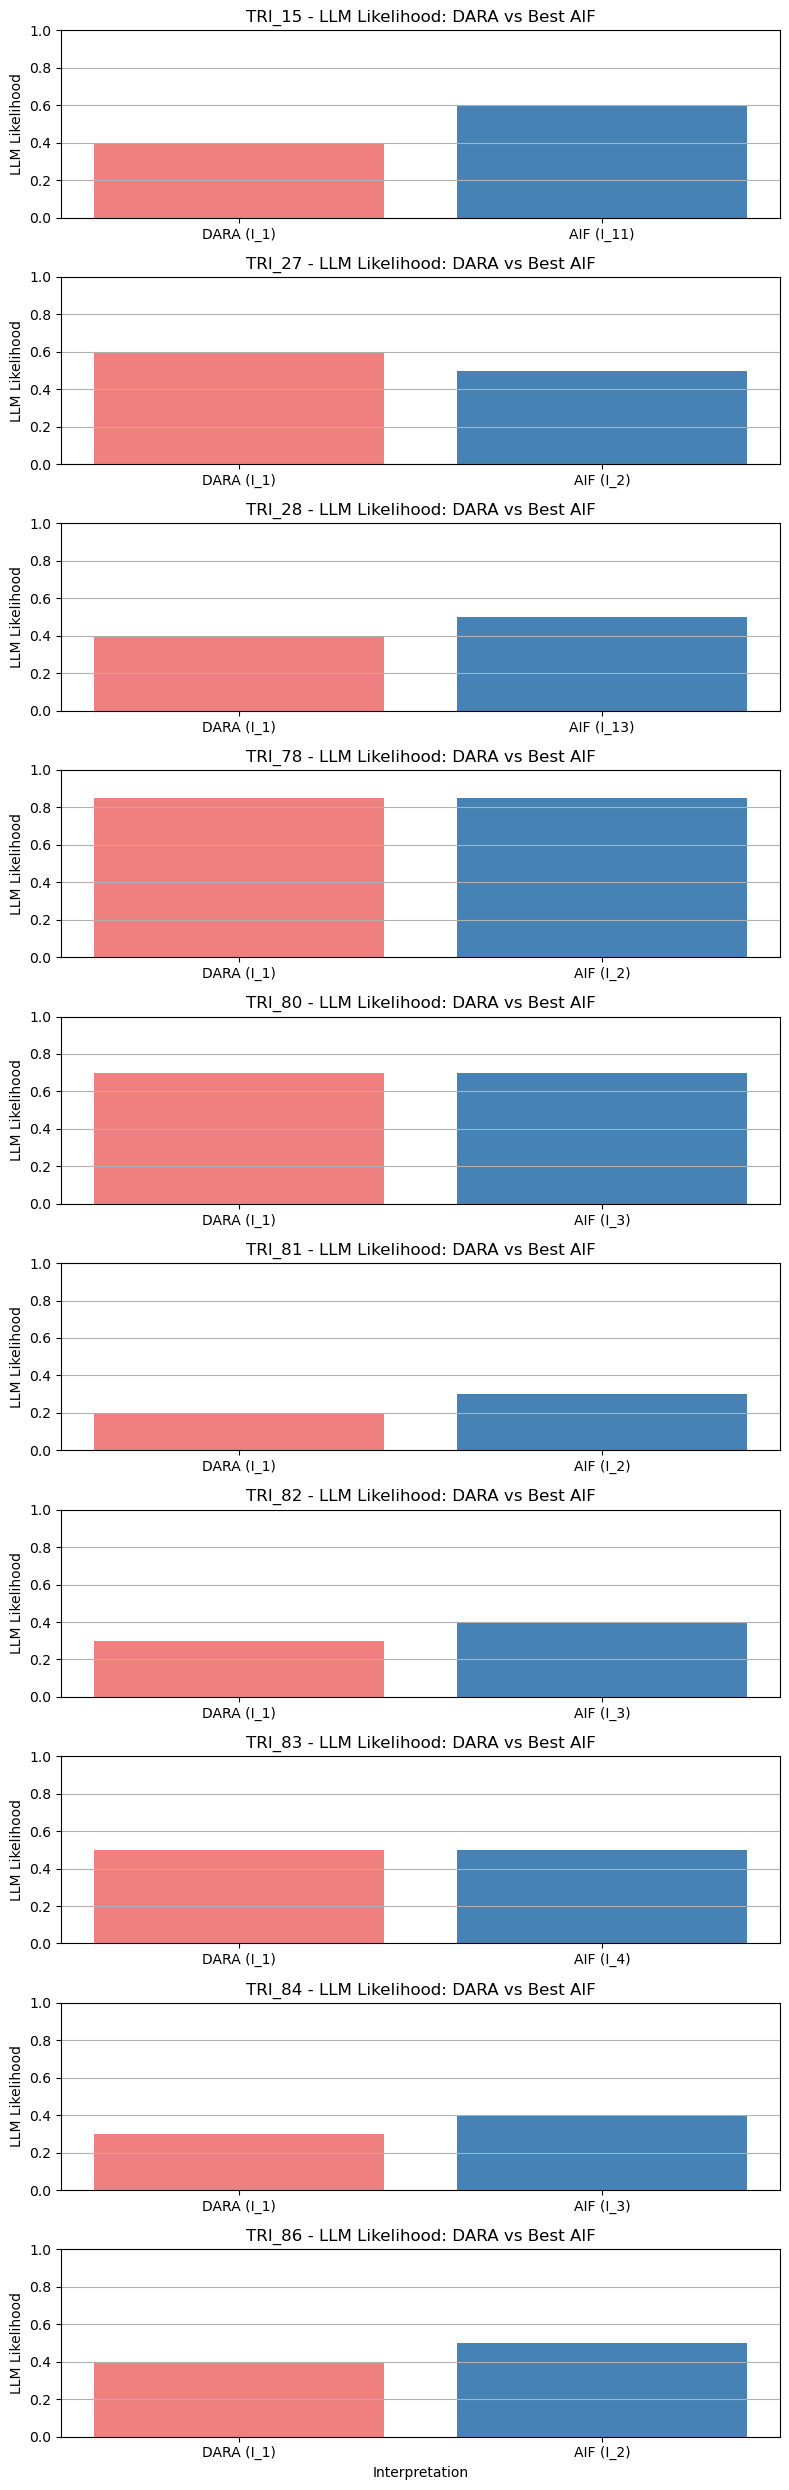

In [12]:
import matplotlib.pyplot as plt

# Choose the specific TRI samples you want to plot
selected_samples = ["TRI_15", "TRI_27", "TRI_28", "TRI_78", "TRI_80", "TRI_81", "TRI_82", "TRI_83", "TRI_84", "TRI_86"]

# Collect LLM scores for DARA and best AIF per sample
plot_data = {}

for tri_key in selected_samples:
    sample = interpretations_data.get(tri_key, {})
    if not sample:
        continue

    dara_llm = sample.get("I_1", {}).get("LLM_interpretation_likelihood", None)

    best_key = None
    best_posterior = -1
    for k, v in sample.items():
        if k != "I_1" and v.get("posterior_probability", -1) > best_posterior:
            best_posterior = v["posterior_probability"]
            best_key = k

    aif_llm = sample.get(best_key, {}).get("LLM_interpretation_likelihood", None) if best_key else None

    if dara_llm is not None and aif_llm is not None:
        plot_data[tri_key] = {
            "DARA (I_1)": dara_llm,
            f"AIF ({best_key})": aif_llm
        }
    
# Check if there’s anything to plot
if not plot_data:
    print("⚠️ No valid samples found with both DARA and AIF LLM scores.")
else:
    # Plot each sample in its own subplot
    num_samples = len(plot_data)
    fig, axes = plt.subplots(nrows=num_samples, ncols=1, figsize=(8, 2.5 * num_samples), sharey=True)

    if num_samples == 1:
        axes = [axes]

    for ax, (sample_name, scores) in zip(axes, plot_data.items()):
        labels = list(scores.keys())
        values = list(scores.values())
        ax.bar(labels, values, color=["lightcoral", "steelblue"])
        ax.set_ylim(0, 1)
        ax.set_ylabel("LLM Likelihood")
        ax.set_title(f"{sample_name} - LLM Likelihood: DARA vs Best AIF")
        ax.grid(True, axis='y')

    axes[-1].set_xlabel("Interpretation")
    plt.tight_layout()
    plt.show()

In [28]:
def summarize_chemist_preferences(evaluation_df):
    """
    Prints the number of times chemists preferred AIF, DARA, Both, or Neither.
    """

    # Fix: use correct column name
    filtered_df = evaluation_df.dropna(subset=["Prefered Interpretation"])

    # Fix: use correct column name
    preference_counts = filtered_df["Prefered Interpretation"].value_counts()

    num_aif = preference_counts.get("A", 0)
    num_dara = preference_counts.get("B", 0)
    num_both = preference_counts.get("both A & B", 0)
    num_neither = preference_counts.get("neither A nor B", 0)

    total = num_aif + num_dara + num_both + num_neither

    print(f"Total completed evaluations: {total}")
    print(f"Preferred AIF: {num_aif}")
    print(f"Preferred DARA: {num_dara}")
    print(f"Preferred Both: {num_both}")
    print(f"Preferred Neither: {num_neither}")

    if total > 0:
        print("\nPercentage Breakdown:")
        print(f"AIF: {num_aif / total * 100:.1f}%")
        print(f"DARA: {num_dara / total * 100:.1f}%")
        print(f"Both: {num_both / total * 100:.1f}%")
        print(f"Neither: {num_neither / total * 100:.1f}%")

In [29]:
evaluation_df = pd.read_csv(evaluation_csv_path)
summarize_chemist_preferences(evaluation_df)

Total completed evaluations: 9
Preferred AIF: 3
Preferred DARA: 2
Preferred Both: 2
Preferred Neither: 2

Percentage Breakdown:
AIF: 33.3%
DARA: 22.2%
Both: 22.2%
Neither: 22.2%


In [40]:
print(evaluation_df.columns.tolist())

['Run Name in ALAB', 'Target', 'Precursor 1', 'Precursor 2', 'Precursor 3', 'Precursor 4', 'Furnace', 'Temperature (C)', 'Dwell Duration (h)', 'Hit Target?', 'Interpretation A', 'Interpretation B', 'Prefered Interpretation', 'Evaluator name', 'Interpretation A: Human Evaluation (0-1, 1 is best)', 'Interpretation A: Reasons for bad evaluation  (multiple selection possible)', 'Interpretation B: Human Evaluation', 'Unnamed: 17', 'Interpretation B: Reasons for bad evaluation (multiple selection possible)', 'Any phase that should not be present?', 'Extra comments']


In [51]:
def normalize_scores_for_sample(interpretations, low_limit=0.3, high_limit=0.9):
    """
    Normalize 'score' fields for all interpretations into a common [low_limit, high_limit] range.
    Returns a new dictionary with 'new_normalized_score' added to each interpretation.
    
    Args:
        interpretations (dict): Dictionary like {'I_1': {...}, 'I_2': {...}, ...}
        low_limit (float): minimum normalized value (default 0.3)
        high_limit (float): maximum normalized value (default 0.9)
    
    Returns:
        dict: A new dictionary with normalized scores
    """
    # Copy to avoid modifying the original
    normalized_interpretations = {k: v.copy() for k, v in interpretations.items()}

    scores = []
    for interp in normalized_interpretations.values():
        if "score" in interp and interp["score"] is not None:
            scores.append(interp["score"])

    if not scores:
        print("No valid scores found to normalize.")
        return normalized_interpretations

    min_score = min(scores)
    max_score = max(scores)

    if min_score == max_score:
        midpoint = (low_limit + high_limit) / 2
        for interp in normalized_interpretations.values():
            interp["new_normalized_score"] = midpoint
        return normalized_interpretations

    for interp in normalized_interpretations.values():
        raw_score = interp.get("score")
        if raw_score is not None:
            normalized = low_limit + (raw_score - min_score) * (high_limit - low_limit) / (max_score - min_score)
            normalized = max(min(normalized, high_limit), low_limit)
            interp["new_normalized_score"] = normalized

    return normalized_interpretations

In [52]:
interpretations = {
        "I_1": {
            "phases": [
                "Ca2V2O7_2"
            ],
            "weight_fraction": [
                100.0
            ],
            "rwp": 5.66,
            "score": 0.3299525361306781,
            "normalized_score": 0.4161521143732692,
            "normalized_rwp": 0.8585,
            "X": 63.73260571866346,
            "interpretation_importance": 100.0,
            "LLM_phases_likelihood": 0.6,
            "LLM_phases_explanation": "Ca2V2O7_2: Ca2V2O7 is a likely phase to form under the given synthesis conditions. The reaction between CaCO3 and V2O5 at 700\u00b0C in an air atmosphere can lead to the formation of Ca2V2O7. The temperature is sufficient to decompose CaCO3 to CaO and CO2, and CaO can then react with V2O5 to form Ca2V2O7. The dwell duration of 8 hours provides ample time for the reaction to proceed to completion. However, the formation of Ca2V2O7 is not guaranteed as it depends on the exact stoichiometry and reaction kinetics. (Likelihood: 0.60, Uncertainty: 0.00, Weight Fraction: 1.00)",
            "LLM_interpretation_likelihood": 0.6,
            "LLM_interpretation_explanation": "The formation of Ca2V2O7 under the given conditions is plausible due to the decomposition of CaCO3 and subsequent reaction with V2O5. The temperature and dwell time are sufficient for the reaction to occur, and the air atmosphere does not hinder the formation of Ca2V2O7. However, the exact stoichiometry and reaction kinetics may affect the final phase composition, leading to a moderate likelihood of Ca2V2O7 formation.",
            "balance_score": 1,
            "prior_probability": 0.8,
            "posterior_probability": 0.13324476285962034
        },
        "I_2": {
            "phases": [
                "C_15",
                "V2O5_15",
                "Ca3V2O8_12",
                "VO2_12"
            ],
            "weight_fraction": [
                56.44268774703557,
                27.509881422924902,
                16.047430830039527,
                0.0
            ],
            "rwp": 6.54,
            "score": -0.25202457123572614,
            "normalized_score": 0.6508669973118594,
            "normalized_rwp": 0.8365,
            "X": 74.36834986559298,
            "interpretation_importance": 10.042898362554146,
            "LLM_phases_likelihood": 0.37280632411067194,
            "LLM_phases_explanation": "C_15: Carbon (C) is not a precursor in this synthesis and is unlikely to form under the given conditions. The furnace atmosphere is air, which would oxidize any carbon present. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.56) V2O5_15: V2O5 is one of the precursors and is likely to remain unreacted or partially reacted under the given conditions. The temperature of 700\u00b0C and the air atmosphere are conducive to the stability of V2O5. (Likelihood: 0.80, Uncertainty: 0.00, Weight Fraction: 0.28) Ca3V2O8_12: Ca3V2O8 can form from the reaction between CaCO3 and V2O5 at high temperatures. The temperature of 700\u00b0C and the dwell duration of 8 hours are sufficient for this phase to form, although the air atmosphere may favor the formation of other vanadium oxides. (Likelihood: 0.60, Uncertainty: 0.00, Weight Fraction: 0.16) VO2_12: VO2 can form from the reduction of V2O5, but the air atmosphere makes this less likely. The temperature of 700\u00b0C is within the range for VO2 formation, but the presence of oxygen in the furnace atmosphere reduces the likelihood. (Likelihood: 0.30, Uncertainty: 0.00, Weight Fraction: 0.00)",
            "LLM_interpretation_likelihood": 0.5,
            "LLM_interpretation_explanation": "The most likely phases to form under the given conditions are V2O5 and Ca3V2O8. V2O5 is a precursor and is stable at 700\u00b0C in an air atmosphere, making its presence highly likely. Ca3V2O8 can form from the reaction between CaCO3 and V2O5 at high temperatures, and the given conditions are sufficient for its formation. The formation of VO2 is less likely due to the oxidizing atmosphere, and the presence of carbon is highly unlikely as it is not a precursor and would be oxidized in air. Overall, the combination of V2O5 and Ca3V2O8 is a plausible interpretation, but the presence of VO2 and carbon reduces the overall likelihood.",
            "balance_score": 0.9216,
            "prior_probability": 0.7108,
            "posterior_probability": 0.1381446436636053
        },
        "I_3": {
            "phases": [
                "C_15",
                "V2O5_15",
                "CaCO3_11",
                "C_46"
            ],
            "weight_fraction": [
                53.98444791019119,
                28.194220308592733,
                17.821331781216085,
                0.0
            ],
            "rwp": 6.09,
            "score": -0.0315273384596608,
            "normalized_score": 0.6372880586963992,
            "normalized_rwp": 0.8477499999999999,
            "X": 74.25190293481995,
            "interpretation_importance": 41.03363820691233,
            "LLM_phases_likelihood": 0.4465105018421818,
            "LLM_phases_explanation": "C_15: Carbon (C) is not a precursor in this synthesis, and its formation is unlikely under the given conditions. The presence of air in the furnace would oxidize any carbon present, reducing the likelihood of forming a solid carbon phase. (Likelihood: 0.20, Uncertainty: 0.00, Weight Fraction: 0.54) V2O5_15: V2O5 is one of the precursors used in the synthesis. Given the temperature of 700\u00b0C and the air atmosphere, V2O5 is likely to remain stable and unreacted, especially if the reaction kinetics are slow or if the stoichiometry is not optimal for complete reaction with CaCO3. (Likelihood: 0.80, Uncertainty: 0.00, Weight Fraction: 0.28) CaCO3_11: CaCO3 is another precursor used in the synthesis. At 700\u00b0C, CaCO3 can decompose to CaO and CO2. However, if the reaction with V2O5 is incomplete, some CaCO3 may remain unreacted, especially considering the relatively short dwell duration of 8 hours. (Likelihood: 0.70, Uncertainty: 0.09, Weight Fraction: 0.18) C_46: Similar to C_15, the formation of another carbon phase (C_46) is highly unlikely under the given conditions. The air atmosphere would oxidize any carbon present, making the formation of a solid carbon phase improbable. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.00)",
            "LLM_interpretation_likelihood": 0.3,
            "LLM_interpretation_explanation": "The likelihood of forming the target phase CaVO2 under the given conditions is low. The presence of V2O5 and CaCO3 as unreacted precursors suggests incomplete reaction, possibly due to insufficient temperature, dwell time, or stoichiometric imbalance. The formation of carbon phases is highly unlikely due to the oxidizing atmosphere in the furnace. Overall, the combination of phases provided is not a valid interpretation of the synthesis conditions.",
            "balance_score": 0.9879,
            "prior_probability": 0.64395,
            "posterior_probability": 0.12495631867089368
        },
        "I_4": {
            "phases": [
                "C_15",
                "V2O5_15",
                "CaCO3_2",
                "VO2_12"
            ],
            "weight_fraction": [
                92.42920932194252,
                6.229982477818861,
                1.340808200238605,
                0.0
            ],
            "rwp": 5.94,
            "score": -0.14427111571187878,
            "normalized_score": 0.6523090830527803,
            "normalized_rwp": 0.8515,
            "X": 75.19045415263902,
            "interpretation_importance": 23.279216978480367,
            "LLM_phases_likelihood": 0.1403713068111696,
            "LLM_phases_explanation": "C_15: Carbon (C) is not a precursor in this synthesis and is unlikely to form under the given conditions. The furnace atmosphere is air, which would oxidize any carbon present. Therefore, the likelihood of forming carbon is very low. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.92) V2O5_15: V2O5 is one of the precursors and is stable at 700\u00b0C in an air atmosphere. The likelihood of V2O5 remaining unreacted is high, especially if the reaction is not complete within the 8-hour dwell time. (Likelihood: 0.70, Uncertainty: 0.05, Weight Fraction: 0.06) CaCO3_2: CaCO3 is another precursor and can decompose at temperatures around 700\u00b0C, releasing CO2 and forming CaO. However, if the decomposition is incomplete, some CaCO3 might remain. The likelihood of CaCO3 being present is moderate. (Likelihood: 0.50, Uncertainty: 0.05, Weight Fraction: 0.01) VO2_12: VO2 can form from the reduction of V2O5, but this typically requires a reducing atmosphere. In an air atmosphere, the formation of VO2 is less likely but not impossible if local reducing conditions occur. The likelihood is moderate. (Likelihood: 0.30, Uncertainty: 0.00, Weight Fraction: 0.00)",
            "LLM_interpretation_likelihood": 0.4,
            "LLM_interpretation_explanation": "The combination of phases suggests incomplete reactions and partial decomposition of precursors. V2O5 is likely to remain due to its stability at 700\u00b0C in air. CaCO3 might not fully decompose, and VO2 could form from partial reduction of V2O5. The presence of carbon is highly unlikely due to the oxidizing atmosphere.",
            "balance_score": 0.8976,
            "prior_probability": 0.6488,
            "posterior_probability": 0.12748880061062187
        },
        "I_5": {
            "phases": [
                "C_15",
                "C_31",
                "CaCO3_2"
            ],
            "weight_fraction": [
                63.37740645880785,
                36.622593541192145,
                0.0
            ],
            "rwp": 6.14,
            "score": -0.172141113081721,
            "normalized_score": 0.6485769688474436,
            "normalized_rwp": 0.8465,
            "X": 74.75384844237219,
            "interpretation_importance": 19.79734637056808,
            "LLM_phases_likelihood": 0.1,
            "LLM_phases_explanation": "C_15: Carbon (C) is not a precursor in this synthesis and is unlikely to form under the given conditions. The furnace atmosphere is air, which would oxidize any carbon present, making the formation of elemental carbon highly improbable. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.63) C_31: Similar to C_15, carbon (C) is not a precursor and is unlikely to form under the given conditions. The air atmosphere would oxidize any carbon, preventing the formation of elemental carbon. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.37) CaCO3_2: Calcium carbonate (CaCO3) is one of the precursors used in the synthesis. At 700\u00b0C in an air atmosphere, CaCO3 can decompose to CaO and CO2. However, if the reaction is incomplete or the dwell time is insufficient, some CaCO3 may remain unreacted. The likelihood of CaCO3 remaining is relatively high due to these factors. (Likelihood: 0.60, Uncertainty: 0.08, Weight Fraction: 0.00)",
            "LLM_interpretation_likelihood": 0.2,
            "LLM_interpretation_explanation": "The combination of phases C_15, C_31, and CaCO3_2 is unlikely to be a valid interpretation. The formation of elemental carbon (C_15 and C_31) is highly improbable under the given synthesis conditions, as the air atmosphere would oxidize any carbon present. The presence of unreacted CaCO3 is more likely due to its role as a precursor and the possibility of incomplete decomposition at 700\u00b0C. Therefore, the overall likelihood of this combination of phases being correct is low.",
            "balance_score": 1,
            "prior_probability": 0.6,
            "posterior_probability": 0.11721502709912382
        },
        "I_6": {
            "phases": [
                "C_15",
                "V2O5_15",
                "CaCO3_2",
                "C_60"
            ],
            "weight_fraction": [
                62.66104474115718,
                19.676739283204498,
                17.662215975638322,
                0.0
            ],
            "rwp": 6.05,
            "score": 0.1221460052511572,
            "normalized_score": 0.6759907301186554,
            "normalized_rwp": 0.8487500000000001,
            "X": 76.23703650593278,
            "interpretation_importance": 64.59915357270225,
            "LLM_phases_likelihood": 0.321052625785761,
            "LLM_phases_explanation": "C_15: Carbon (C) is not a precursor in this synthesis and is unlikely to form under the given conditions. The furnace atmosphere is air, which would oxidize any carbon present, making the formation of elemental carbon phases highly improbable. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.63) V2O5_15: V2O5 is one of the precursors used in the synthesis. Given the temperature of 700\u00b0C and the air atmosphere, V2O5 is likely to remain stable and unreacted, especially if the reaction kinetics are slow or if the stoichiometry is not optimal for complete reaction with CaCO3. (Likelihood: 0.80, Uncertainty: 0.00, Weight Fraction: 0.20) CaCO3_2: CaCO3 is another precursor used in the synthesis. At 700\u00b0C in an air atmosphere, CaCO3 can decompose to CaO and CO2. However, if the reaction with V2O5 is incomplete, some CaCO3 may remain unreacted, leading to a moderate likelihood of its presence. (Likelihood: 0.60, Uncertainty: 0.05, Weight Fraction: 0.18) C_60: C_60 (fullerene) is highly unlikely to form under these conditions. The synthesis does not involve any carbon sources that could lead to the formation of fullerenes, and the air atmosphere would further prevent the formation of such carbon structures. (Likelihood: 0.05, Uncertainty: 0.00, Weight Fraction: 0.00)",
            "LLM_interpretation_likelihood": 0.2,
            "LLM_interpretation_explanation": "The combination of phases suggested is not very likely. V2O5 is likely to remain as an unreacted precursor due to the synthesis conditions. CaCO3 may also remain partially unreacted, but the formation of elemental carbon phases (C_15 and C_60) is highly improbable in an air atmosphere at 700\u00b0C. The overall interpretation suggests incomplete reaction between the precursors, with V2O5 and CaCO3 being the most likely phases present.",
            "balance_score": 0.9991,
            "prior_probability": 0.59955,
            "posterior_probability": 0.11945103016547041
        },
        "I_7": {
            "phases": [
                "C_15",
                "C_61",
                "V2O5_15",
                "VO2_12"
            ],
            "weight_fraction": [
                44.73372781065089,
                24.260355029585803,
                15.680473372781067,
                15.325443786982248
            ],
            "rwp": 6.59,
            "score": -0.3245915297807002,
            "normalized_score": 0.6357581433679413,
            "normalized_rwp": 0.8352499999999999,
            "X": 73.55040716839707,
            "interpretation_importance": 0.08458754352969265,
            "LLM_phases_likelihood": 0.26745284701524036,
            "LLM_phases_explanation": "C_15: Carbon phases are unlikely to form under the given synthesis conditions. The furnace atmosphere is air, which would oxidize any carbon present. Additionally, the precursors do not contain carbon in a form that would lead to the formation of solid carbon phases. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.45) C_61: Similar to C_15, the formation of carbon phases is unlikely due to the oxidizing atmosphere of the furnace and the absence of carbon in the precursors. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.24) V2O5_15: V2O5 is one of the precursors and is likely to remain unreacted or partially reacted under the given conditions. The temperature of 700\u00b0C and the air atmosphere are conducive to the stability of V2O5, making its presence highly probable. (Likelihood: 0.80, Uncertainty: 0.00, Weight Fraction: 0.16) VO2_12: VO2 can form from the reduction of V2O5, and the temperature of 700\u00b0C is within the range where VO2 is stable. However, the air atmosphere may limit the extent of reduction, making the formation of VO2 possible but not highly likely. (Likelihood: 0.50, Uncertainty: 0.05, Weight Fraction: 0.15)",
            "LLM_interpretation_likelihood": 0.4,
            "LLM_interpretation_explanation": "The combination of phases includes V2O5, which is a precursor and likely to remain under the given conditions, and VO2, which can form from the partial reduction of V2O5. The presence of carbon phases (C_15 and C_61) is highly unlikely due to the oxidizing atmosphere of the furnace and the absence of carbon in the precursors. The overall likelihood is moderate, primarily due to the probable presence of V2O5 and the potential formation of VO2.",
            "balance_score": 0.375,
            "prior_probability": 0.3875,
            "posterior_probability": 0.07448267648311611
        },
        "I_8": {
            "phases": [
                "C_15",
                "C_61",
                "V2O5_15",
                "C_60"
            ],
            "weight_fraction": [
                67.19424460431654,
                17.98561151079137,
                14.82014388489209,
                0.0
            ],
            "rwp": 6.65,
            "score": -0.3281523319740233,
            "normalized_score": 0.6097007392479488,
            "normalized_rwp": 0.83375,
            "X": 72.17253696239744,
            "interpretation_importance": 0.0,
            "LLM_phases_likelihood": 0.2037410071942446,
            "LLM_phases_explanation": "C_15: Carbon phases such as C_15 are unlikely to form under these conditions. The synthesis is conducted in air, which would oxidize any carbon present. Additionally, the precursors do not contain elemental carbon, making the formation of carbon phases improbable. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.67) C_61: Similar to C_15, the formation of C_61 is unlikely due to the oxidative atmosphere of the furnace and the absence of elemental carbon in the precursors. Any carbon present would likely be oxidized to CO2. (Likelihood: 0.10, Uncertainty: 0.00, Weight Fraction: 0.18) V2O5_15: V2O5 is one of the precursors and is likely to remain unreacted or partially reacted under the given conditions. The temperature of 700\u00b0C and the air atmosphere are conducive to the stability of V2O5, making its presence highly probable. (Likelihood: 0.80, Uncertainty: 0.00, Weight Fraction: 0.15) C_60: The formation of C_60 is also unlikely for the same reasons as C_15 and C_61. The oxidative atmosphere and the lack of elemental carbon in the precursors make the formation of carbon phases improbable. (Likelihood: 0.10, Uncertainty: 0.02, Weight Fraction: 0.00)",
            "LLM_interpretation_likelihood": 0.2,
            "LLM_interpretation_explanation": "The likelihood of forming the target phase CaVO2 under the given conditions is low. The presence of V2O5 as an unreacted precursor is highly probable, but the formation of carbon phases such as C_15, C_61, and C_60 is highly unlikely due to the oxidative environment in the air furnace. The overall interpretation suggests that the synthesis conditions are not optimal for forming the desired CaVO2 phase, and the presence of unreacted V2O5 indicates incomplete reaction.",
            "balance_score": 0.375,
            "prior_probability": 0.2875,
            "posterior_probability": 0.05422609203379205
        },
        "I_9": {
            "phases": [
                "V2O5_15"
            ],
            "weight_fraction": [
                100.0
            ],
            "rwp": 6.66,
            "score": -0.3281523319740233,
            "normalized_score": 0.6097007392479488,
            "normalized_rwp": 0.8335000000000001,
            "X": 72.16003696239744,
            "interpretation_importance": 0.06883336570919664,
            "LLM_phases_likelihood": 0.7999999999999999,
            "LLM_phases_explanation": "V2O5_15: V2O5 is one of the precursors used in the synthesis. Given the synthesis conditions of 700\u00b0C and 8 hours in an air atmosphere, it is likely that some amount of V2O5 remains unreacted. V2O5 is stable in air at this temperature, and the relatively short dwell time may not be sufficient for complete reaction with CaCO3 to form the target phase CaVO2. (Likelihood: 0.80, Uncertainty: 0.00, Weight Fraction: 1.00)",
            "LLM_interpretation_likelihood": 0.8,
            "LLM_interpretation_explanation": "The presence of V2O5 as an unreacted precursor is highly likely under the given synthesis conditions. The temperature and air atmosphere favor the stability of V2O5, and the dwell time may not be sufficient for complete reaction with CaCO3. Therefore, the interpretation that V2O5 is present in the sample is plausible.",
            "balance_score": 0.375,
            "prior_probability": 0.5875,
            "posterior_probability": 0.11079064841375634
        }
}

In [53]:
new=normalize_scores_for_sample(interpretations)

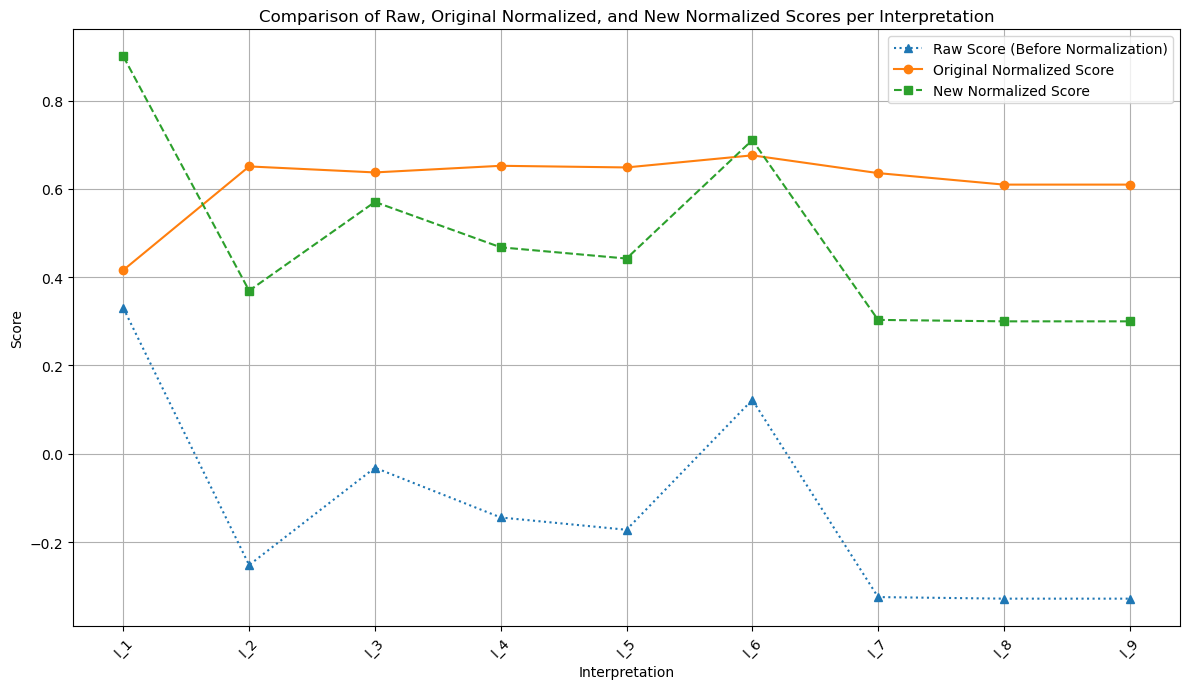

In [55]:
import matplotlib.pyplot as plt



# Function to normalize scores for a sample
def normalize_scores_for_sample(interpretations, low_limit=0.3, high_limit=0.9):
    normalized_interpretations = {k: v.copy() for k, v in interpretations.items()}
    scores = [interp["score"] for interp in normalized_interpretations.values() if interp.get("score") is not None]

    if not scores:
        print("No valid scores found to normalize.")
        return normalized_interpretations

    min_score = min(scores)
    max_score = max(scores)

    if min_score == max_score:
        midpoint = (low_limit + high_limit) / 2
        for interp in normalized_interpretations.values():
            interp["new_normalized_score"] = midpoint
        return normalized_interpretations

    for interp in normalized_interpretations.values():
        raw_score = interp.get("score")
        if raw_score is not None:
            normalized = low_limit + (raw_score - min_score) * (high_limit - low_limit) / (max_score - min_score)
            normalized = max(min(normalized, high_limit), low_limit)
            interp["new_normalized_score"] = normalized

    return normalized_interpretations

# Apply normalization
normalized_interpretations = normalize_scores_for_sample(new)

# Prepare data for plotting
labels = list(normalized_interpretations.keys())
original_norm_scores = [interpretations[i]["normalized_score"] for i in labels]
new_norm_scores = [normalized_interpretations[i]["new_normalized_score"] for i in labels]
raw_scores = [interpretations[i]["score"] for i in labels]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))
x = range(len(labels))

# Plot raw scores
ax.plot(x, raw_scores, marker='^', label="Raw Score (Before Normalization)", linestyle=':')

# Plot original normalized scores
ax.plot(x, original_norm_scores, marker='o', label="Original Normalized Score")

# Plot new normalized scores
ax.plot(x, new_norm_scores, marker='s', label="New Normalized Score", linestyle='--')

# Labels and layout
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("Interpretation")
ax.set_ylabel("Score")
ax.set_title("Comparison of Raw, Original Normalized, and New Normalized Scores per Interpretation")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [58]:
import json
import matplotlib.pyplot as plt

# Load your interpretations.json
# If your file is already loaded in a dictionary called `interpretations_json`, skip this step.
# Otherwise, load it from file:
with open('../src/interpretations.json', 'r') as f:
    interpretations_json = json.load(f)

# Normalization function
def normalize_scores_for_sample(interpretations, low_limit=0.3, high_limit=0.9):
    """
    Normalize 'score' fields for all interpretations into a common [low_limit, high_limit] range.
    Returns a new dictionary with 'new_normalized_score' added to each interpretation.
    """
    normalized_interpretations = {k: v.copy() for k, v in interpretations.items()}
    scores = [interp["score"] for interp in normalized_interpretations.values() if interp.get("score") is not None]

    if not scores:
        print("No valid scores found to normalize.")
        return normalized_interpretations

    min_score = min(scores)
    max_score = max(scores)

    if min_score == max_score:
        midpoint = (low_limit + high_limit) / 2
        for interp in normalized_interpretations.values():
            interp["new_normalized_score"] = midpoint
        return normalized_interpretations

    for interp in normalized_interpretations.values():
        raw_score = interp.get("score")
        if raw_score is not None:
            normalized = low_limit + (raw_score - min_score) * (high_limit - low_limit) / (max_score - min_score)
            normalized = max(min(normalized, high_limit), low_limit)
            interp["new_normalized_score"] = normalized

    return normalized_interpretations

# Plotting function for a sample
def plot_sample_scores(sample_name, sample_interpretations):
    """
    Plot raw score, original normalized score, and new normalized score for one sample.
    """
    normalized_interpretations = normalize_scores_for_sample(sample_interpretations)

    labels = list(normalized_interpretations.keys())
    raw_scores = [sample_interpretations[i]["score"] for i in labels]
    original_norm_scores = [sample_interpretations[i]["normalized_score"] for i in labels]
    new_norm_scores = [normalized_interpretations[i]["new_normalized_score"] for i in labels]

    fig, ax = plt.subplots(figsize=(12, 7))
    x = range(len(labels))

    ax.plot(x, raw_scores, marker='^', label="Raw Score (Before Normalization)", linestyle=':')
    ax.plot(x, original_norm_scores, marker='o', label="Original Normalized Score")
    ax.plot(x, new_norm_scores, marker='s', label="New Normalized Score", linestyle='--')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Interpretation")
    ax.set_ylabel("Score")
    ax.set_title(f"Comparison of Scores for Sample: {sample_name}")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Main loop to plot for each sample
# for sample_name, sample_interpretations in interpretations_json.items():
#     plot_sample_scores(sample_name, sample_interpretations)

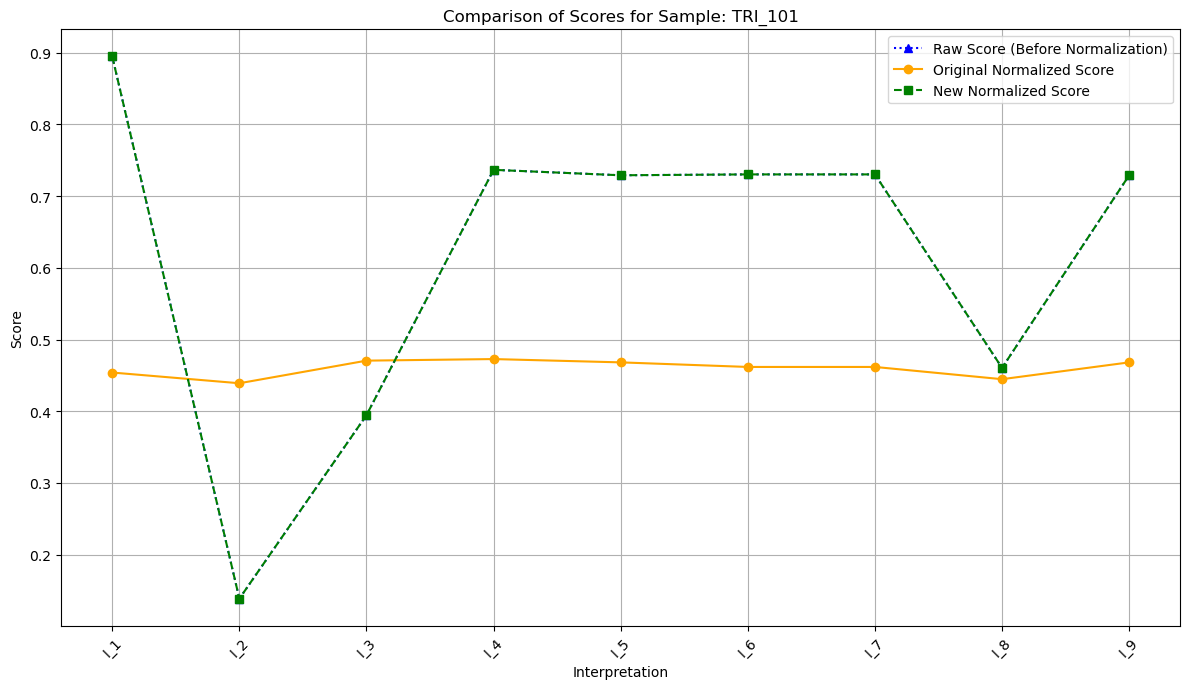

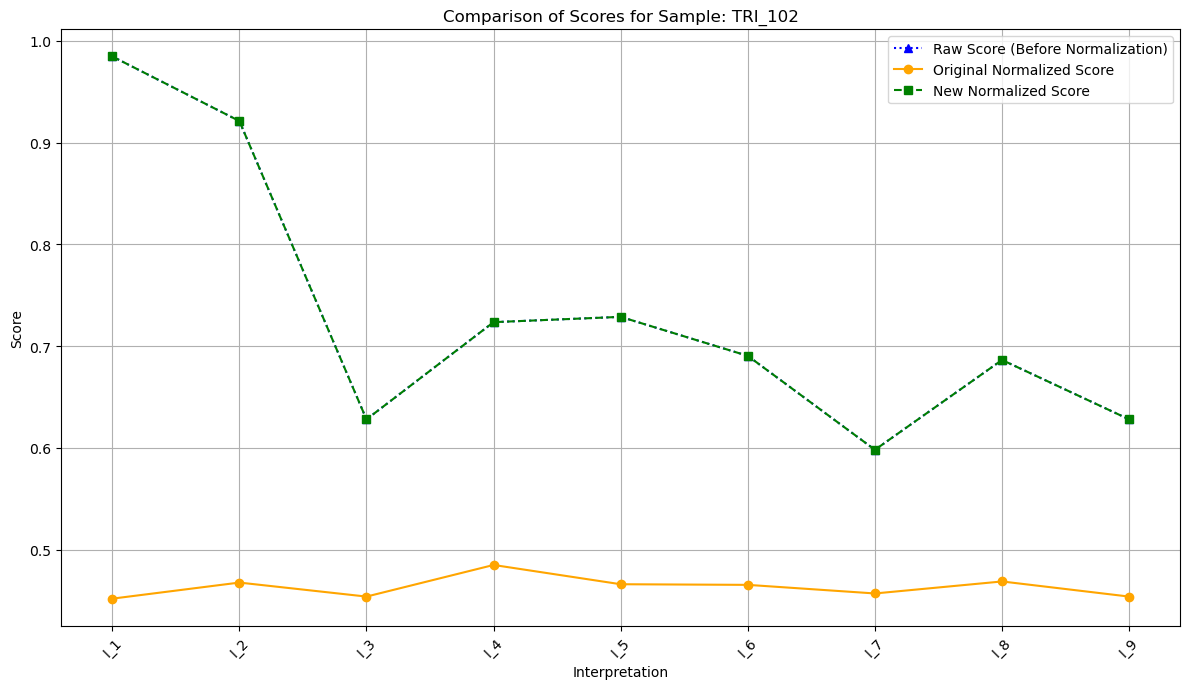

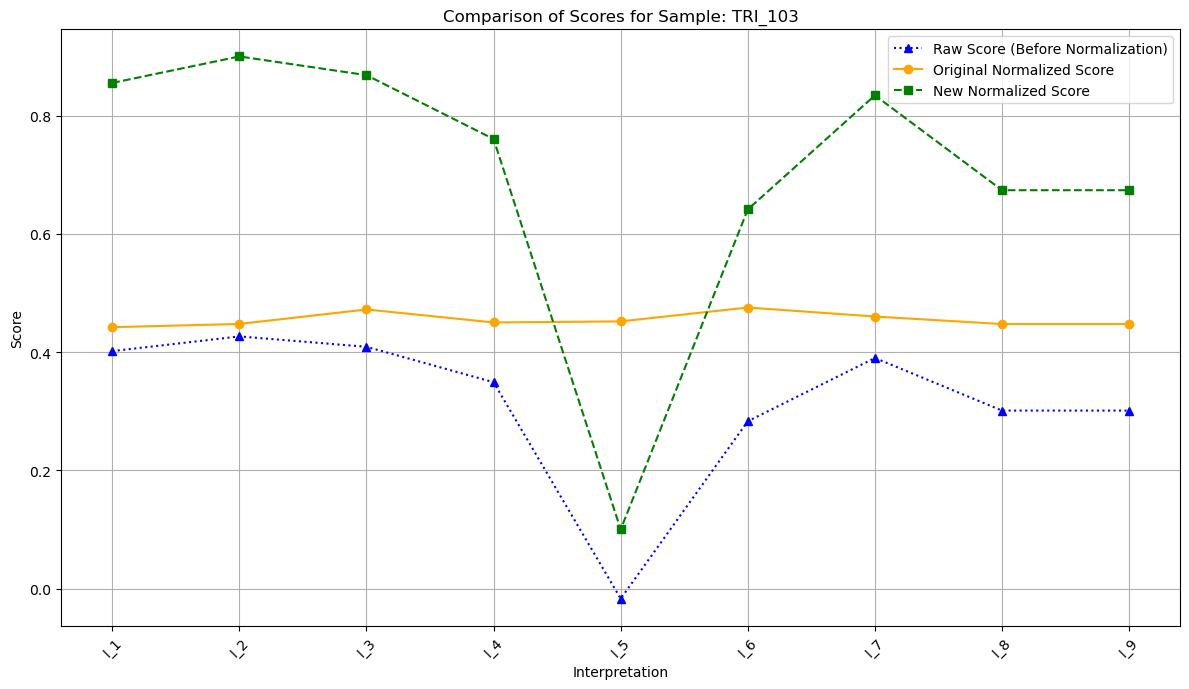

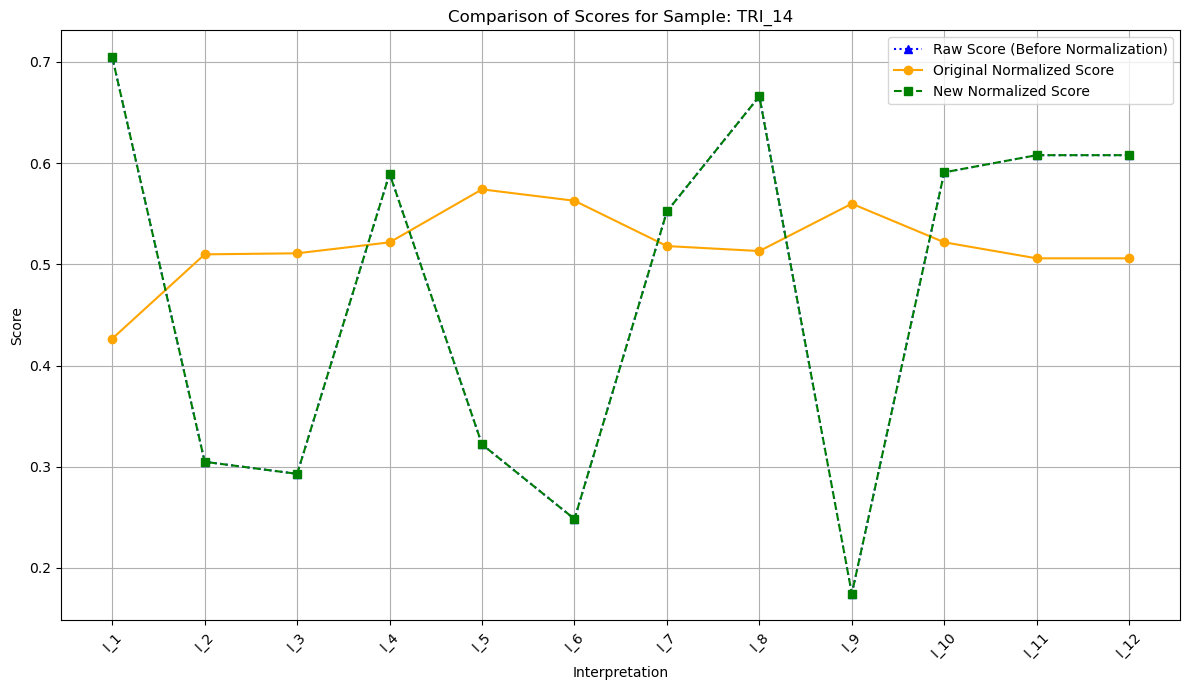

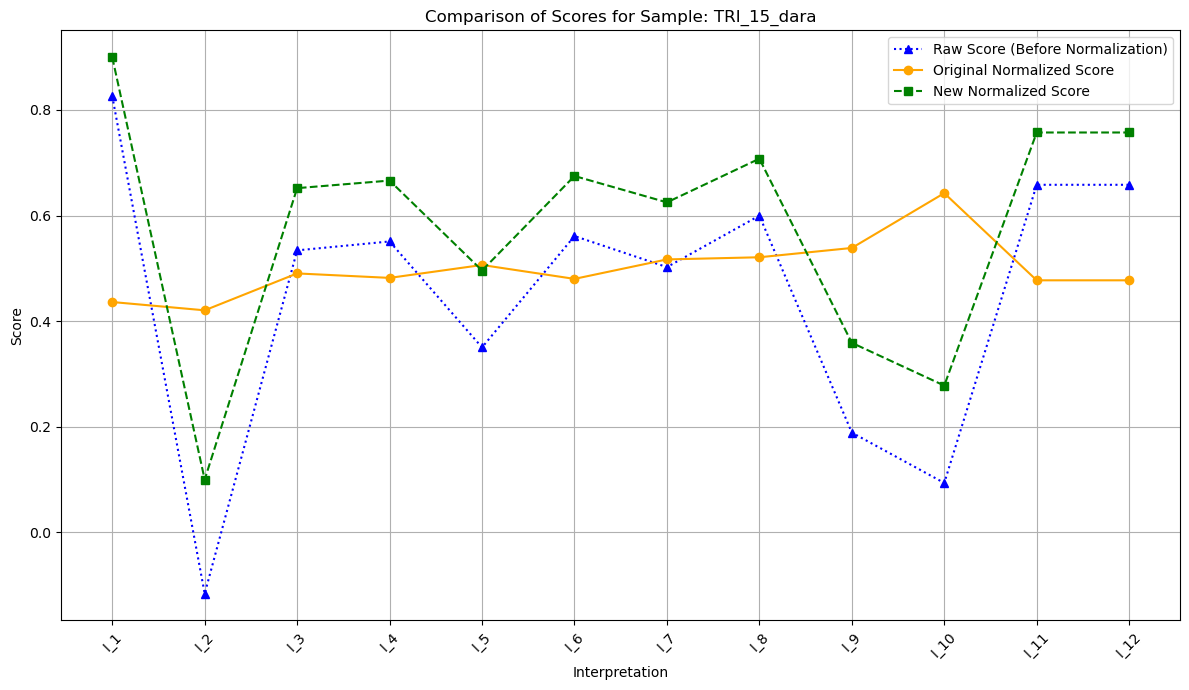

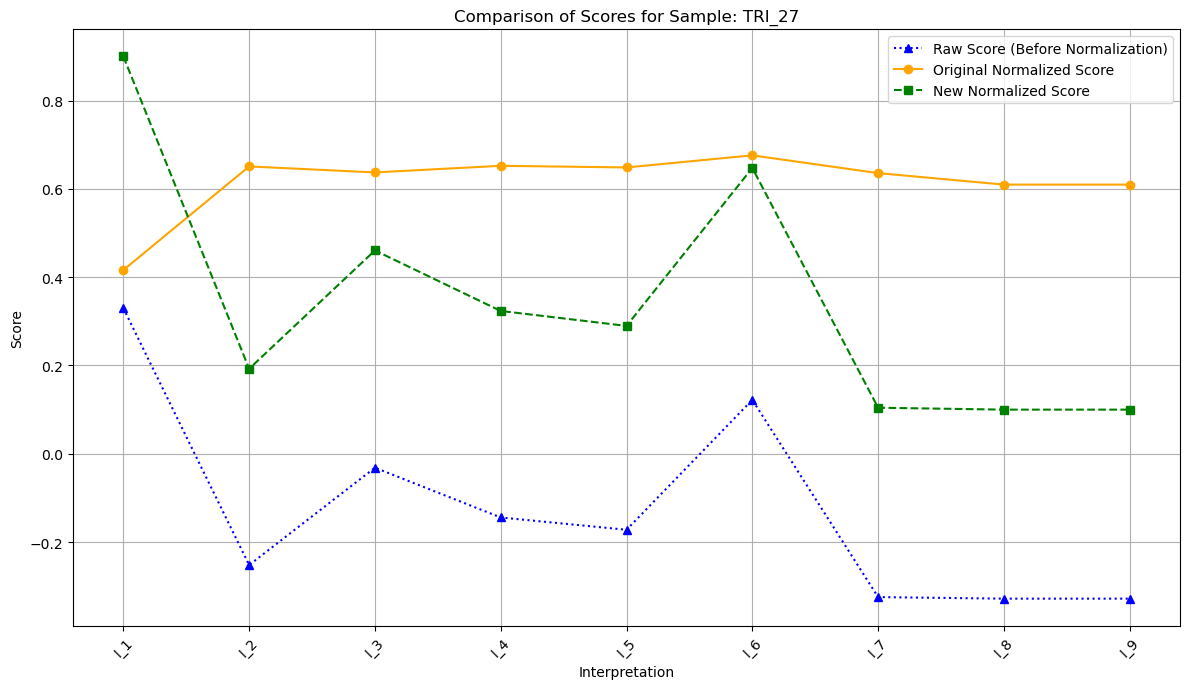

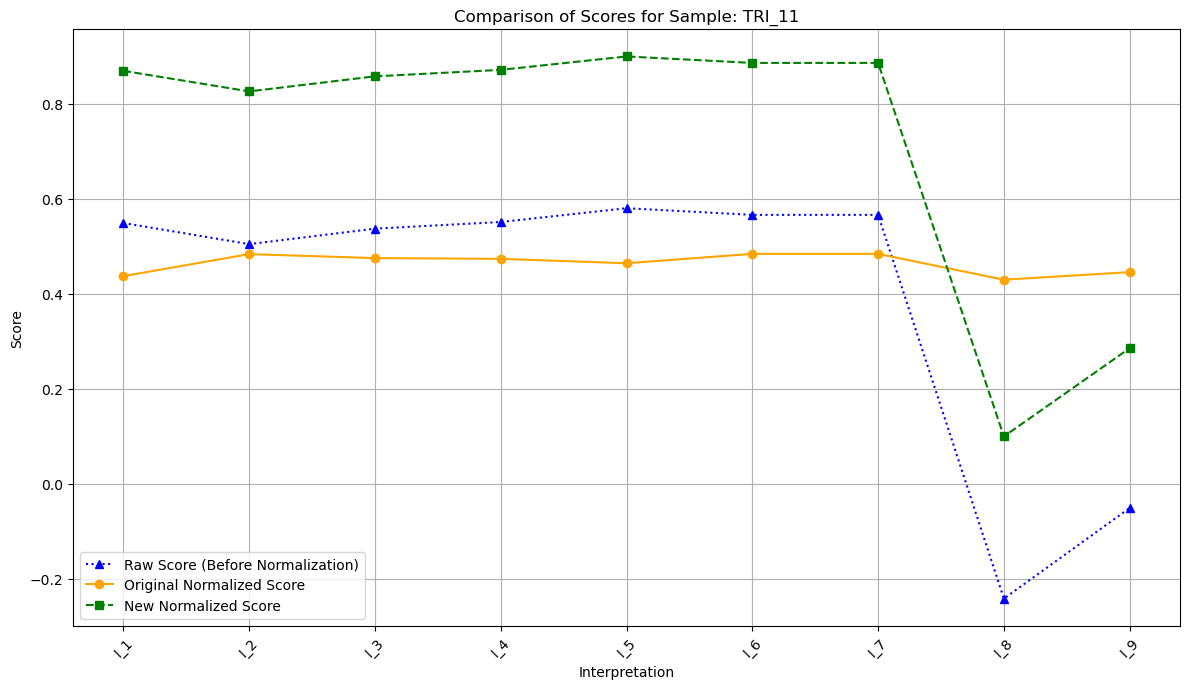

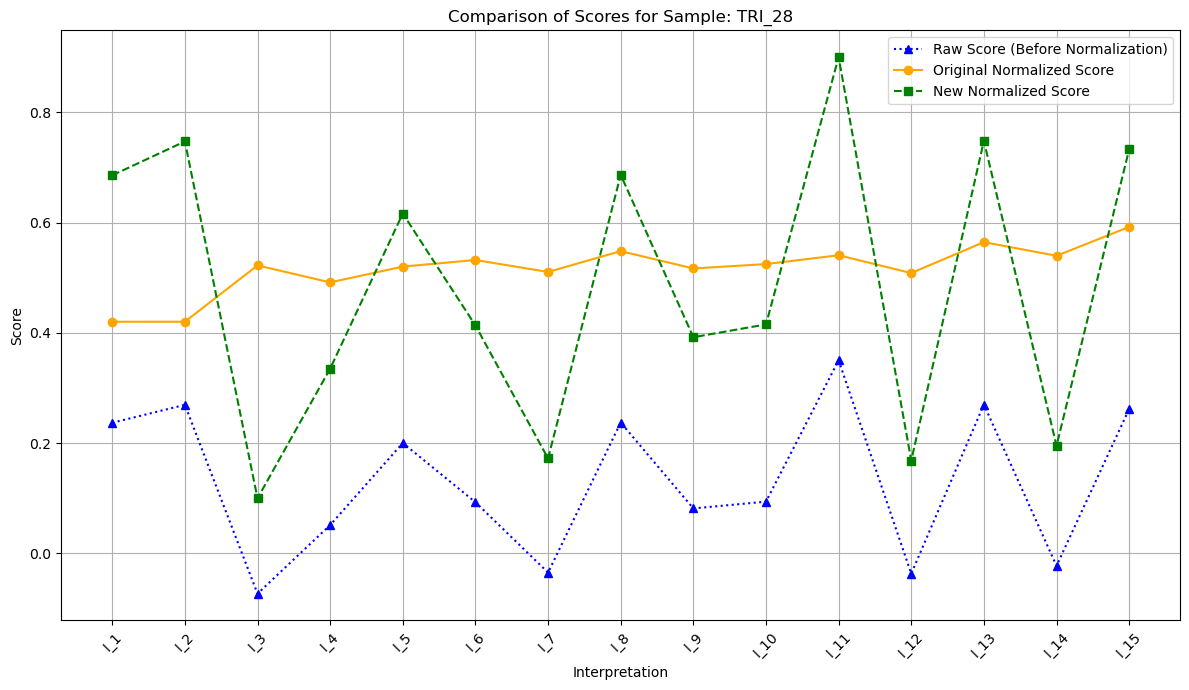

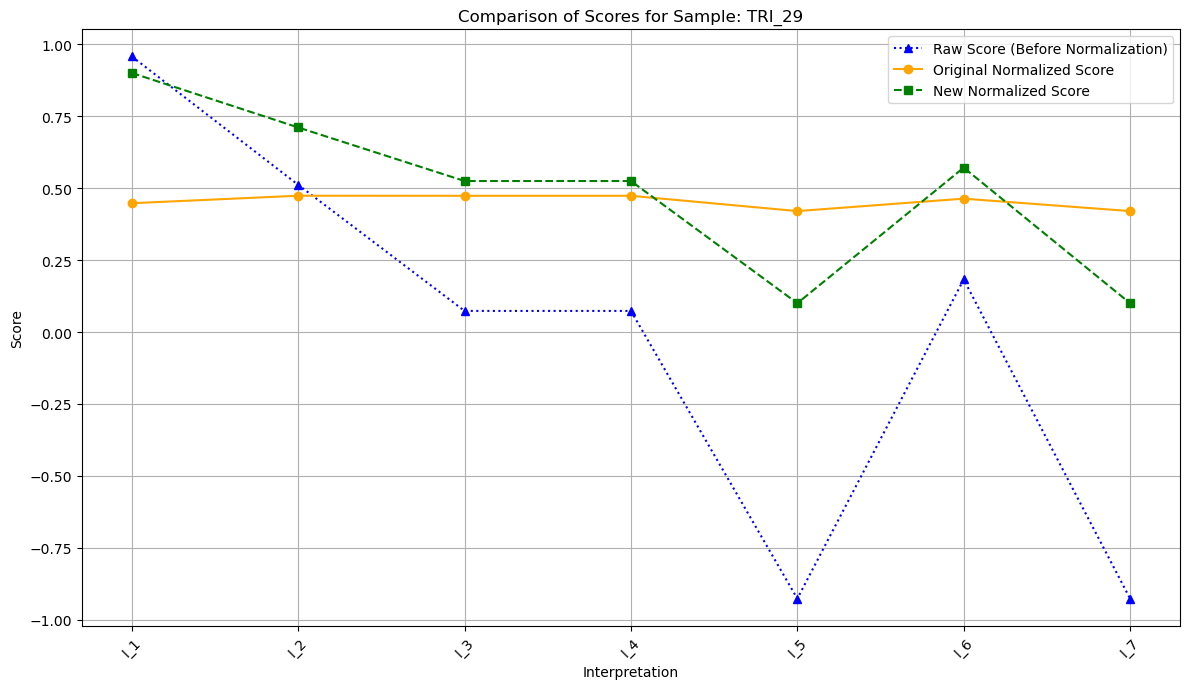

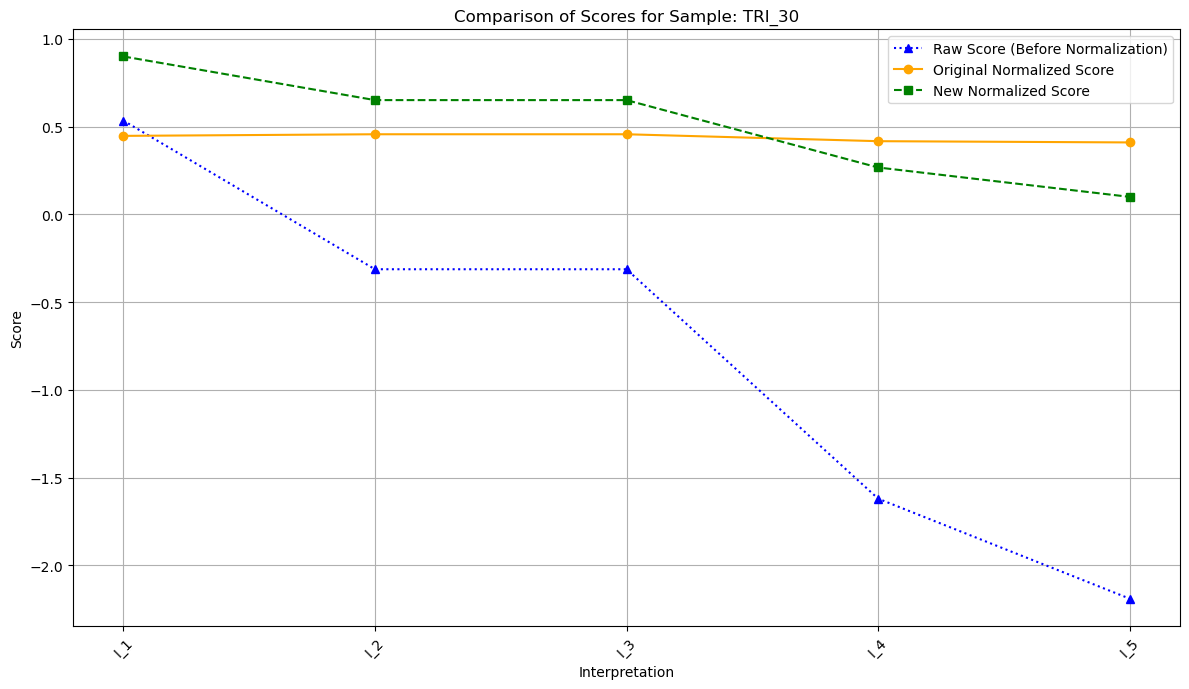

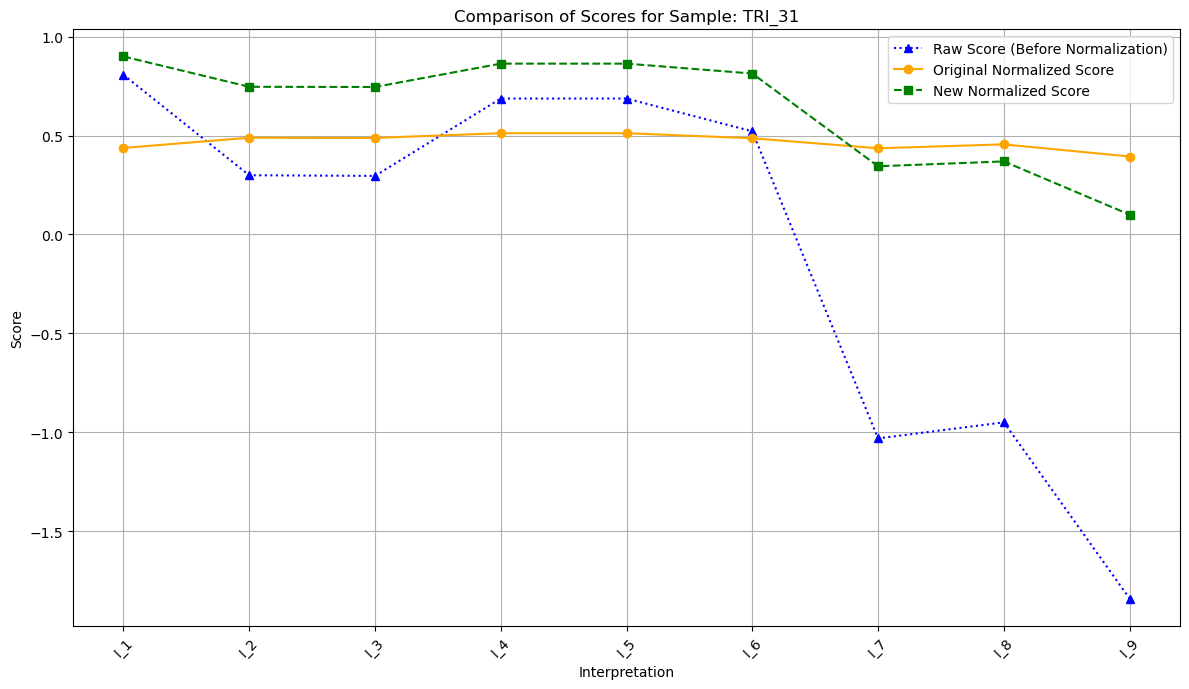

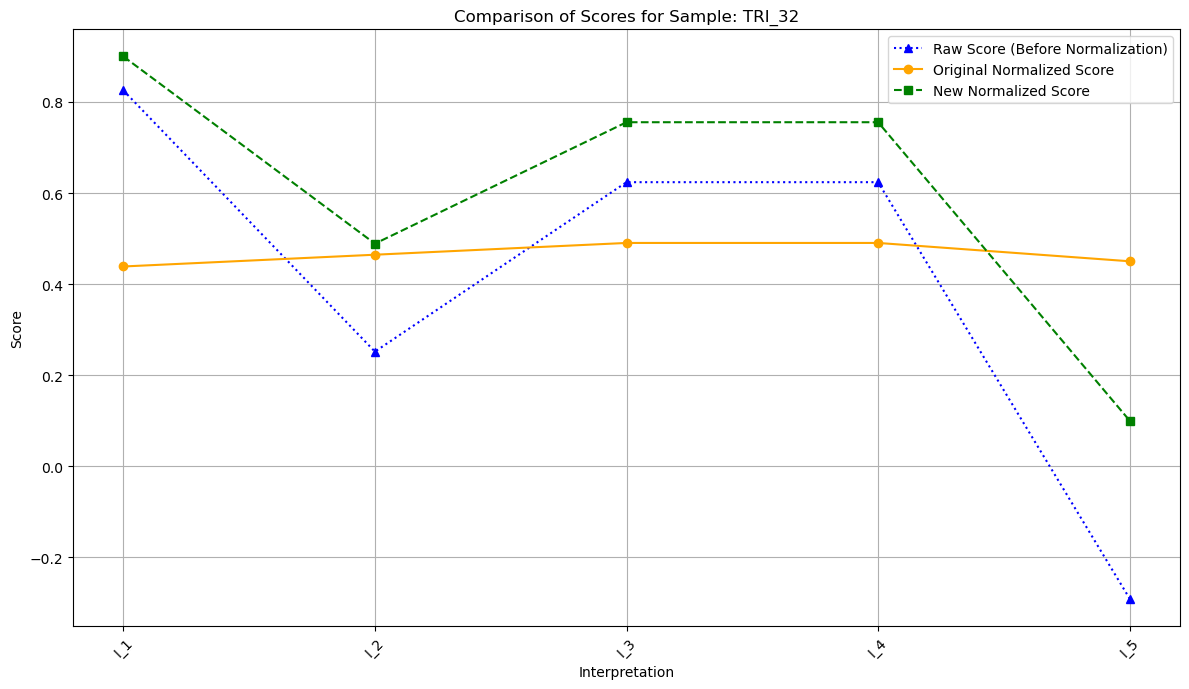

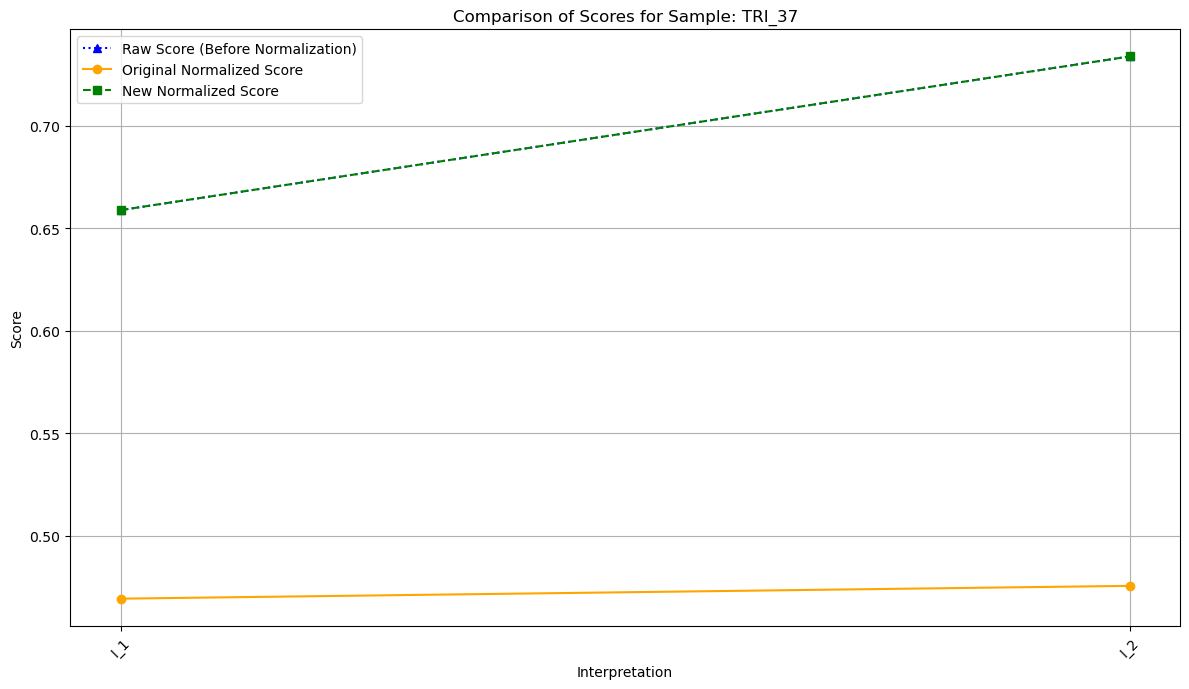

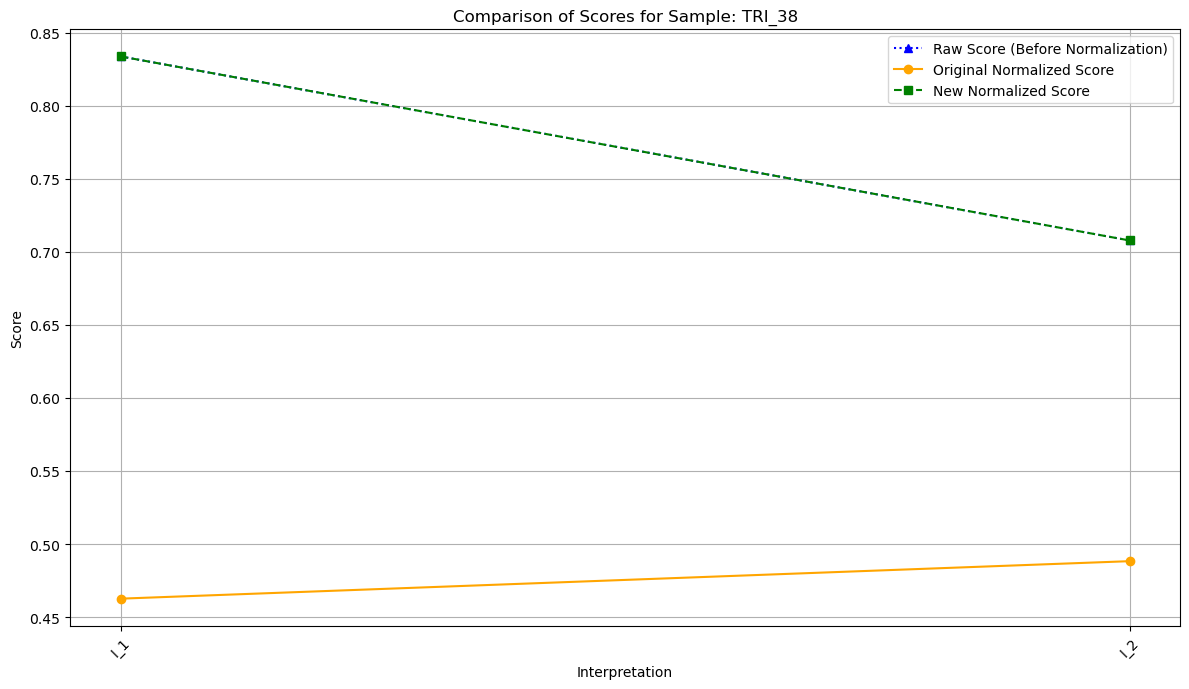

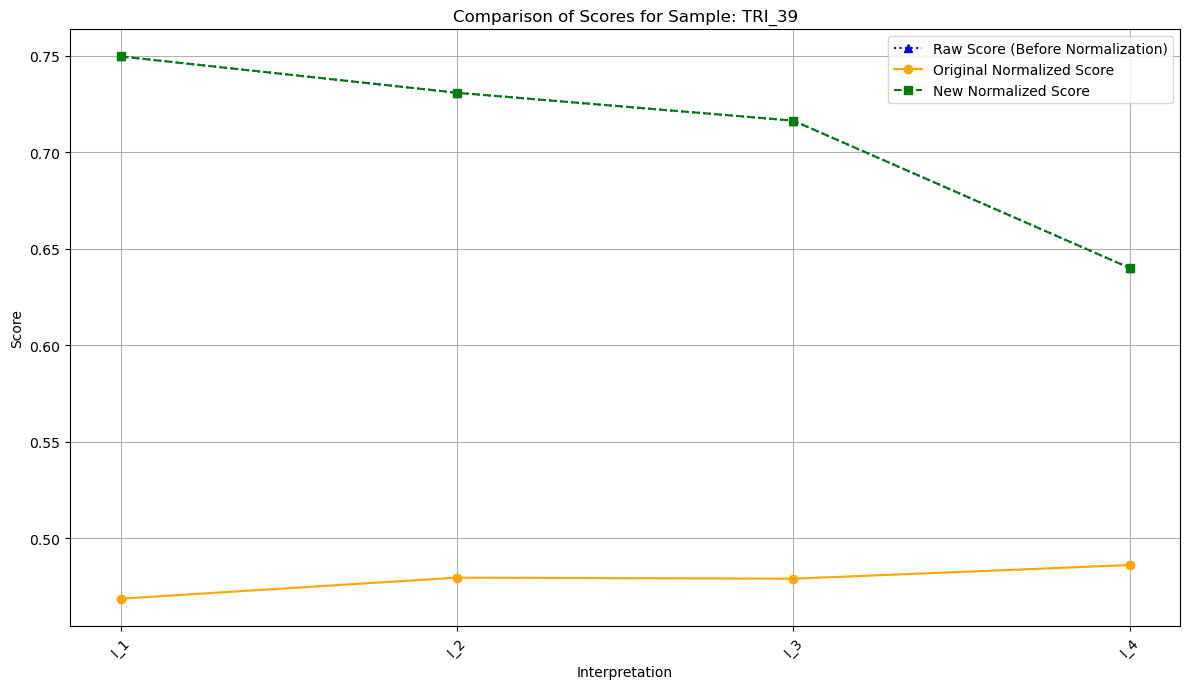

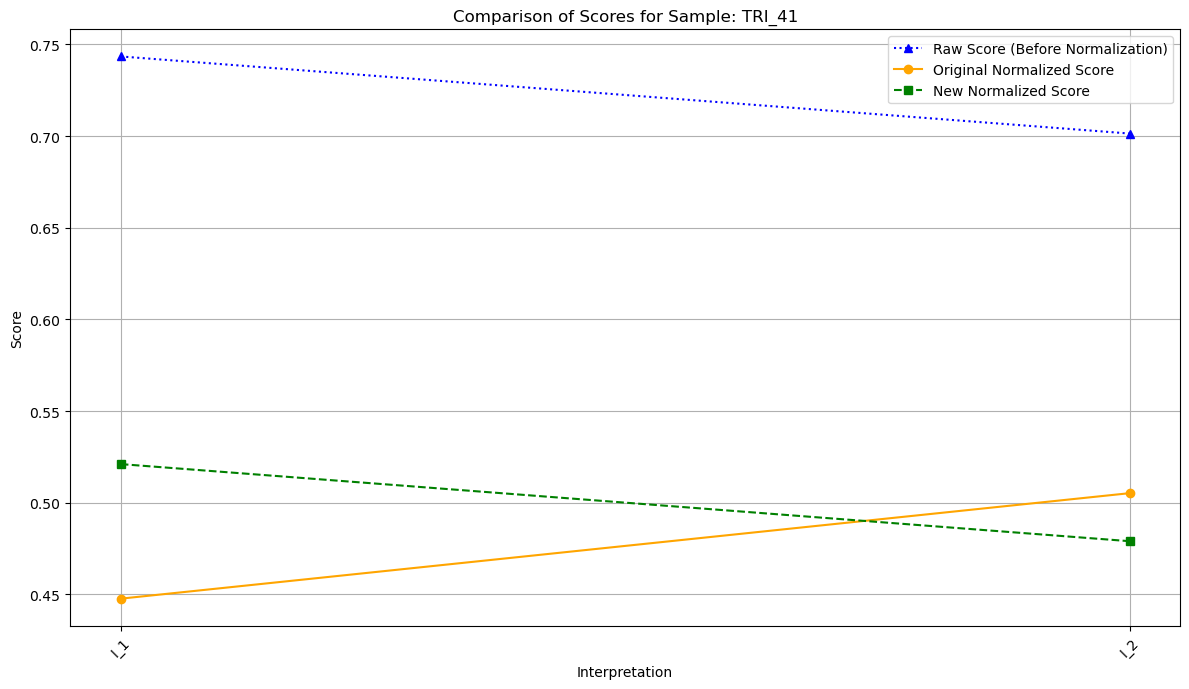

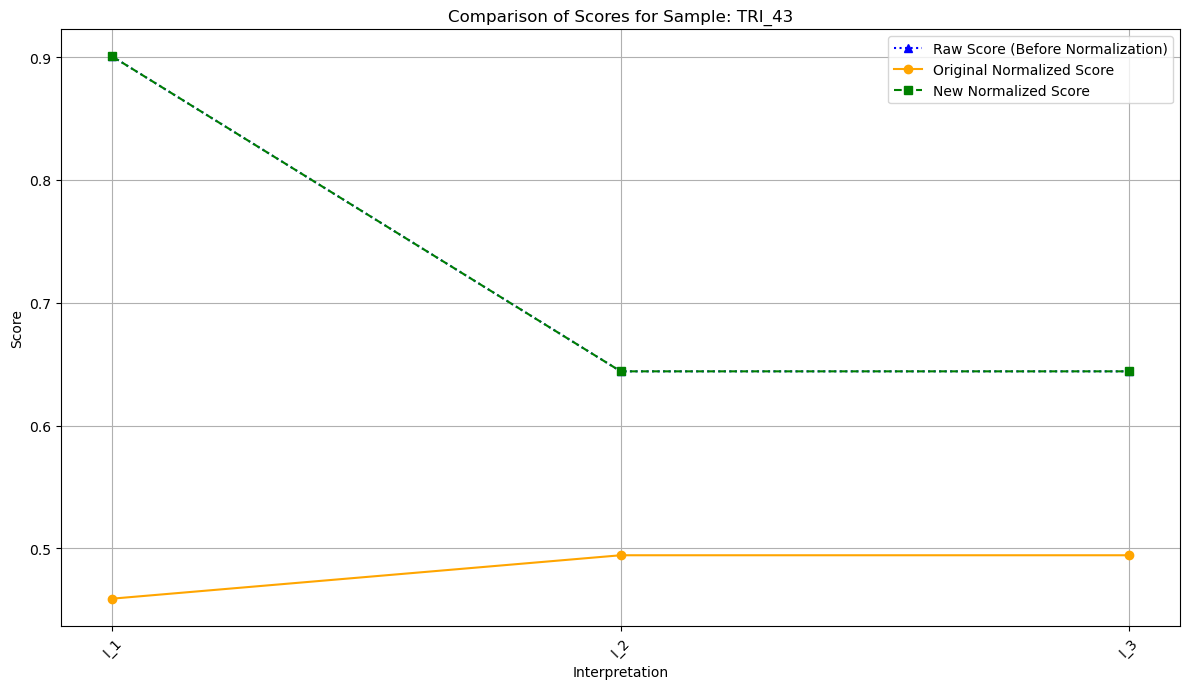

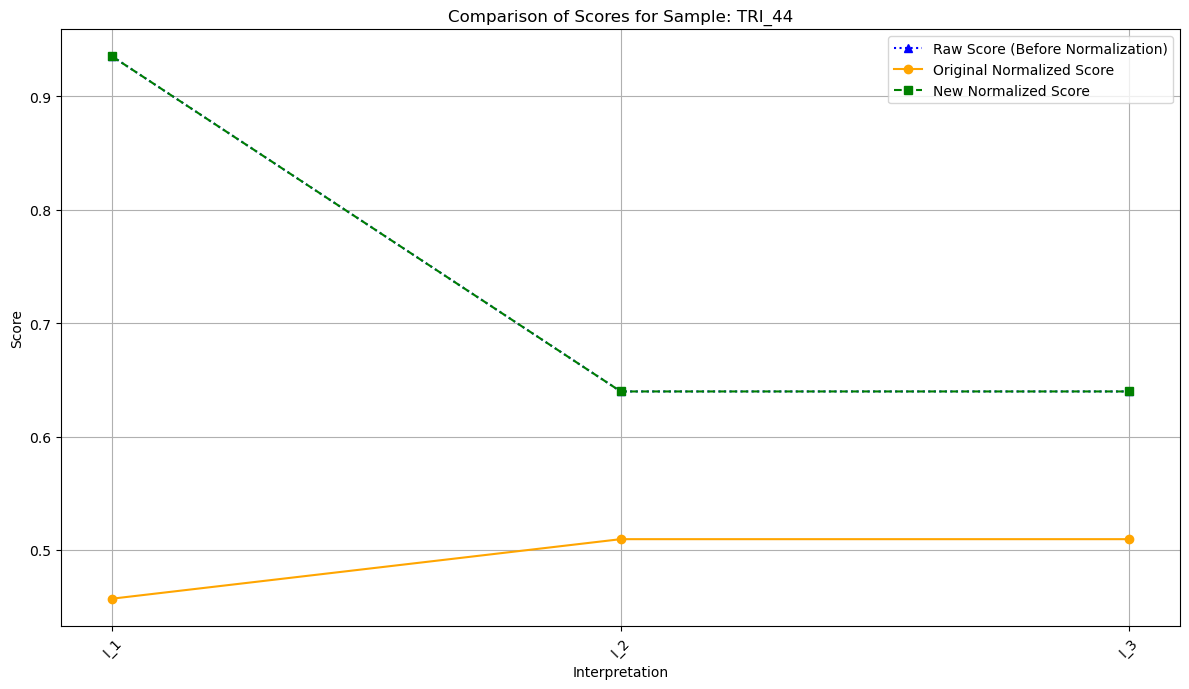

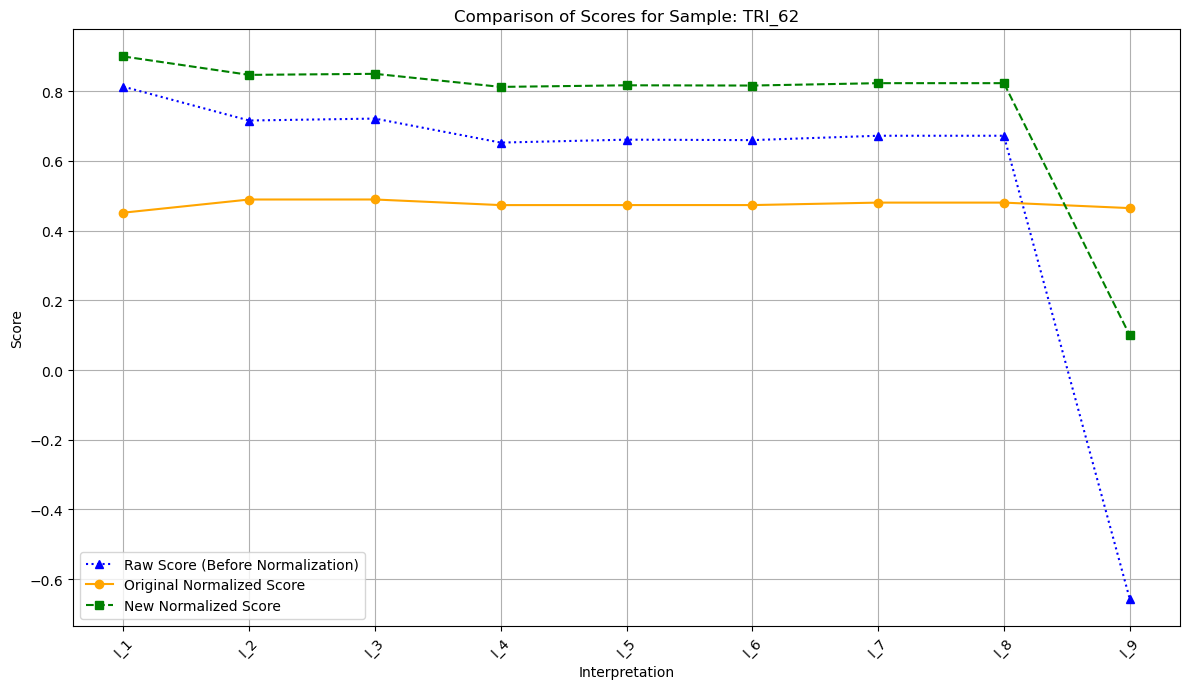

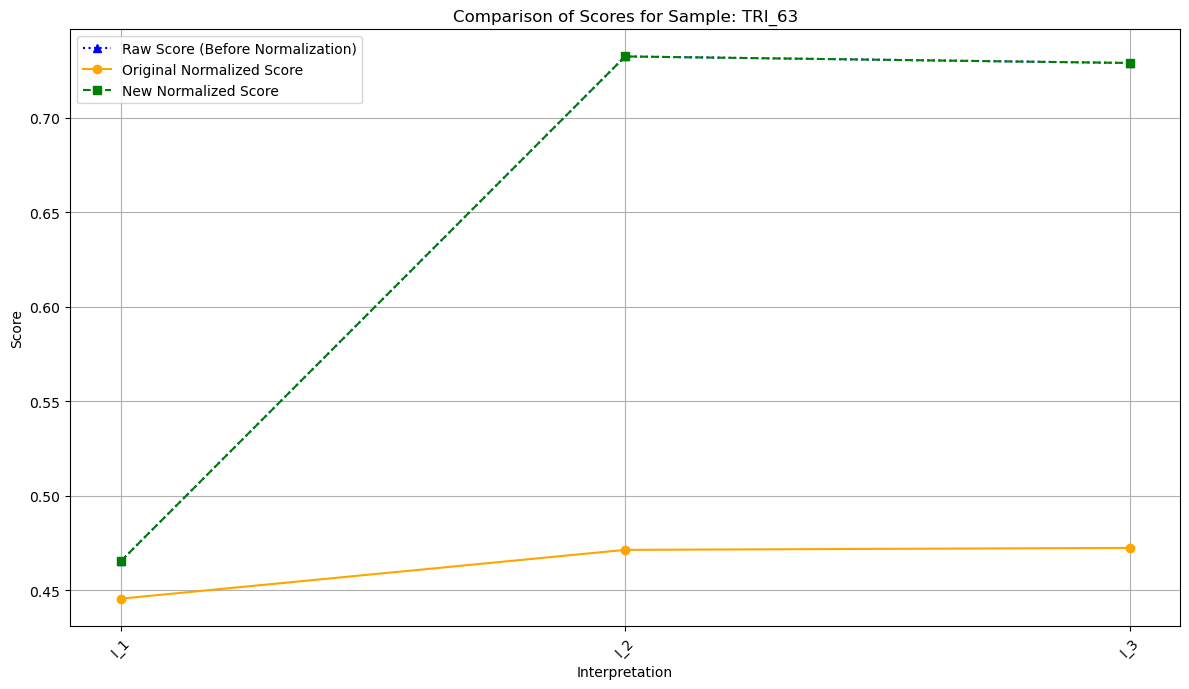

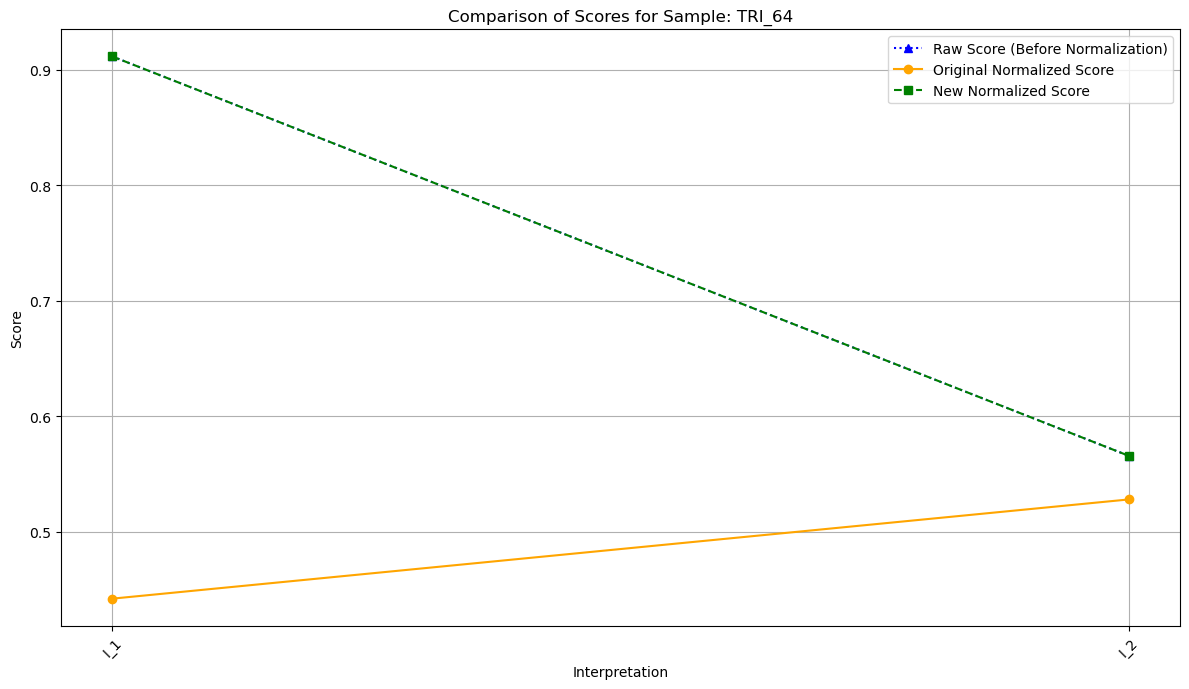

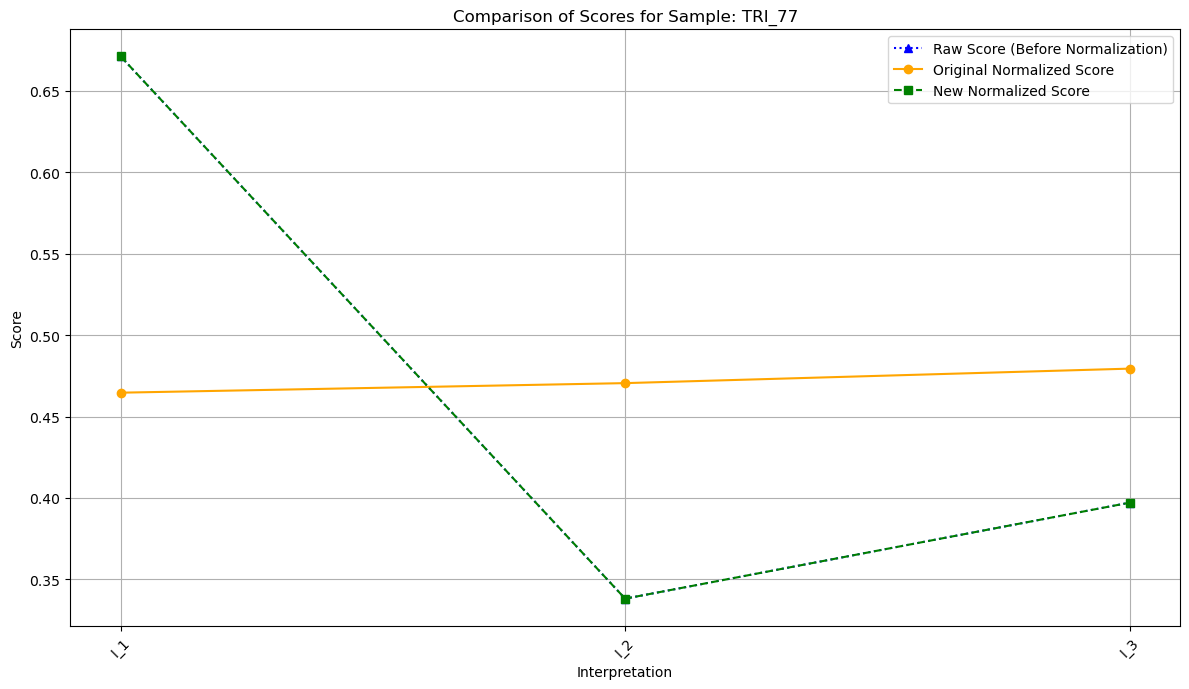

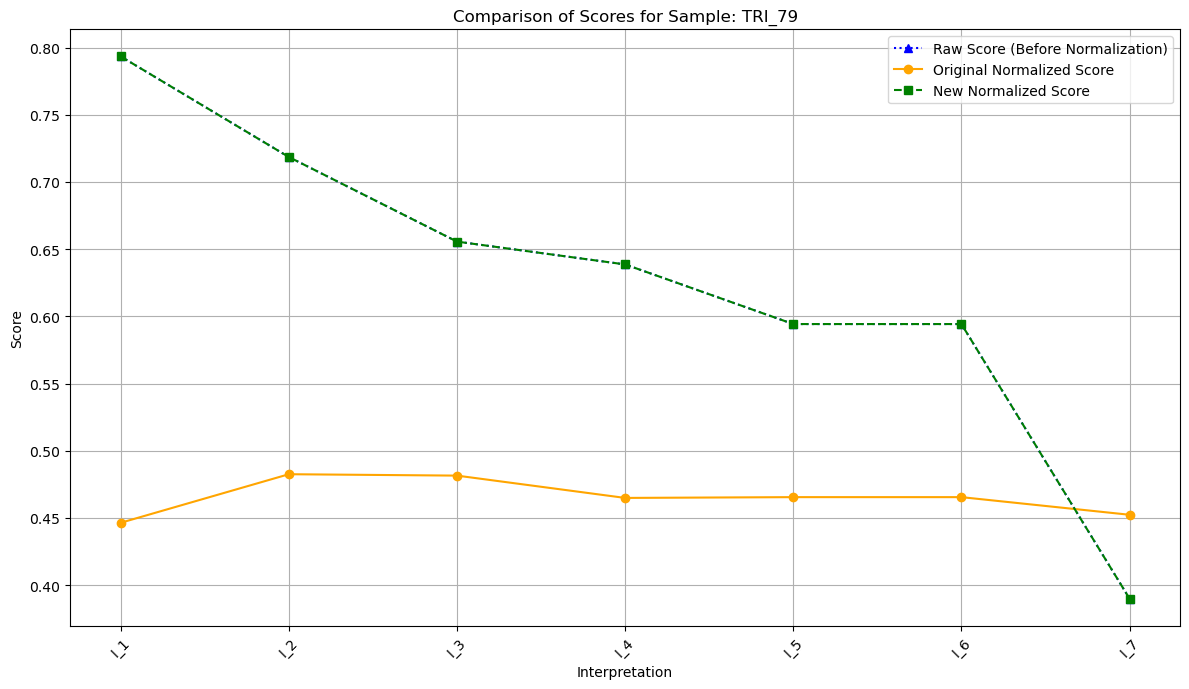

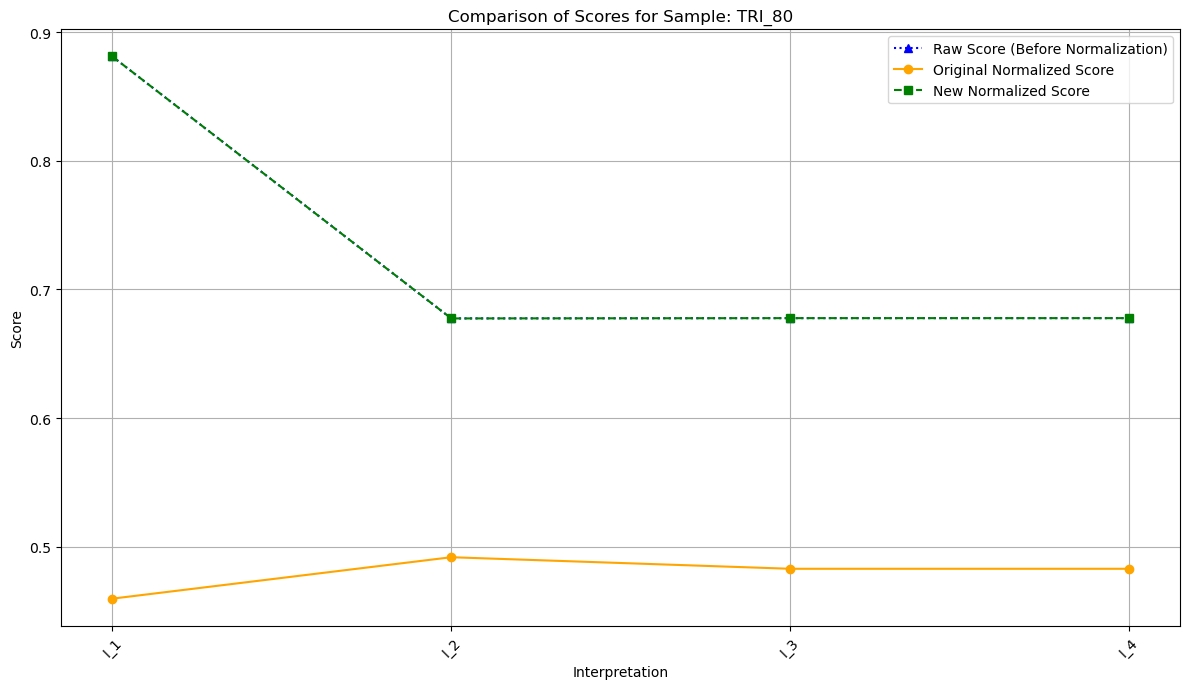

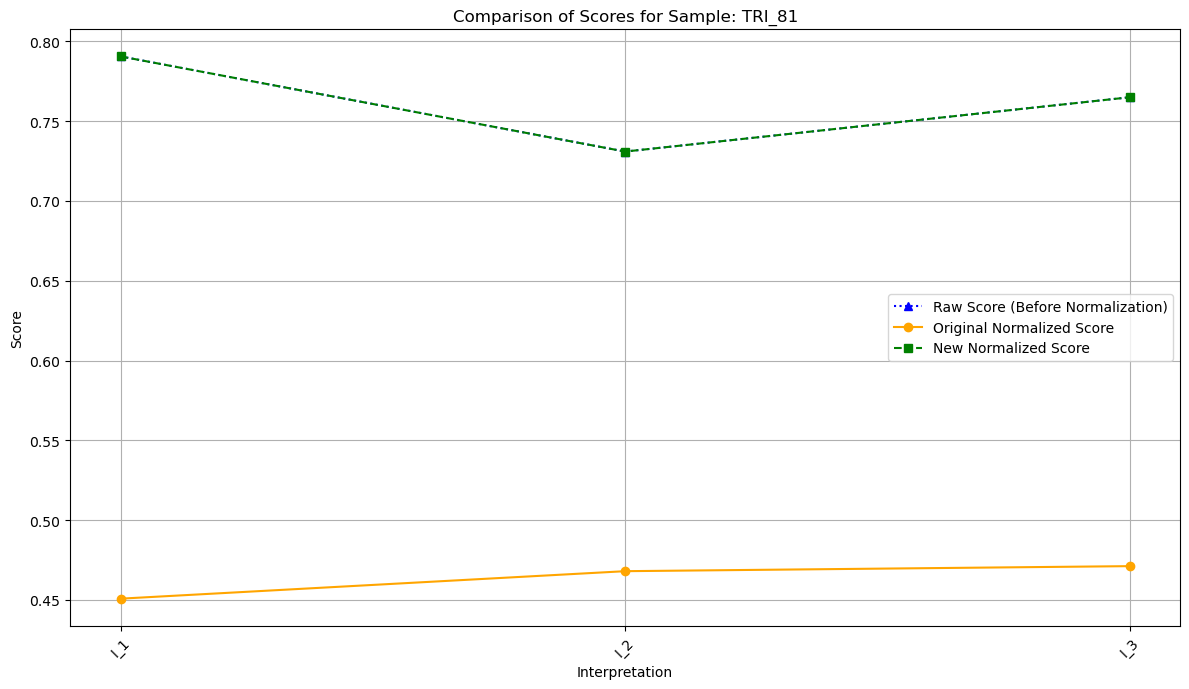

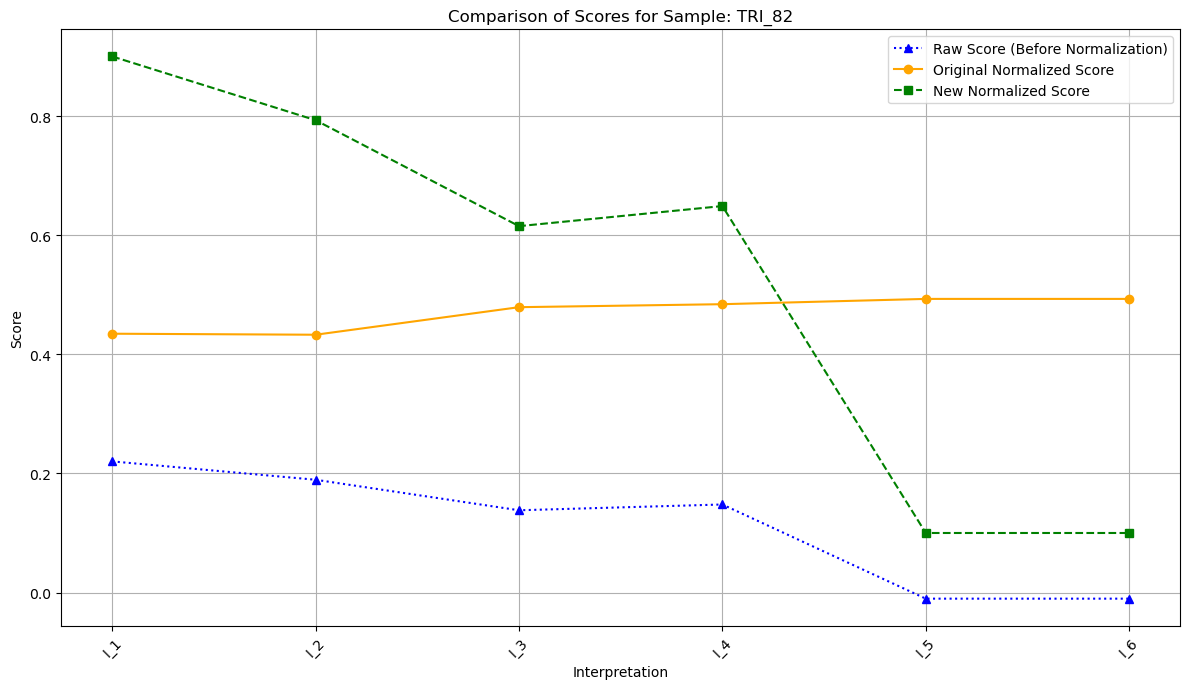

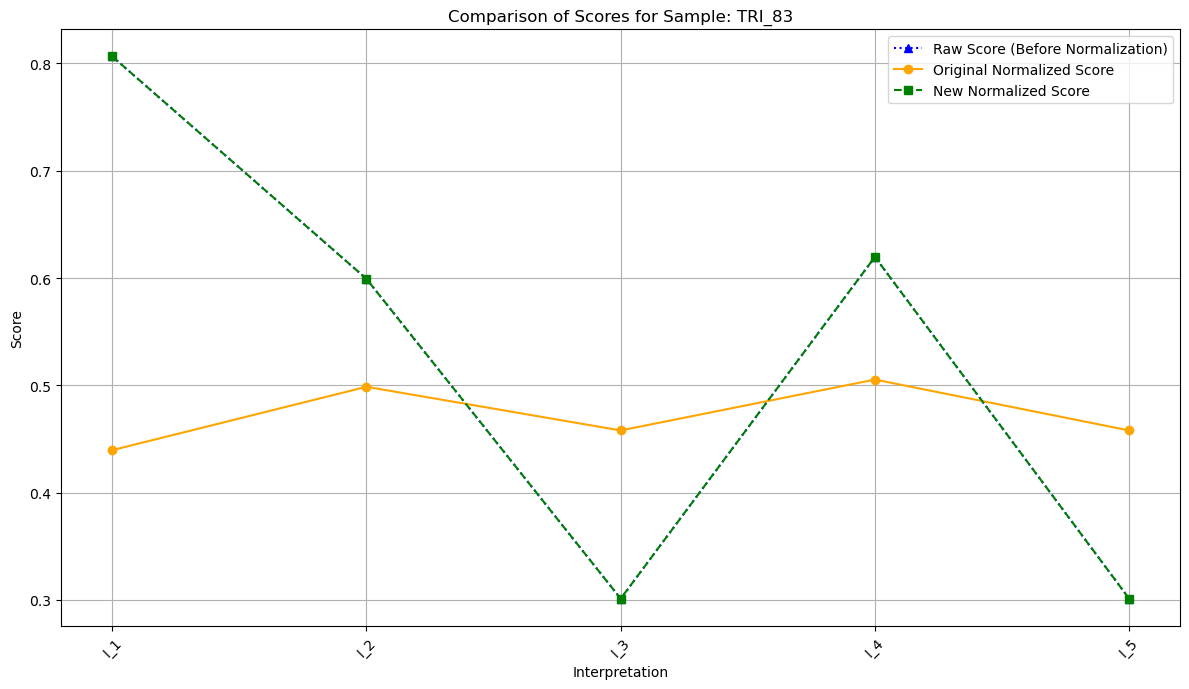

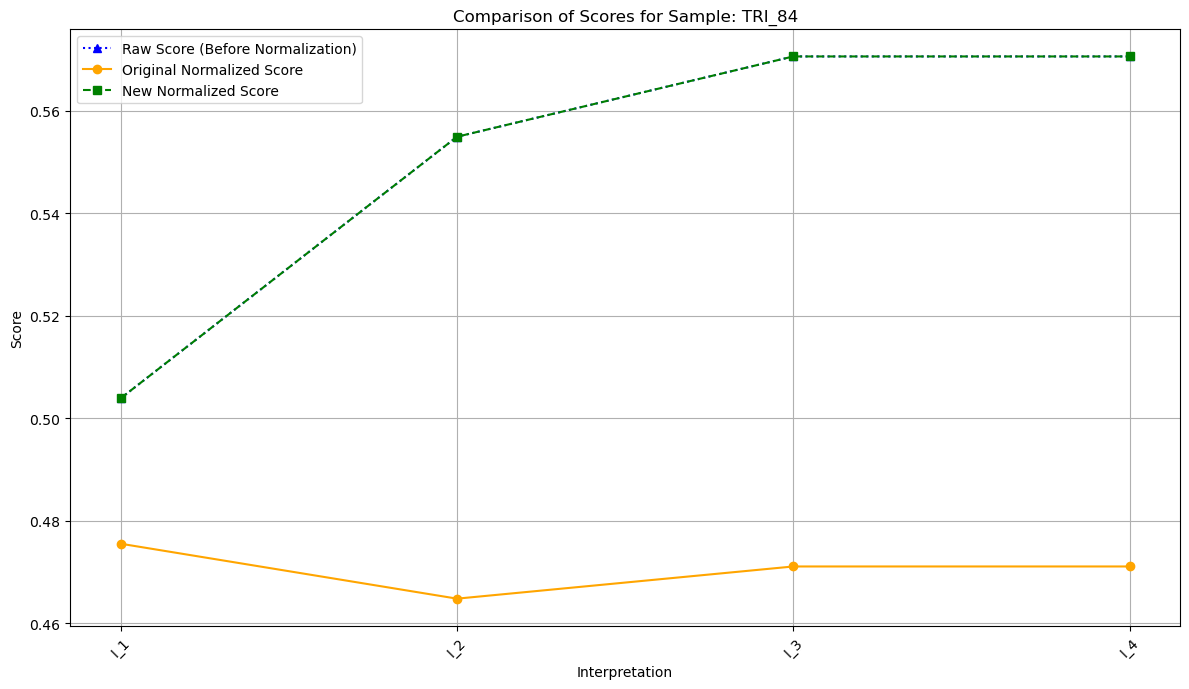

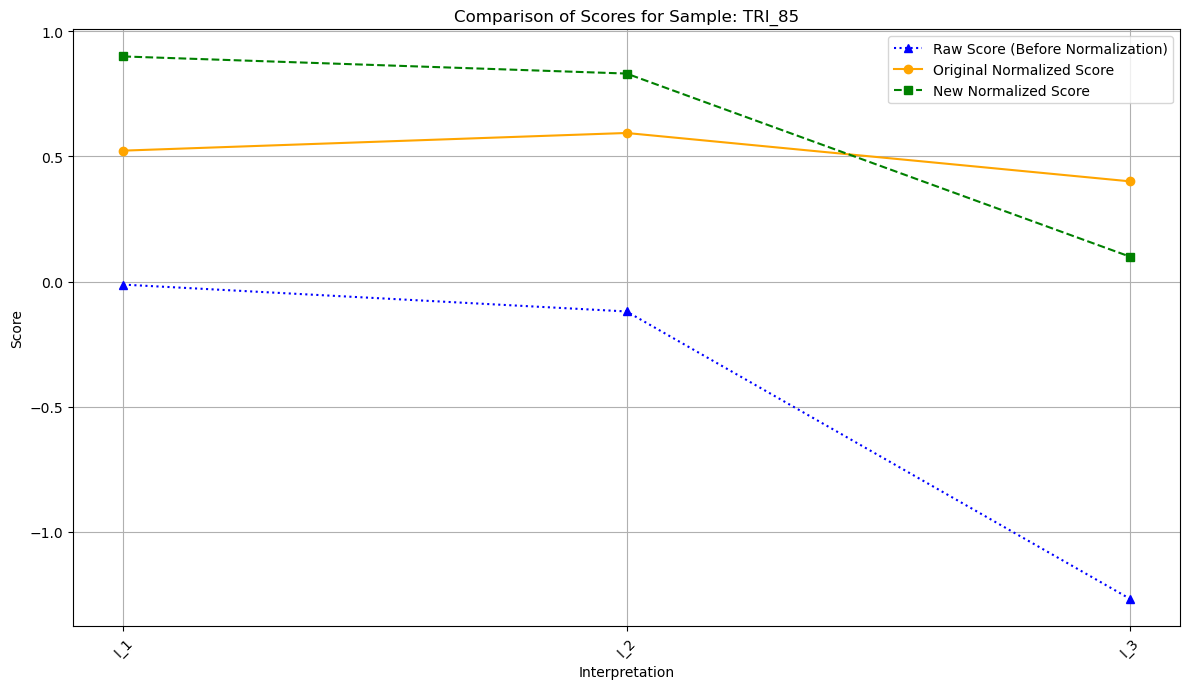

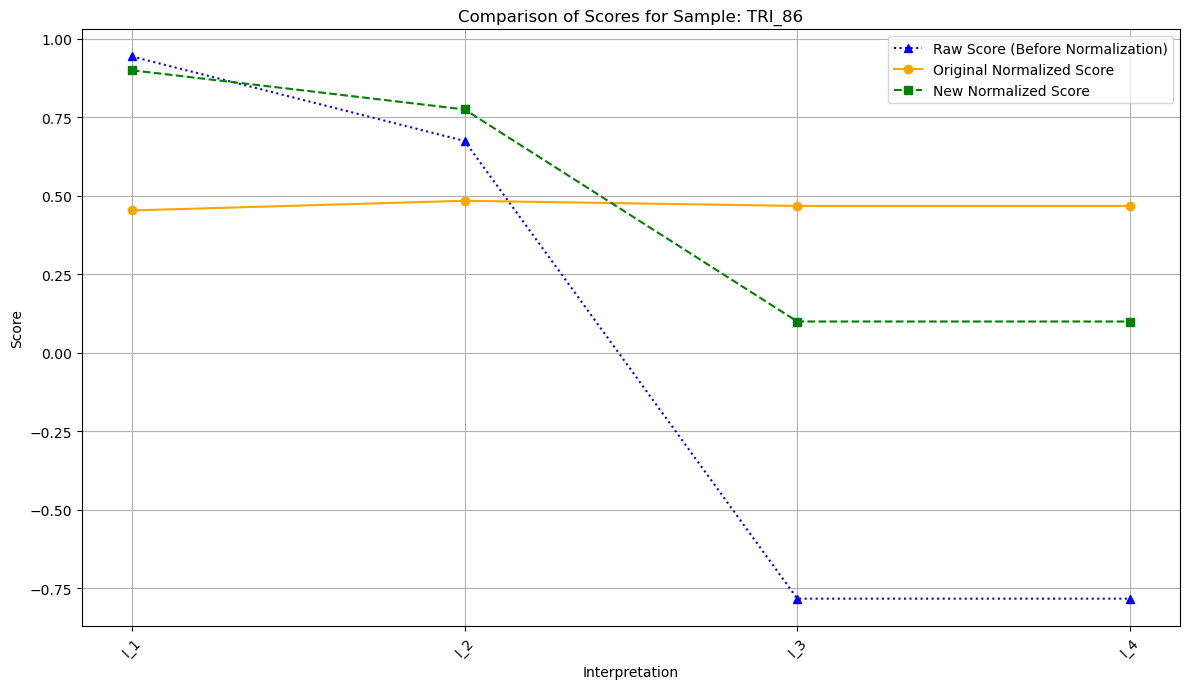

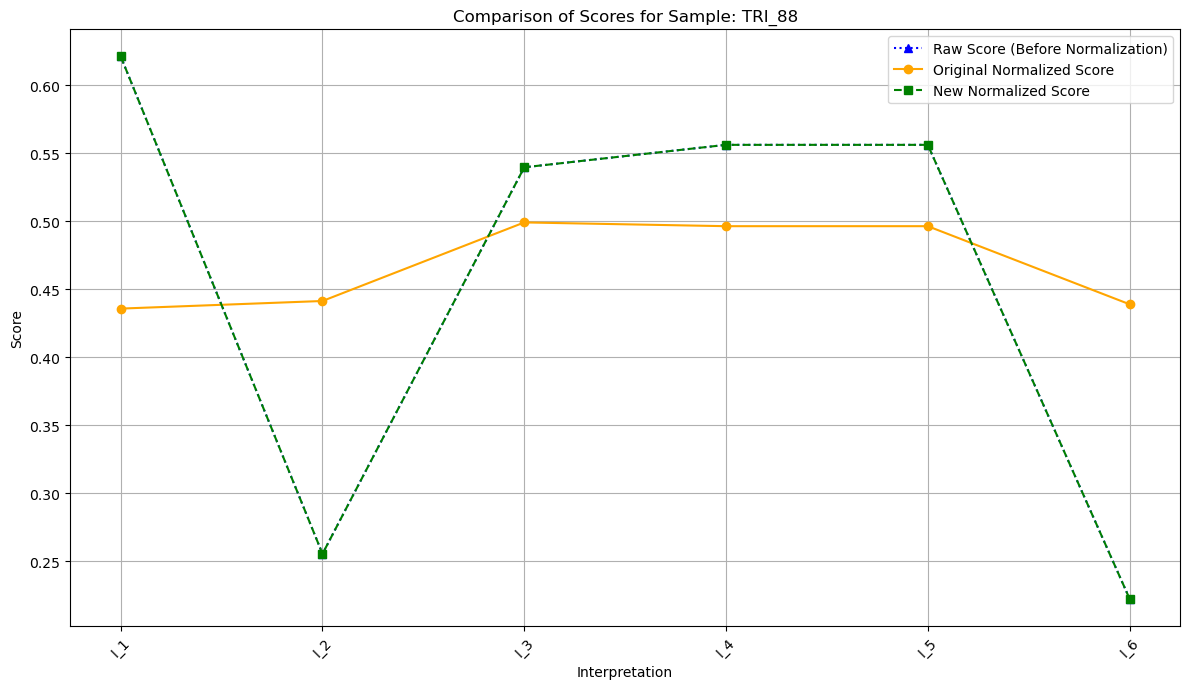

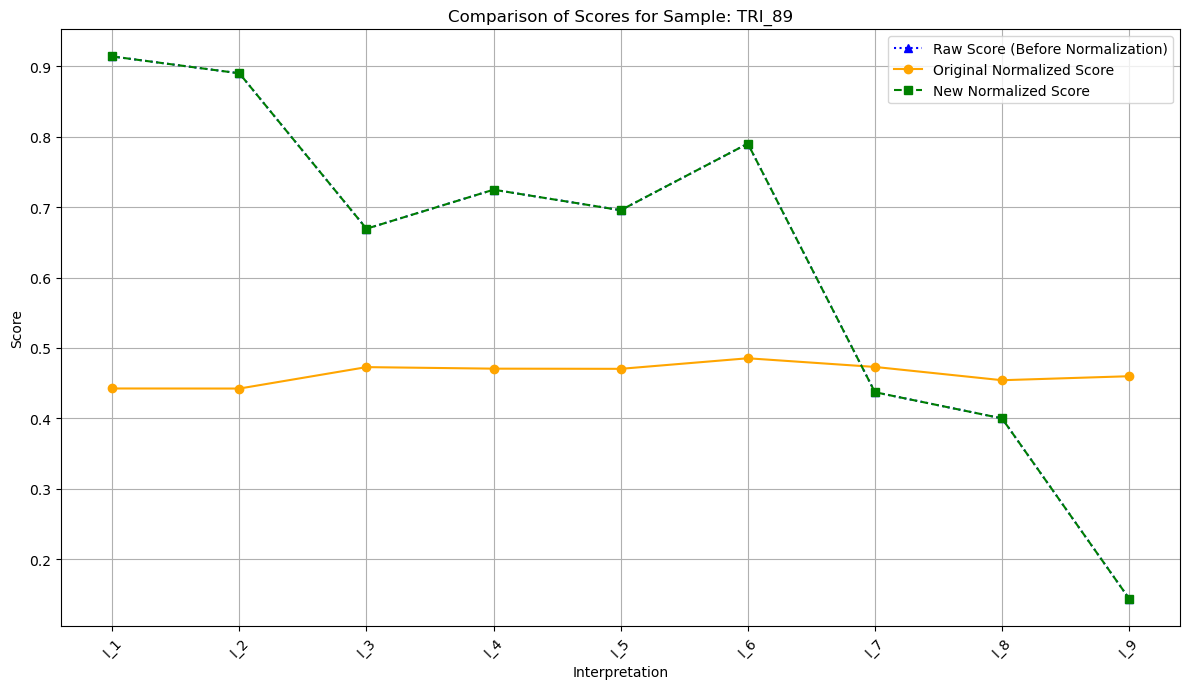

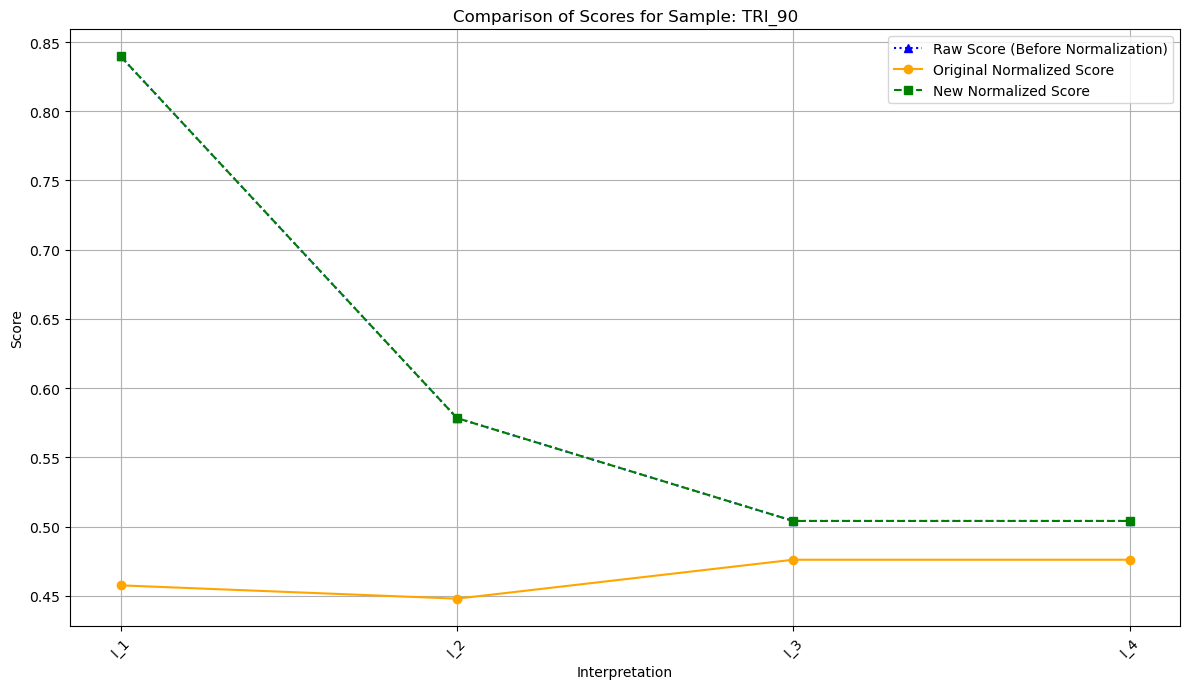

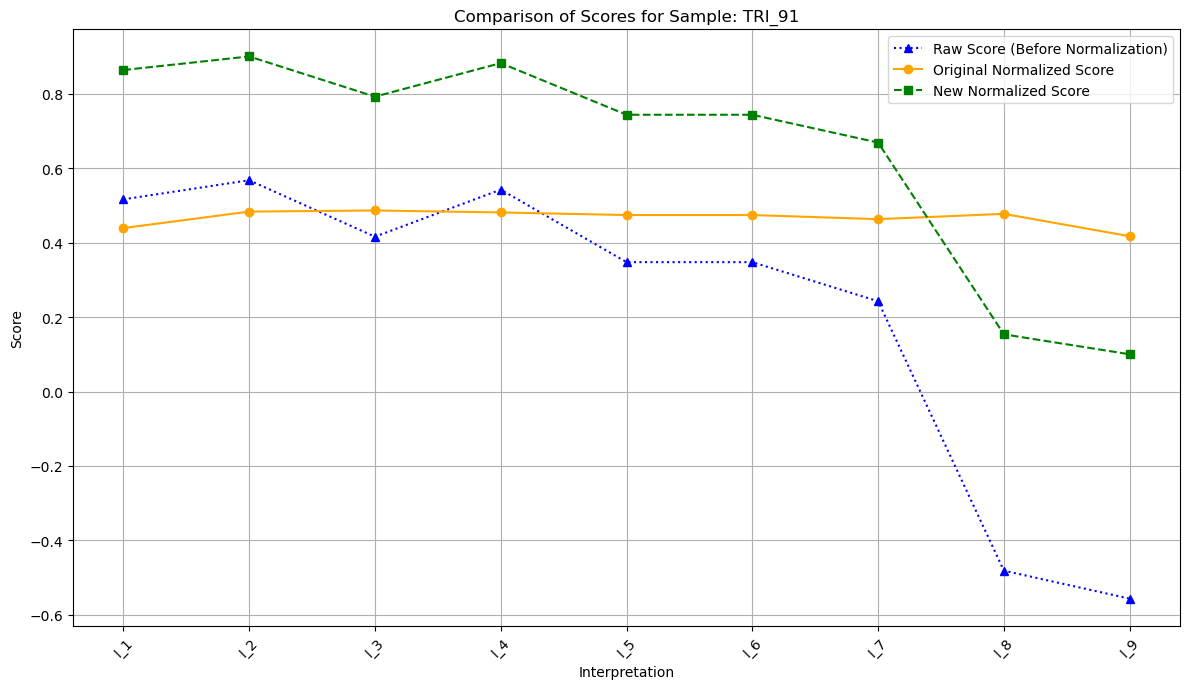

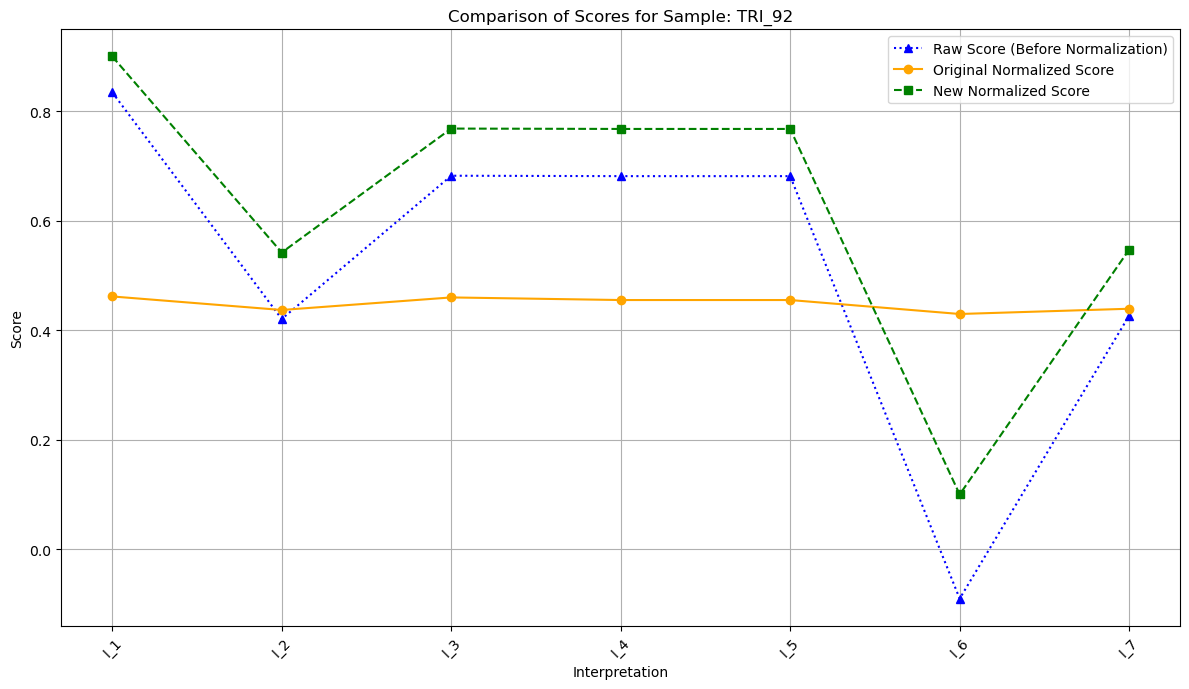

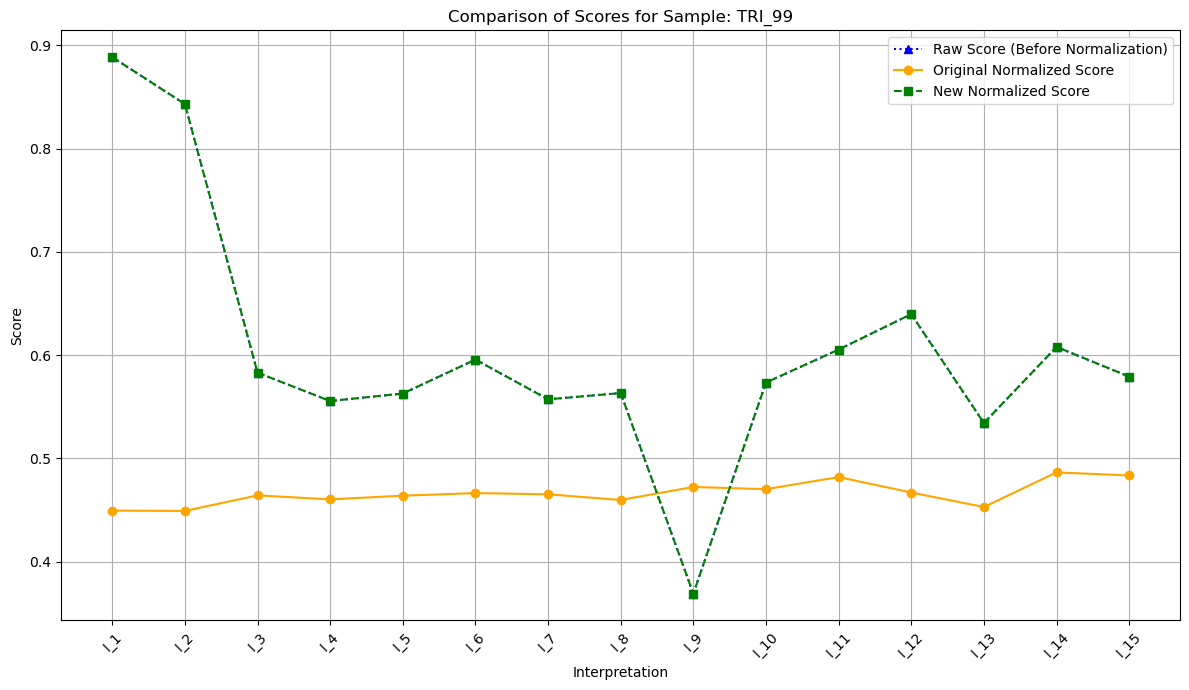

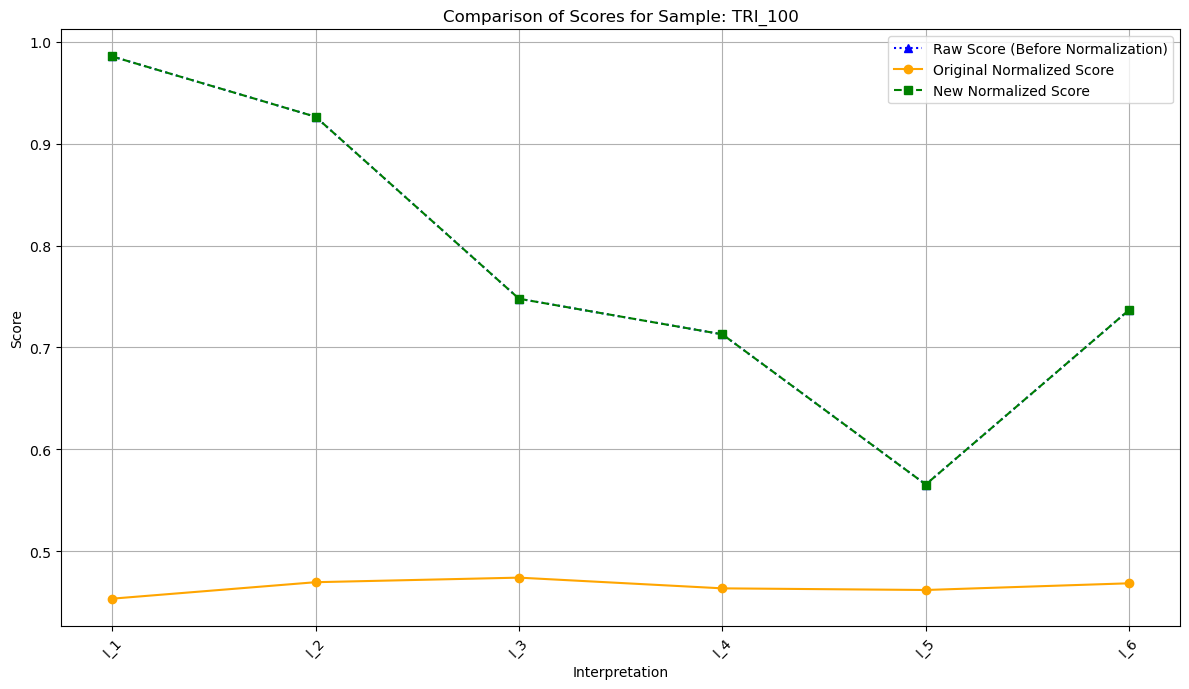

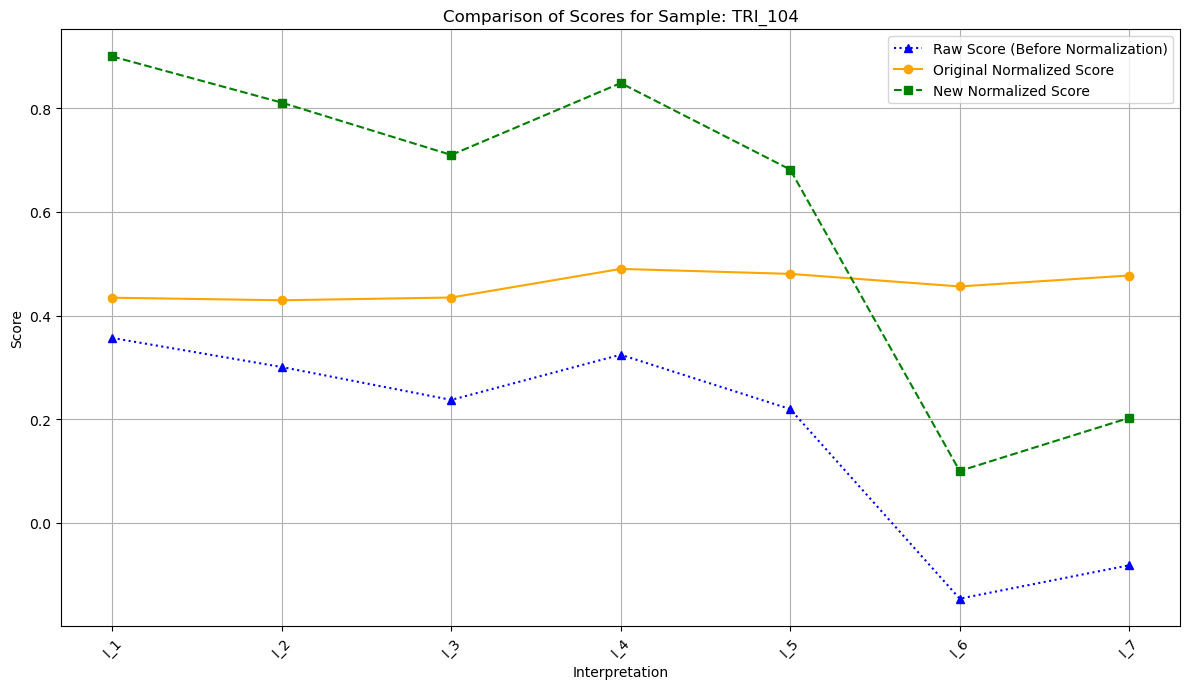

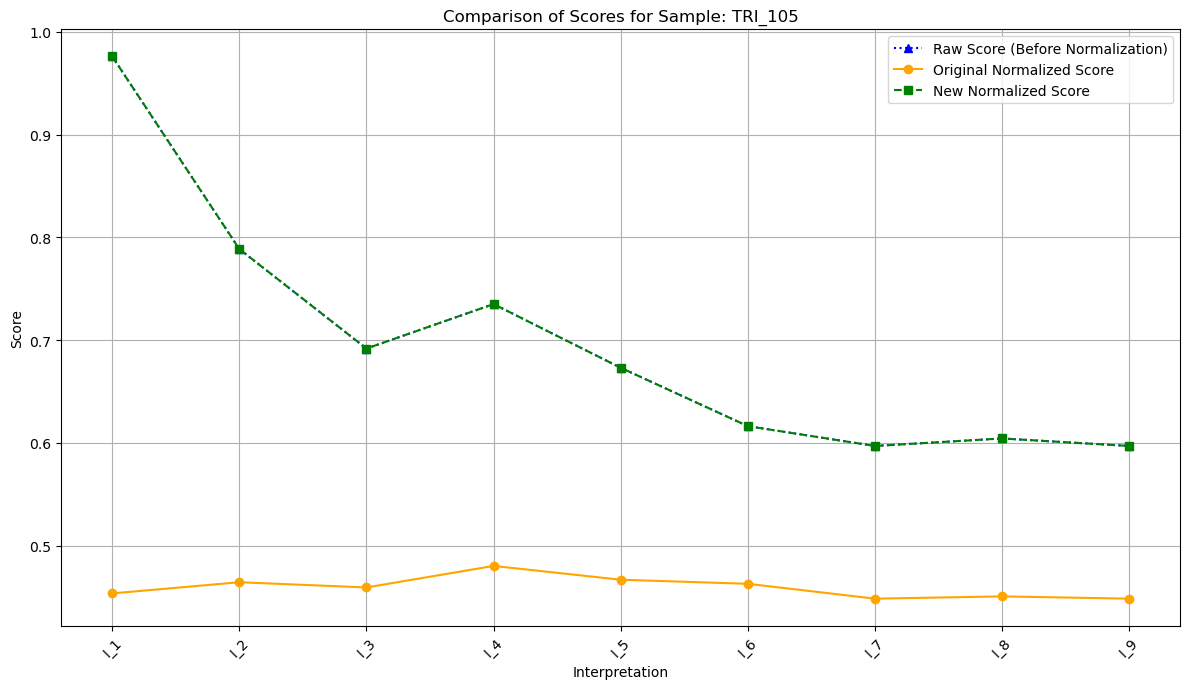

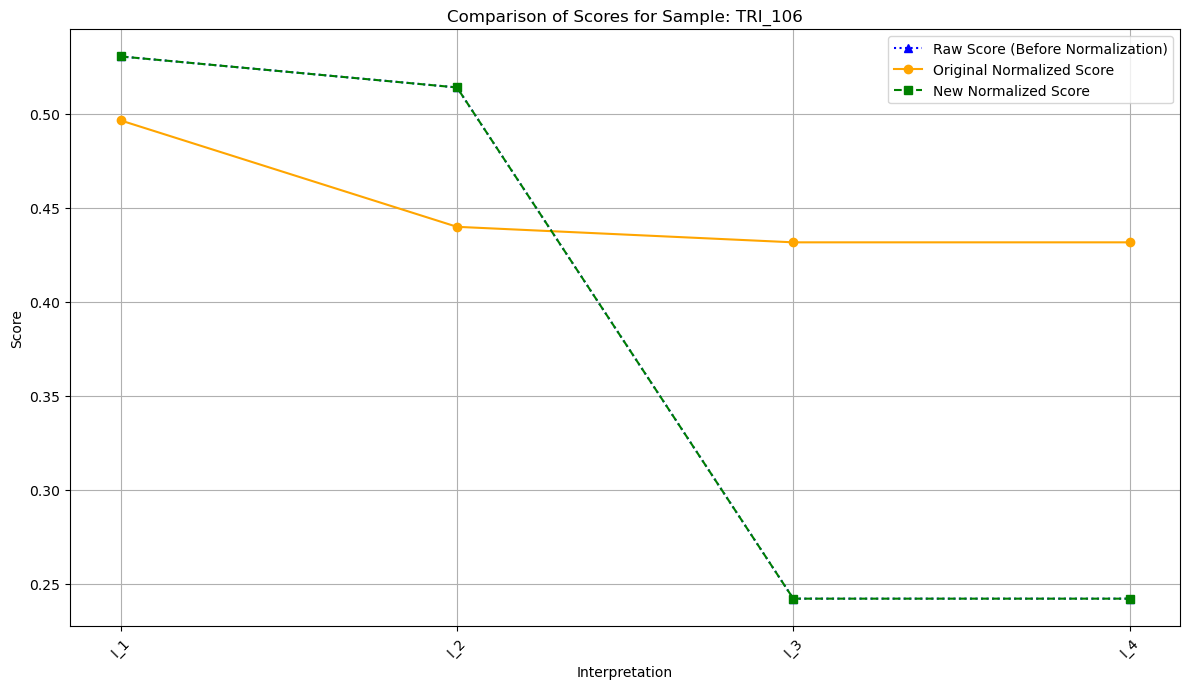

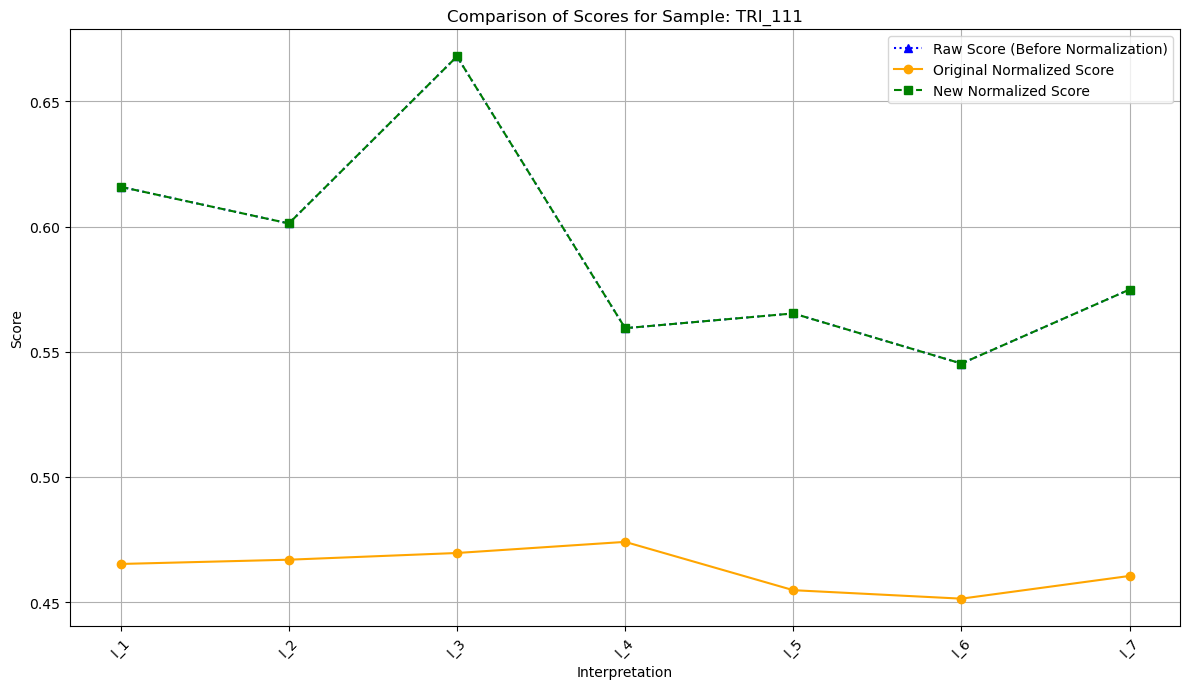

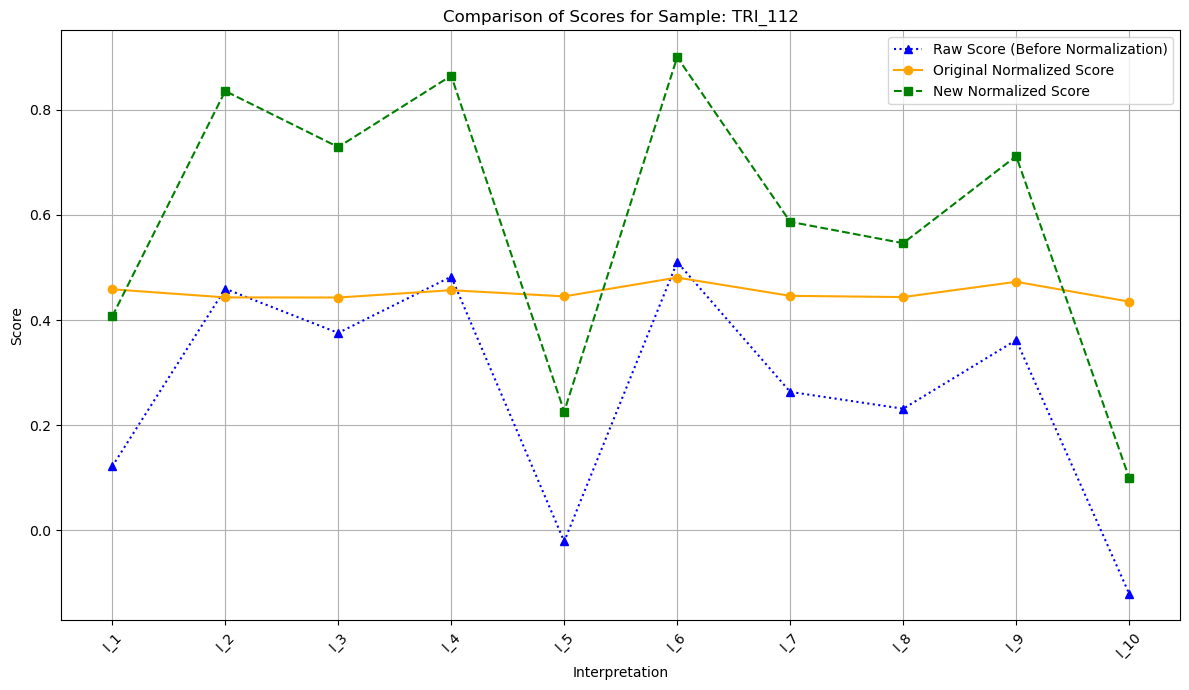

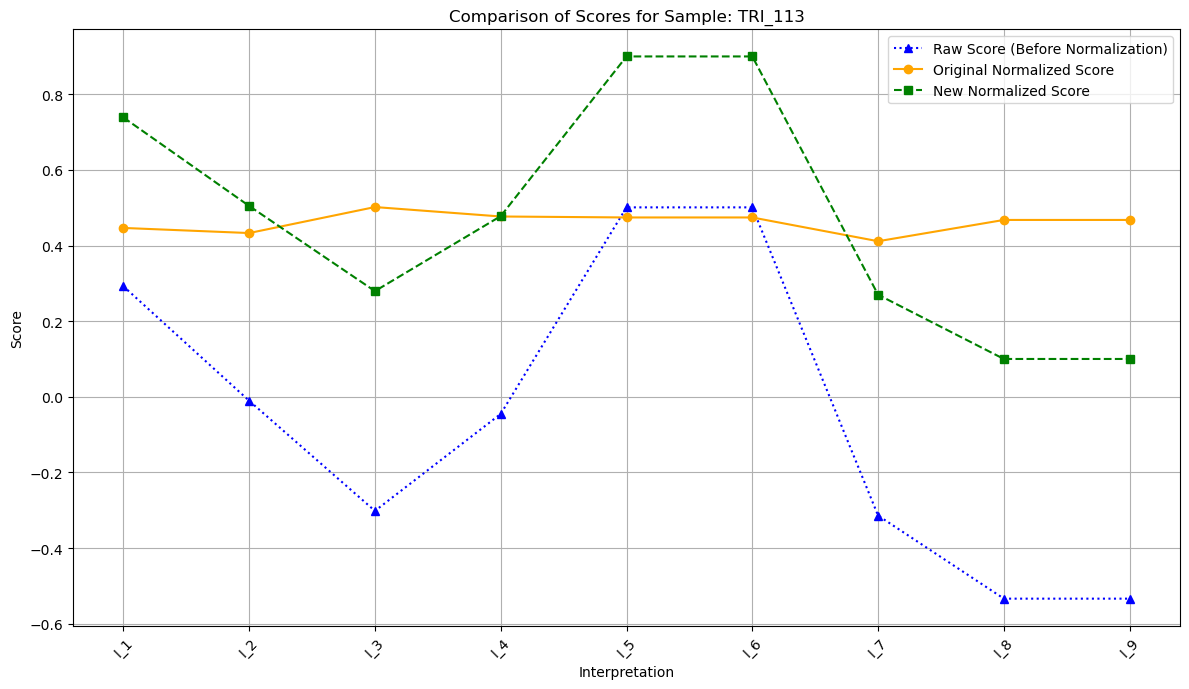

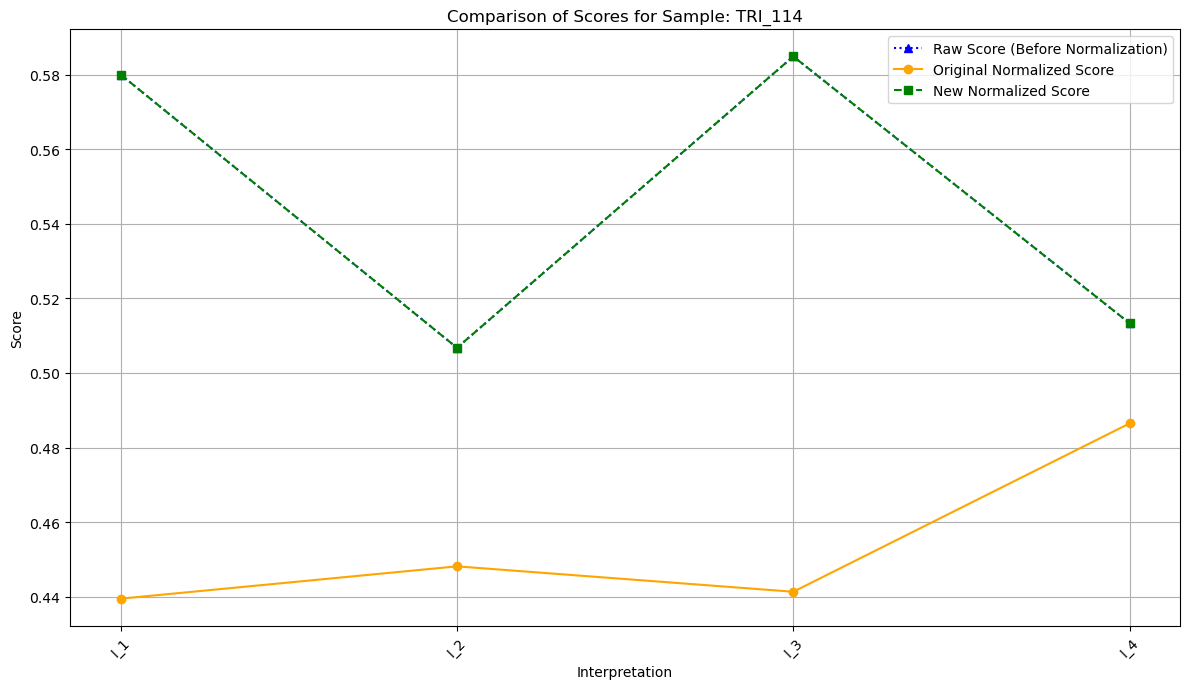

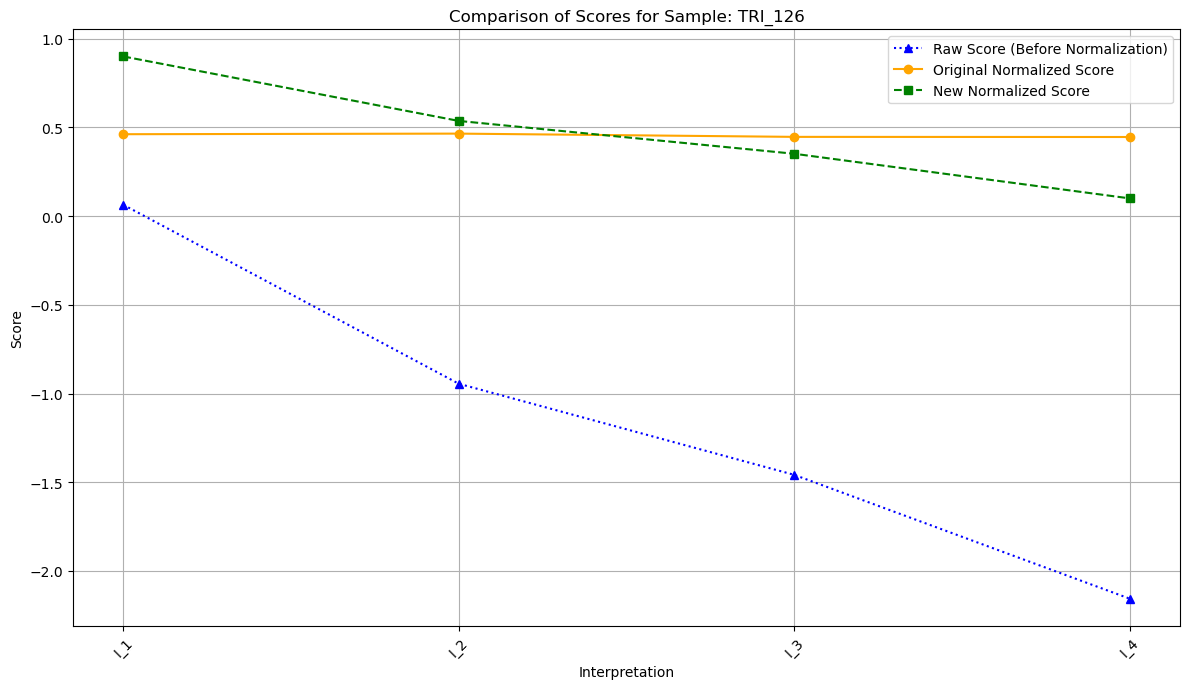

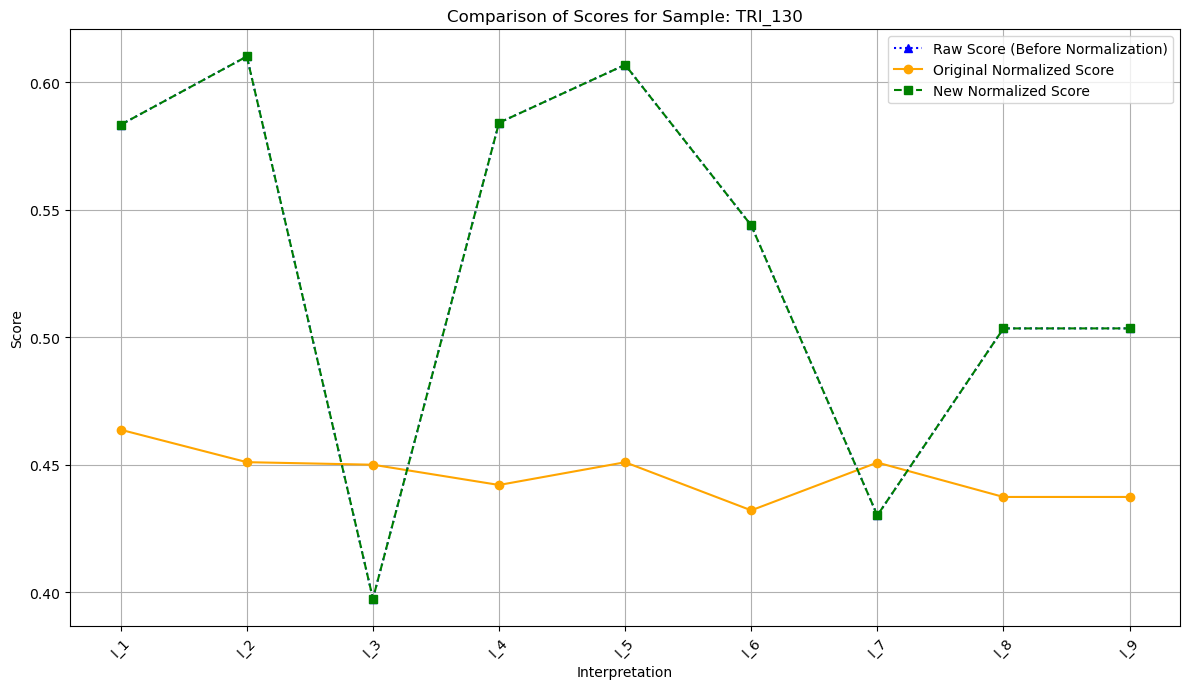

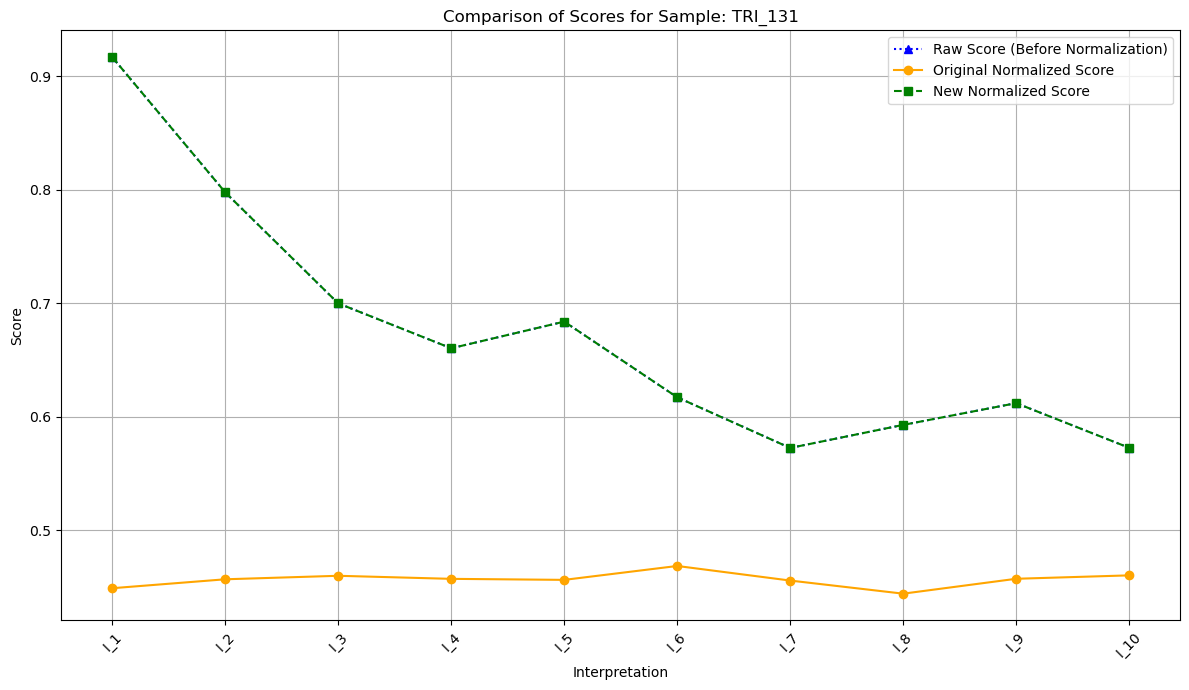

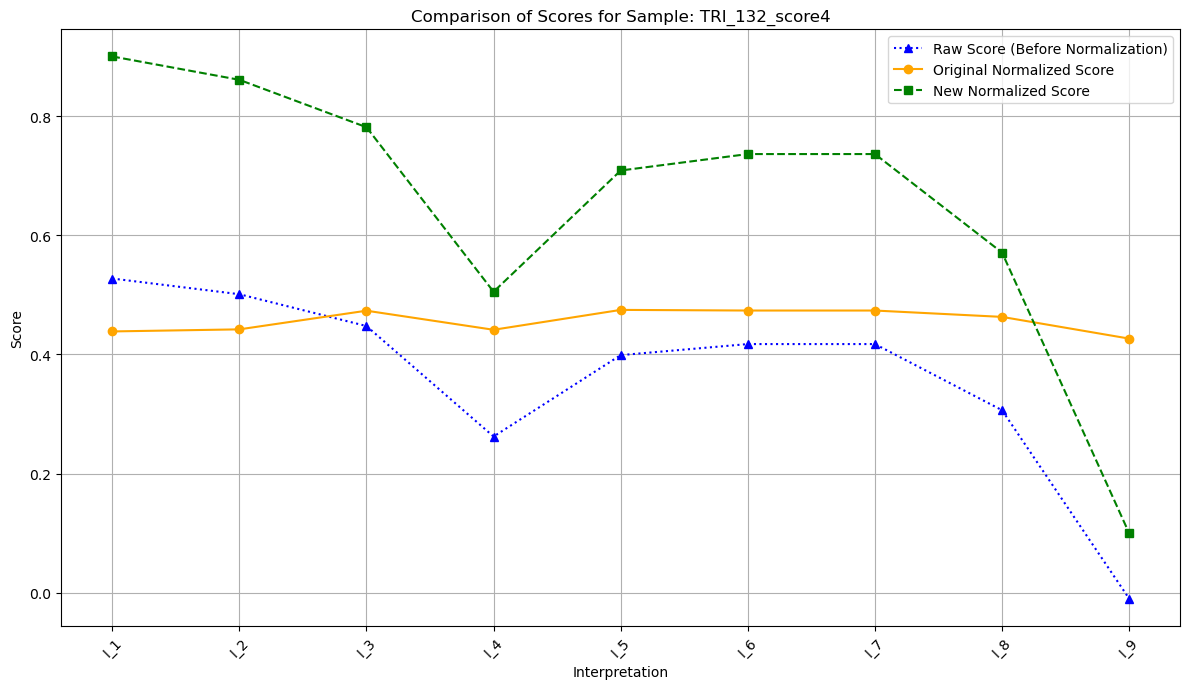

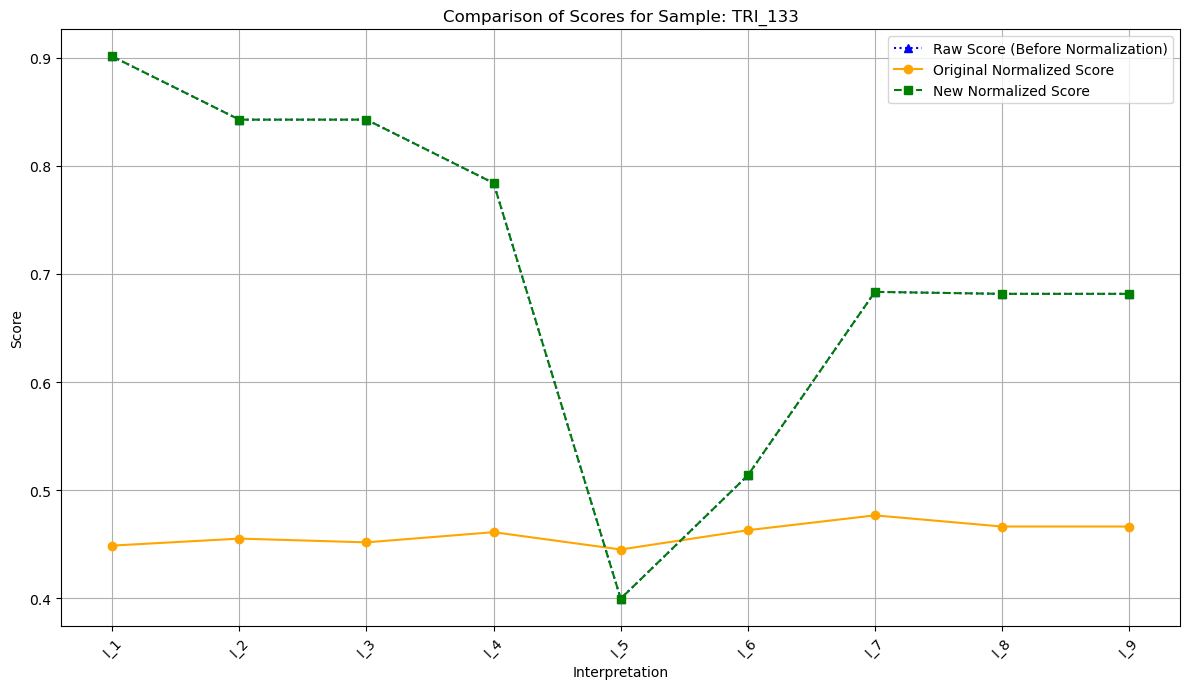

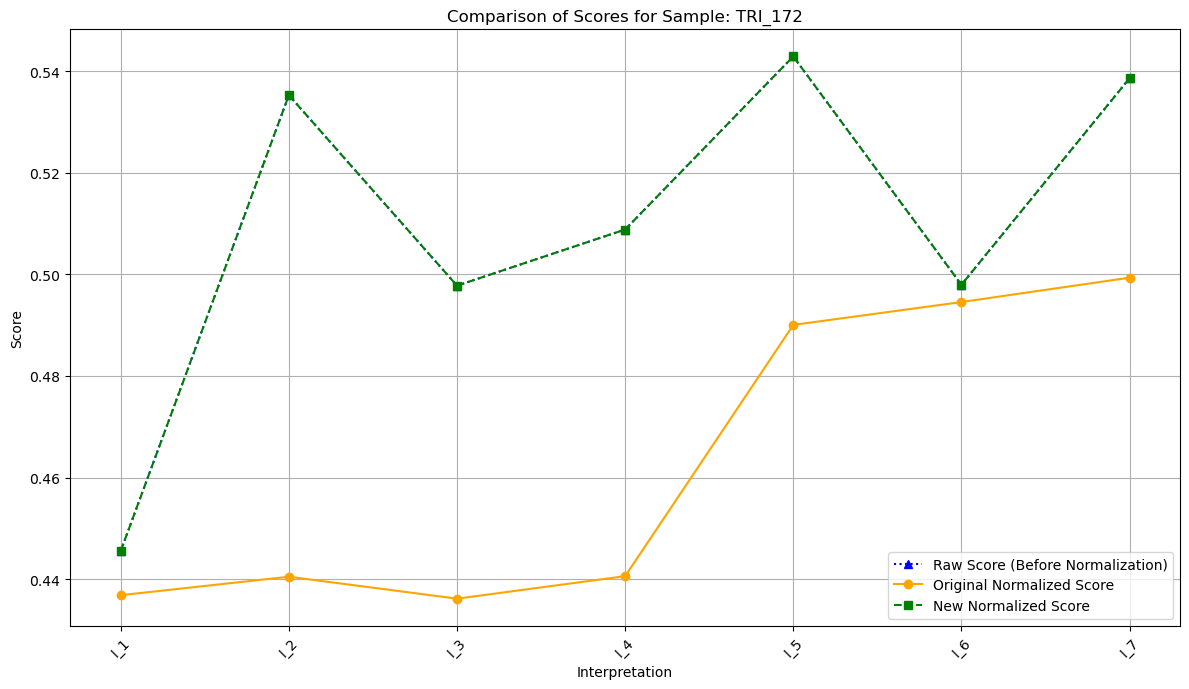

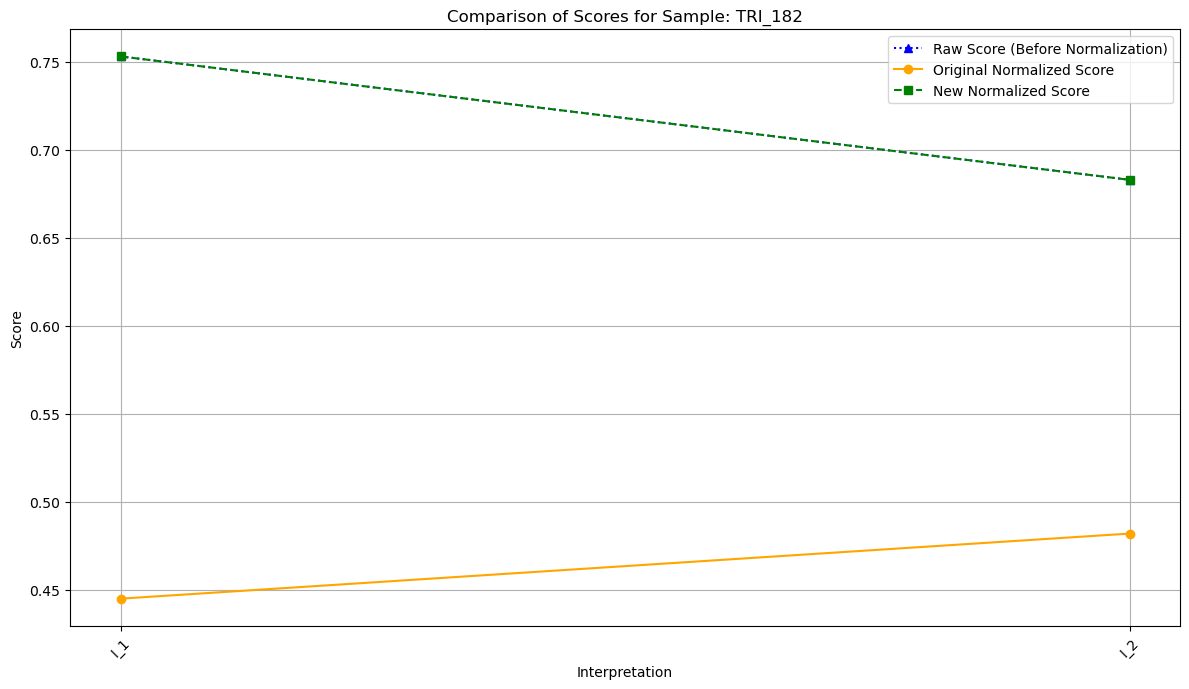

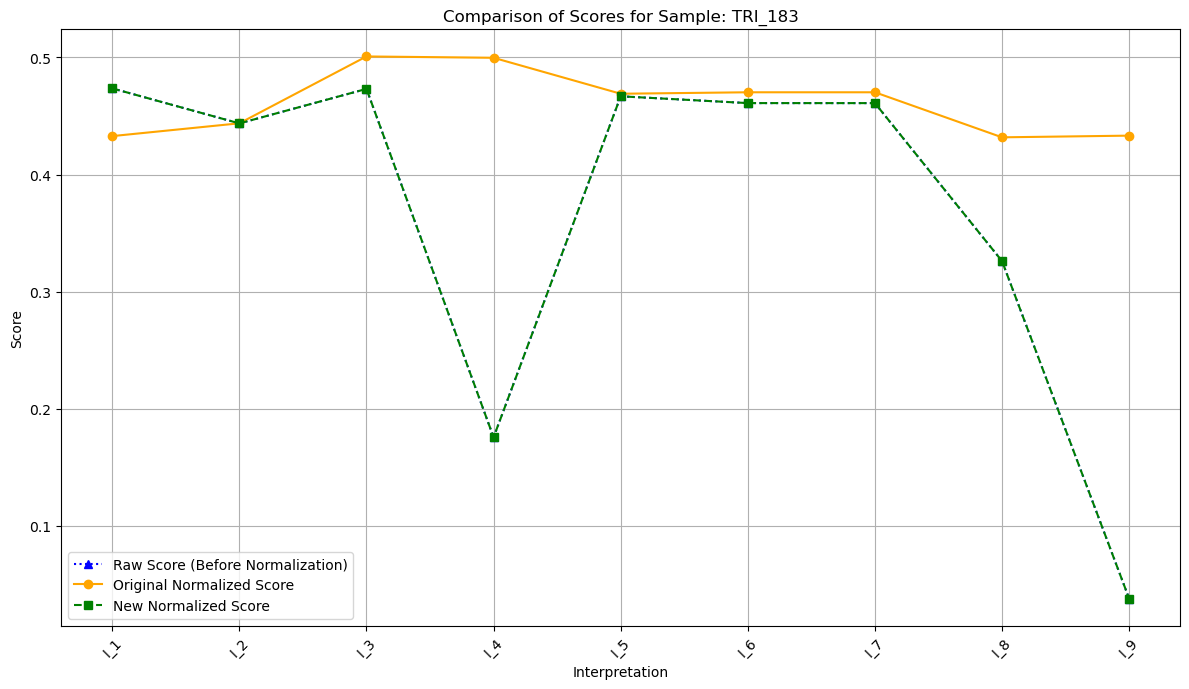

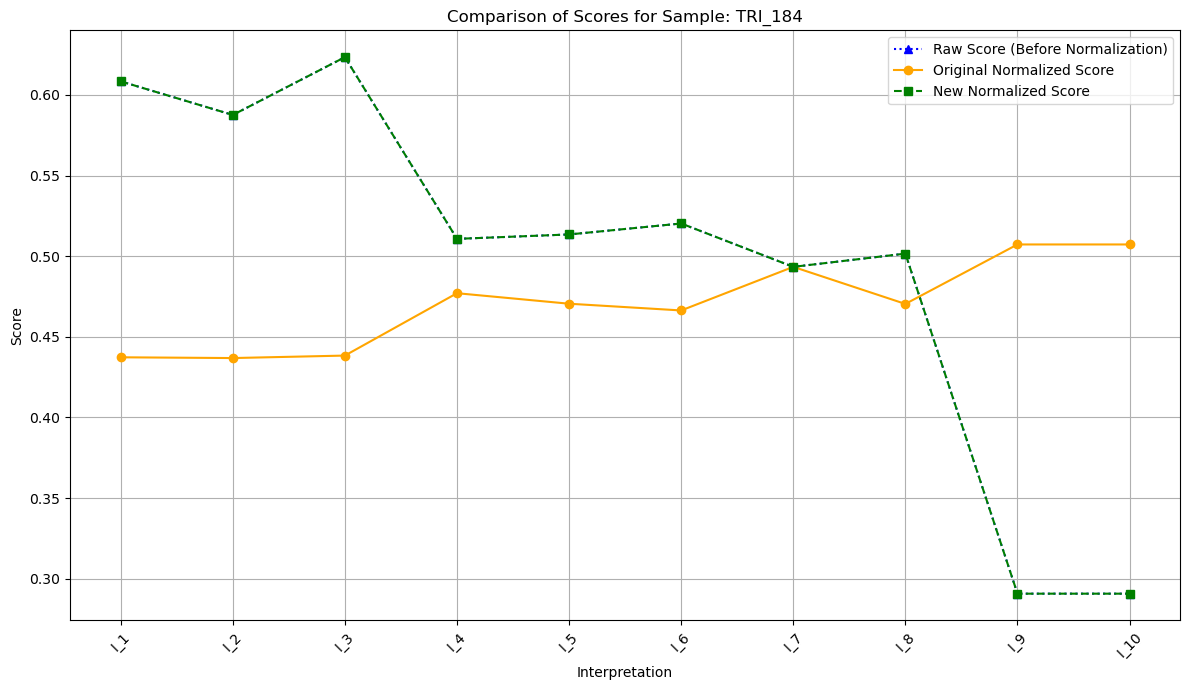

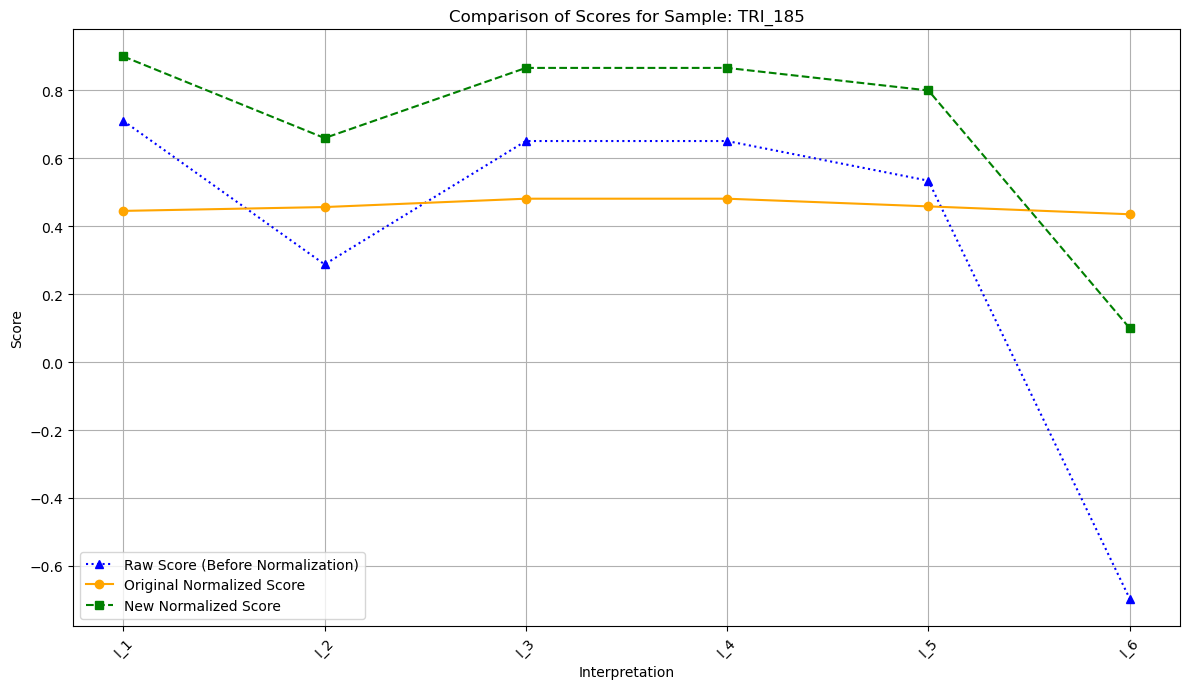

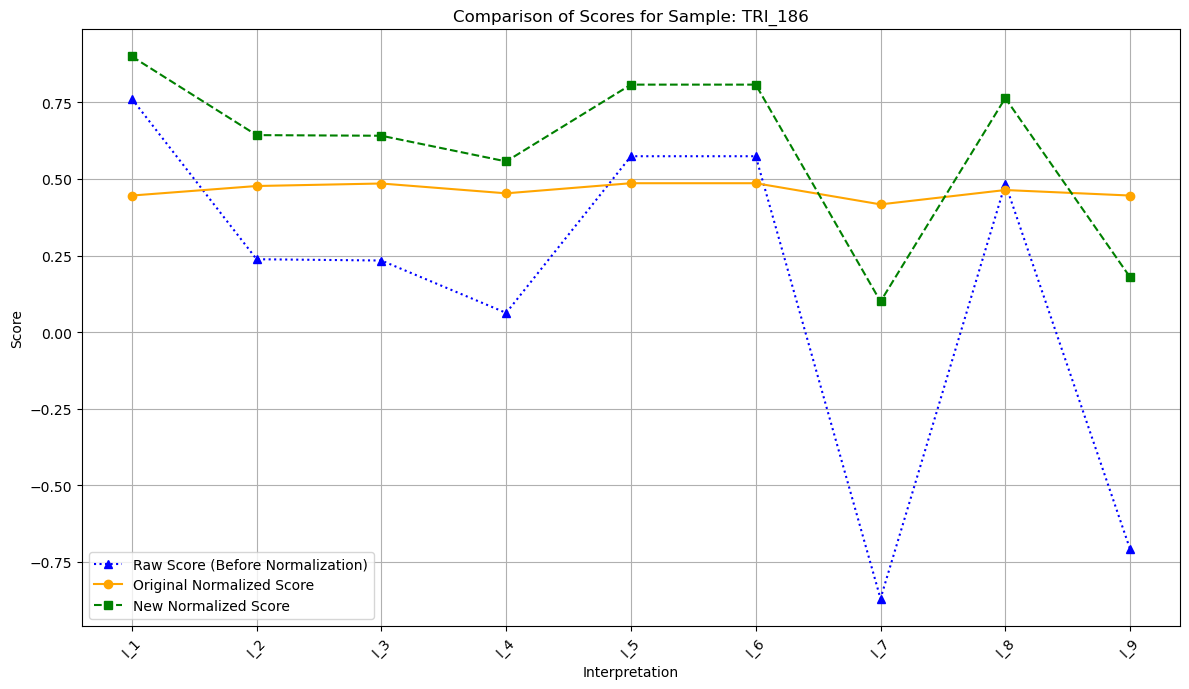

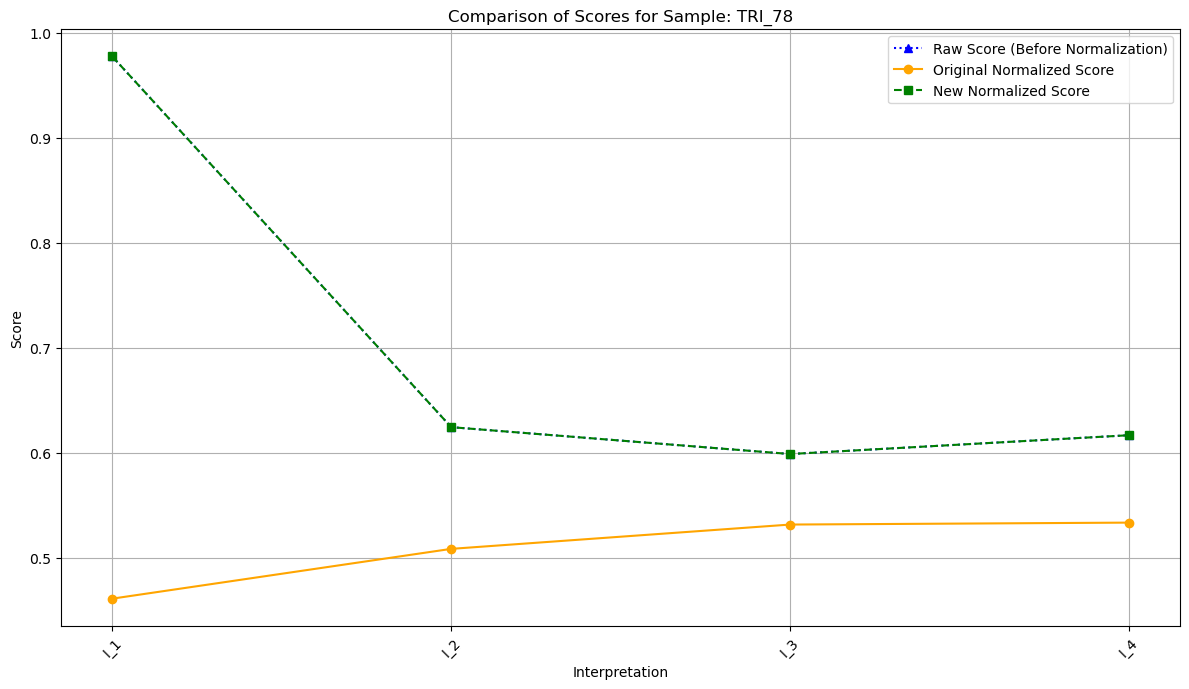

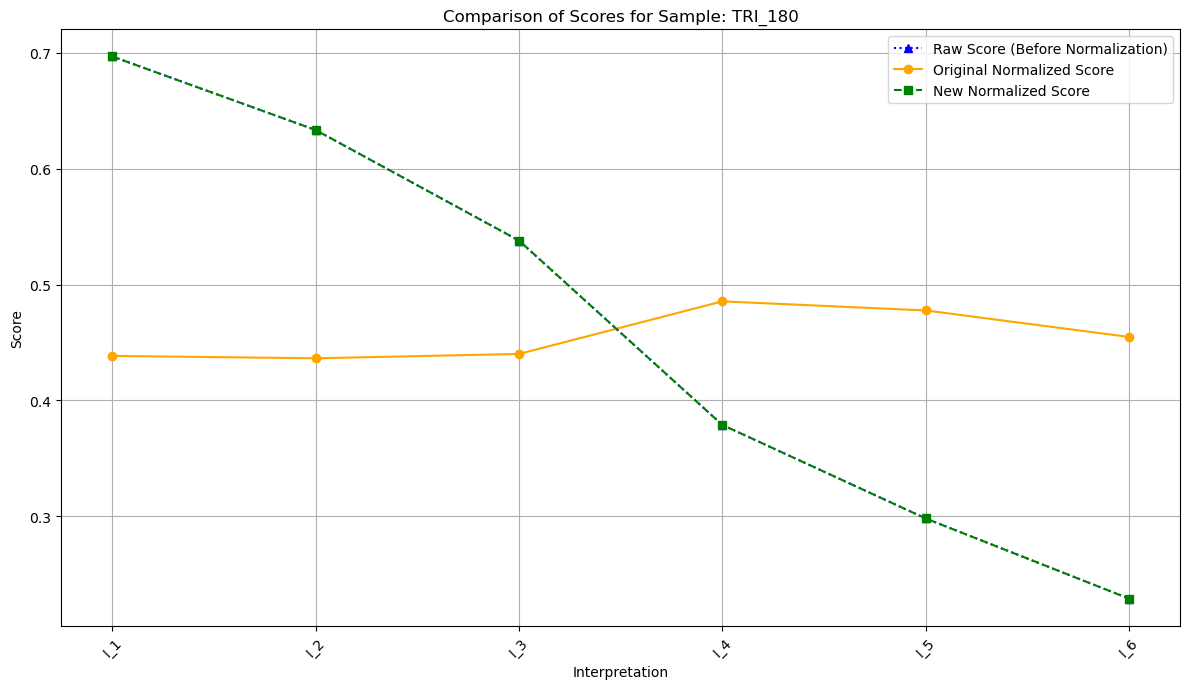

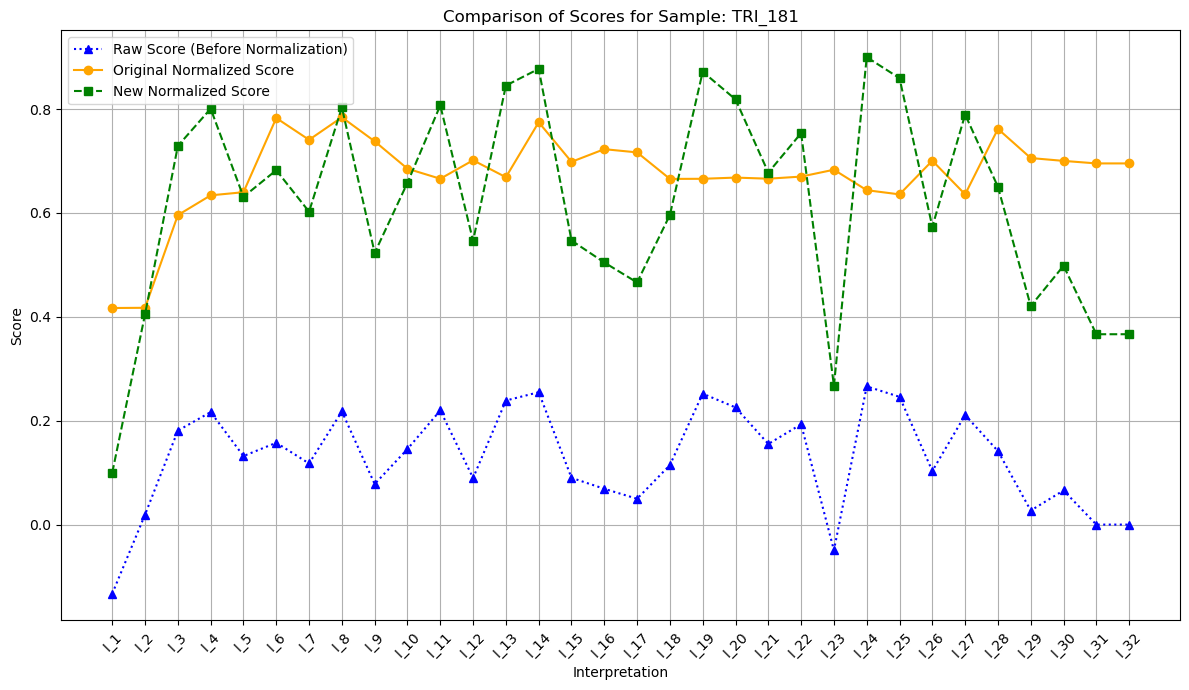

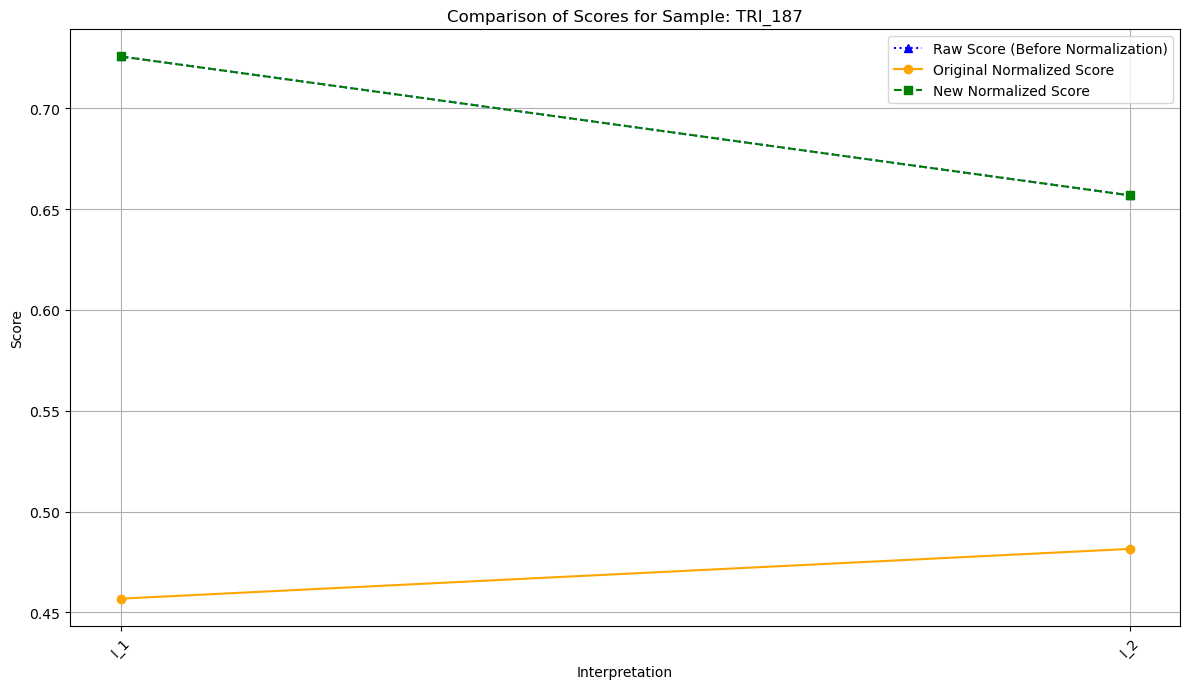

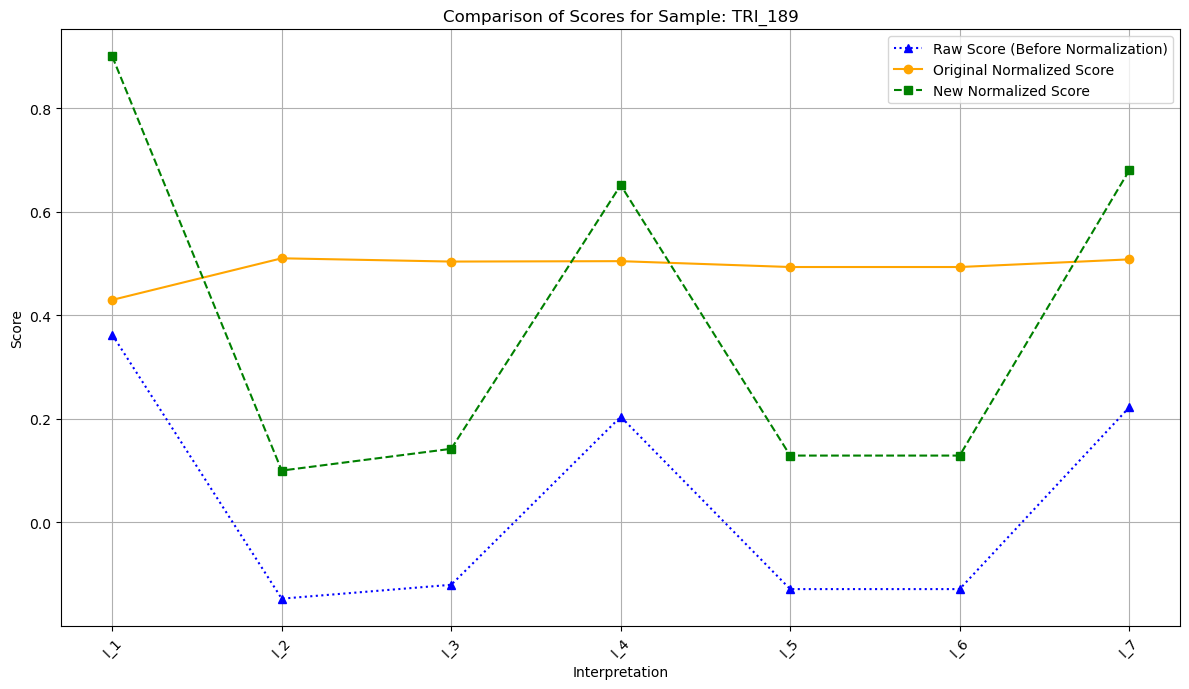

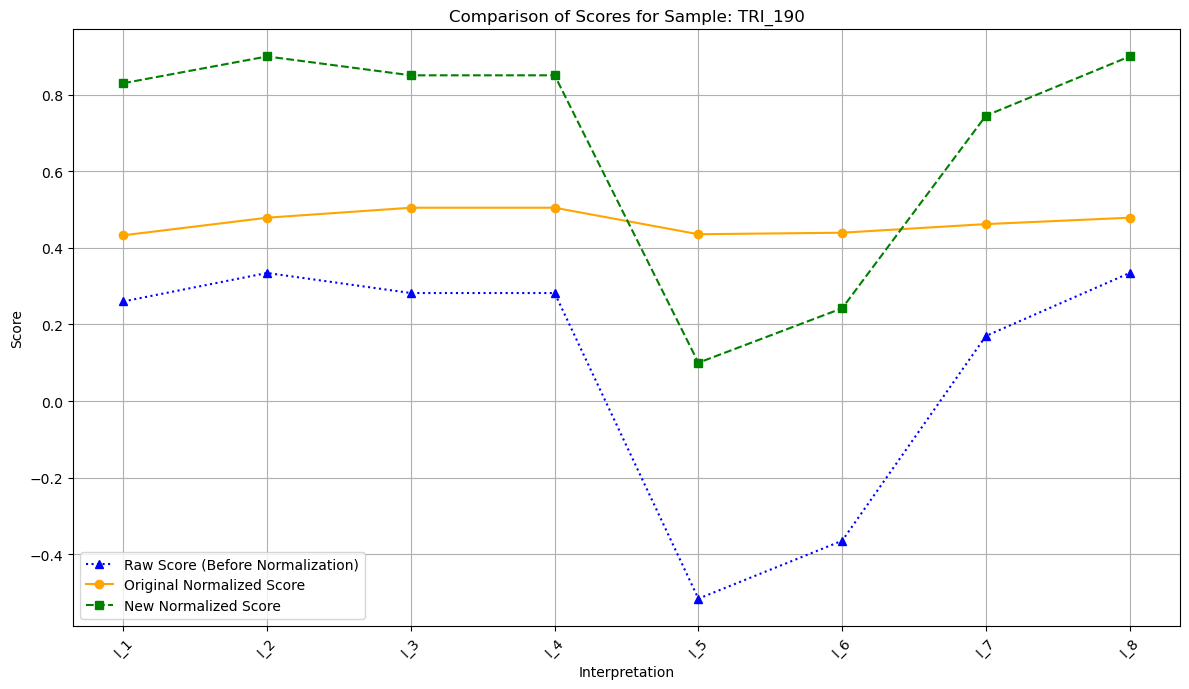

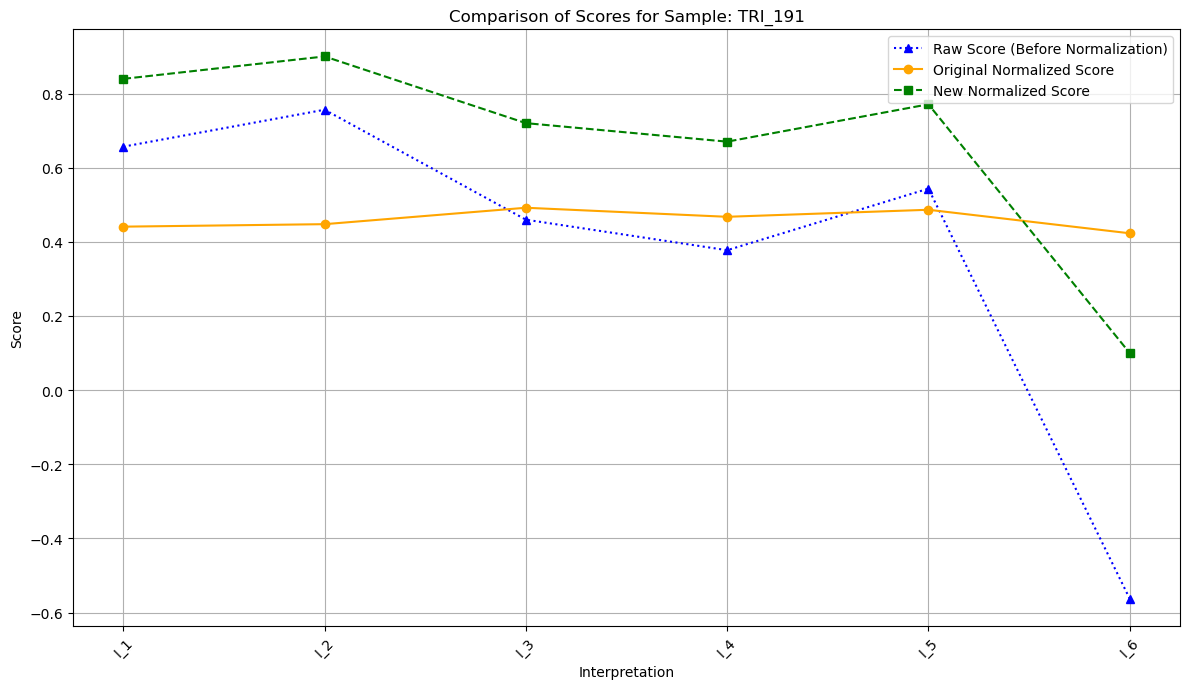

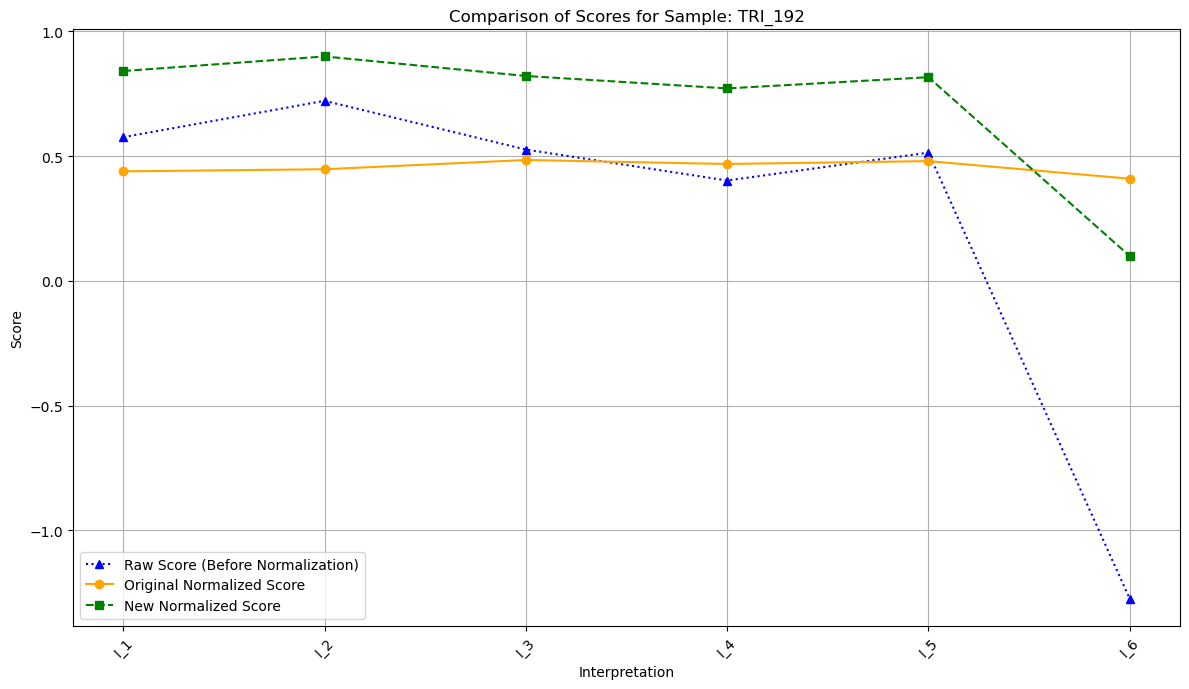

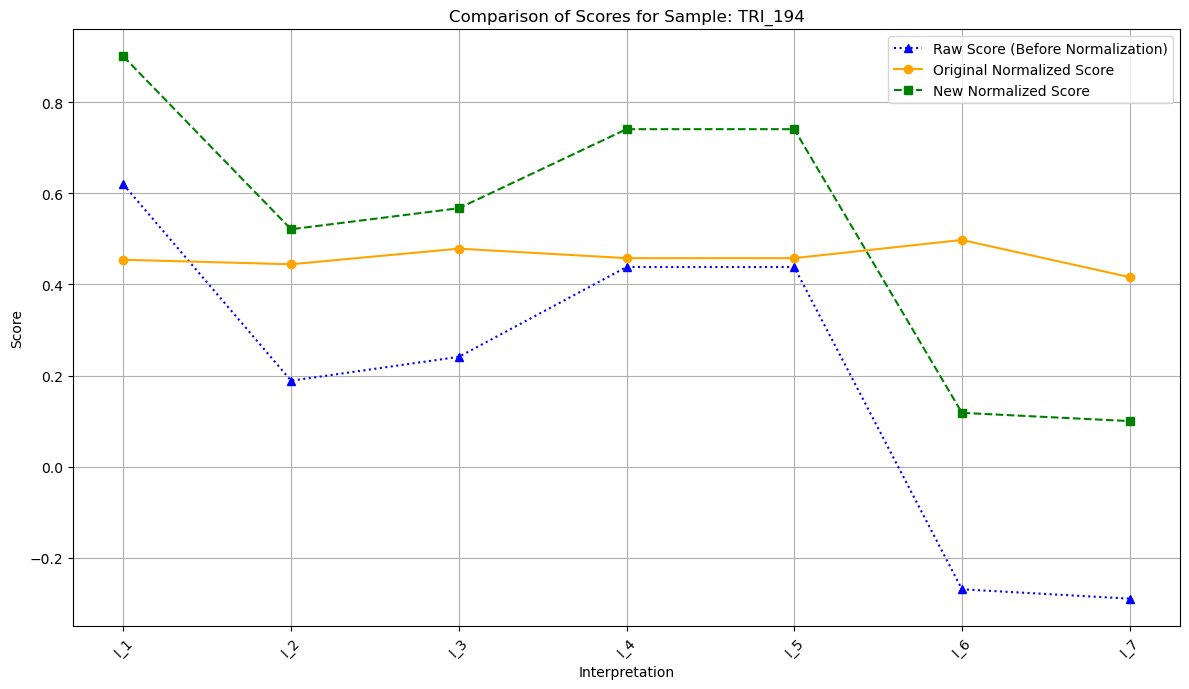

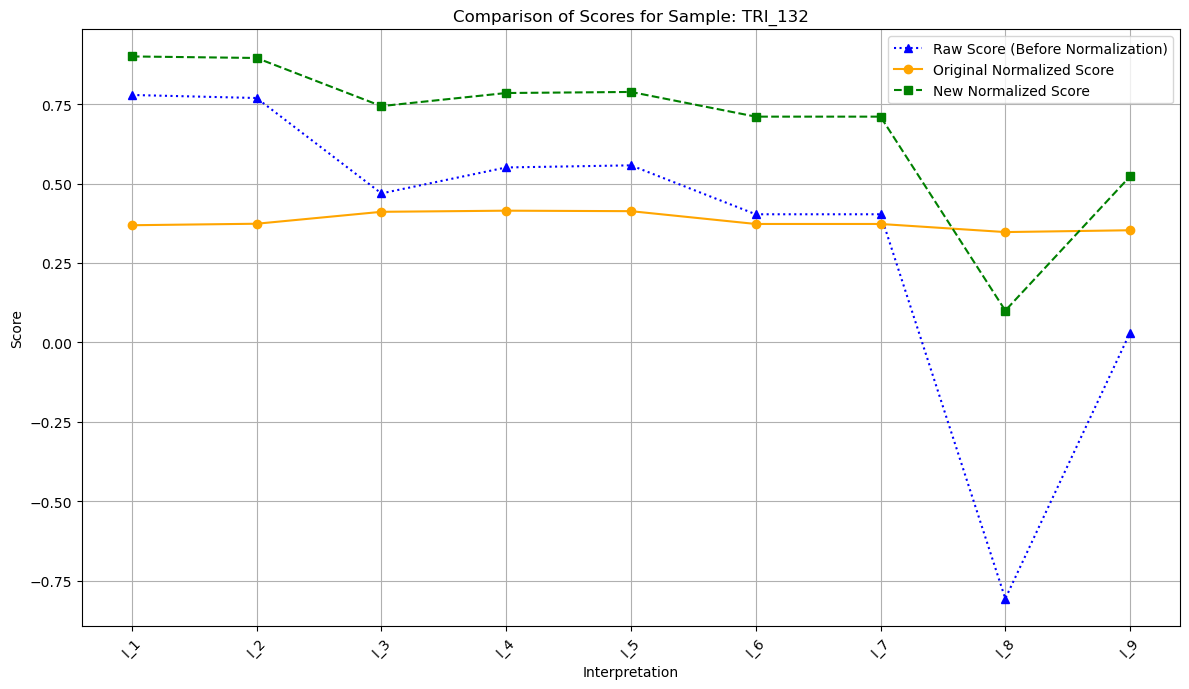

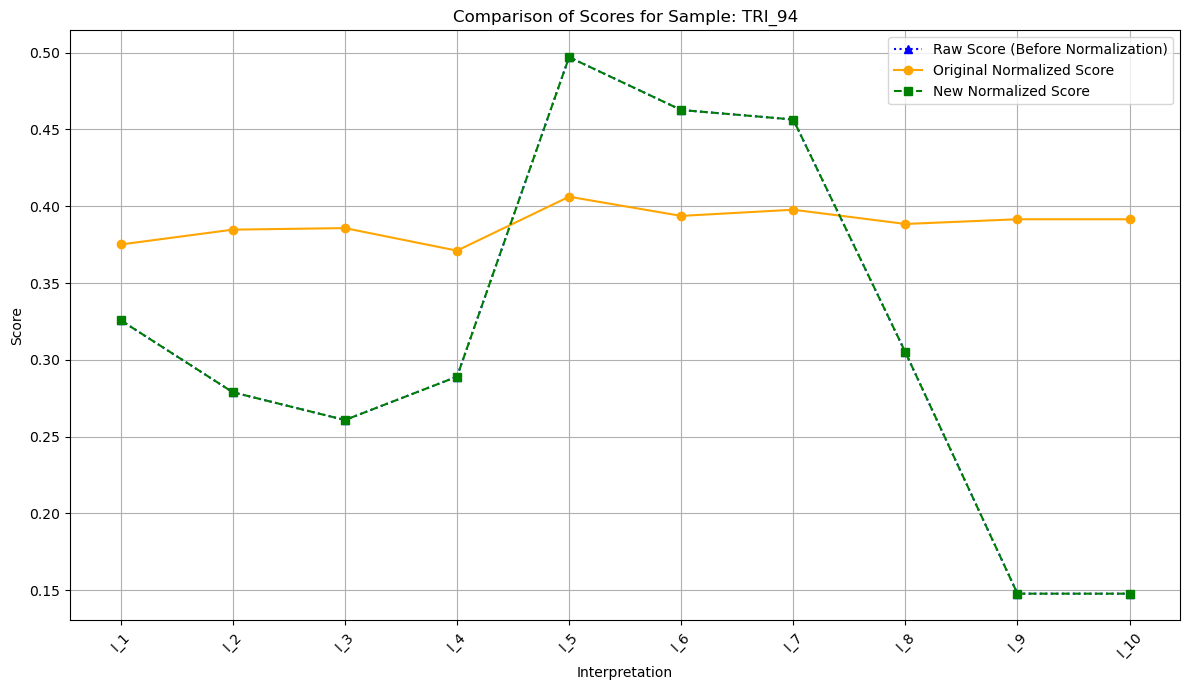

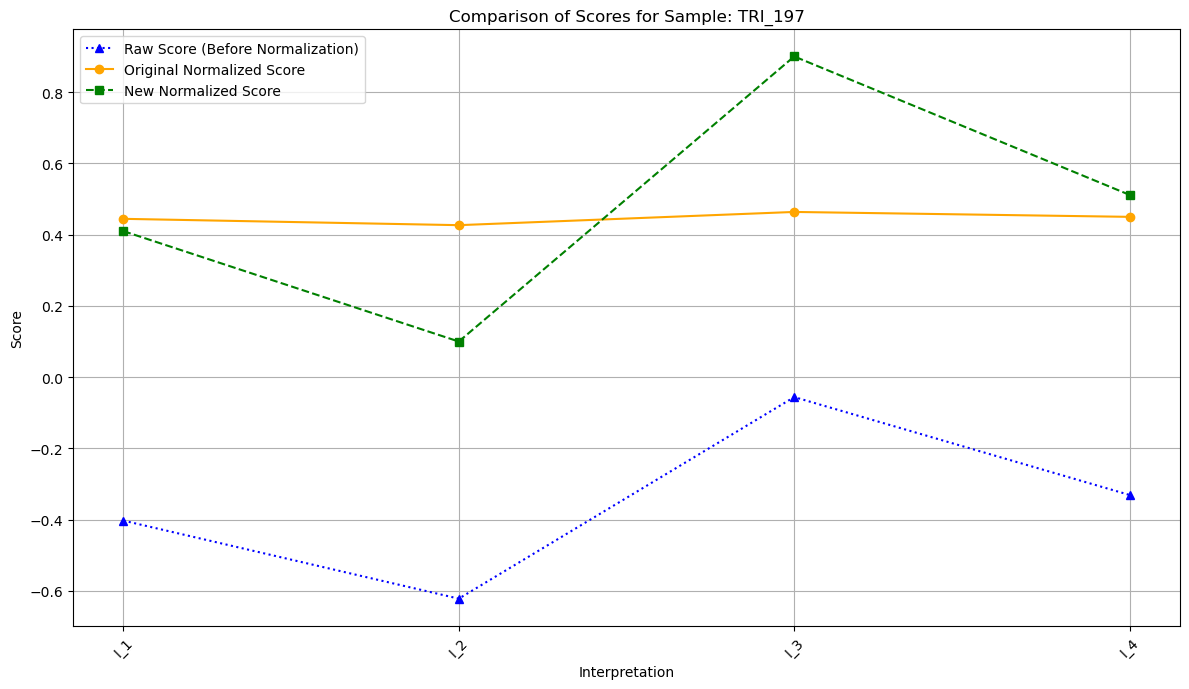

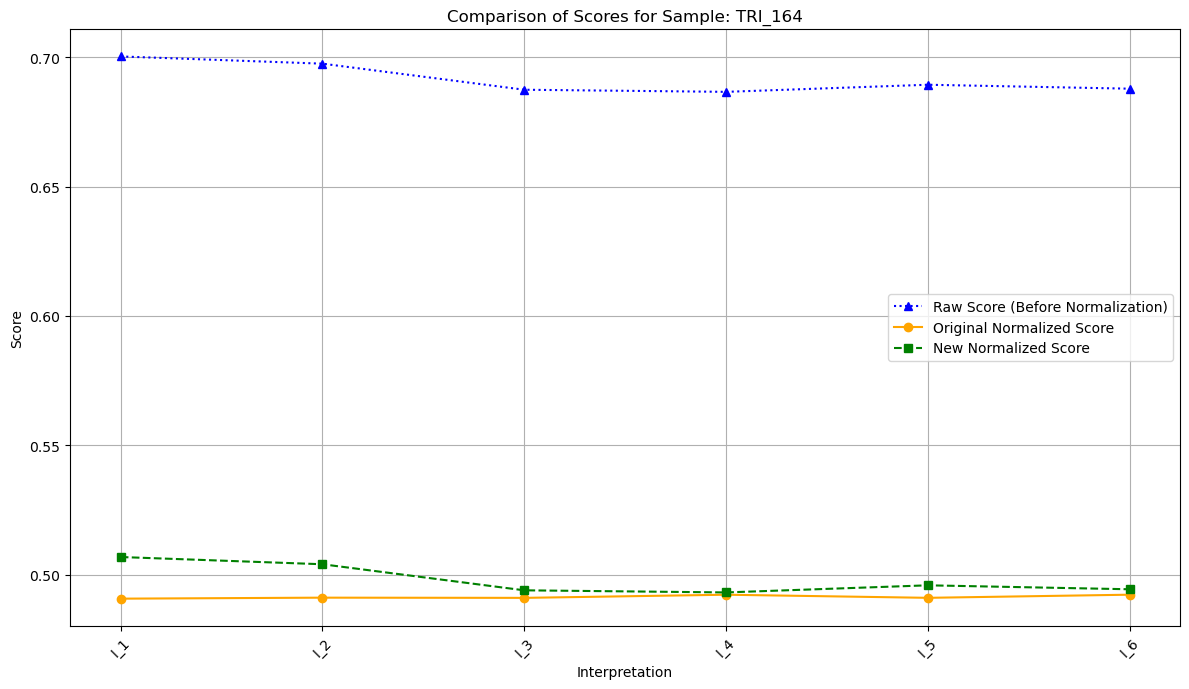

In [63]:
import json
import matplotlib.pyplot as plt

# Load your interpretations.json
with open('../src/interpretations.json', 'r') as f:
    interpretations_json = json.load(f)
def normalize_scores_for_sample(interpretations, 
                                 low_limit=0.1, high_limit=0.9, 
                                 spread_threshold=0.05):
    """
    Normalize 'score' fields for all interpretations smartly:
    - If all raw scores are between [0, 1], keep original scores
    - If spread is tiny, dynamically adjust narrow normalization limits
    - Otherwise, normalize into [low_limit, high_limit]
    
    Returns a new dictionary with 'new_normalized_score' added.
    """
    normalized_interpretations = {k: v.copy() for k, v in interpretations.items()}
    scores = [interp["score"] for interp in normalized_interpretations.values() if interp.get("score") is not None]

    if not scores:
        print("No valid scores found to normalize.")
        return normalized_interpretations

    min_score = min(scores)
    max_score = max(scores)
    spread = max_score - min_score

    # 1. If scores are already between 0 and 1 and spread reasonable, just copy original scores
    # if 0 <= min_score <= 1 and 0 <= max_score <= 1 :and spread >= spread_threshold:
        for interp in normalized_interpretations.values():
            raw_score = interp.get("score")
            interp["new_normalized_score"] = raw_score
        return normalized_interpretations

    # 2. If spread is very small, dynamically create a narrow normalization range around 0.5
    if spread < spread_threshold:
        center = 0.5
        half_range = spread / 2 if spread > 0 else 0.05  # Avoid zero range
        used_low_limit = center - half_range
        used_high_limit = center + half_range

        # Clip into [0, 1] to stay safe
        used_low_limit = max(0.0, used_low_limit)
        used_high_limit = min(1.0, used_high_limit)
    else:
        used_low_limit = low_limit
        used_high_limit = high_limit

    # 3. Normalization formula
    if min_score == max_score:
        midpoint = (used_low_limit + used_high_limit) / 2
        for interp in normalized_interpretations.values():
            interp["new_normalized_score"] = midpoint
        return normalized_interpretations

    for interp in normalized_interpretations.values():
        raw_score = interp.get("score")
        if raw_score is not None:
            normalized = used_low_limit + (raw_score - min_score) * (used_high_limit - used_low_limit) / (max_score - min_score)
            normalized = max(min(normalized, used_high_limit), used_low_limit)
            interp["new_normalized_score"] = normalized

    return normalized_interpretations


# Plotting function for a sample
def plot_sample_scores(sample_name, sample_interpretations):
    """
    Plot raw score, original normalized score, and new normalized score for one sample.
    """
    normalized_interpretations = normalize_scores_for_sample(sample_interpretations)

    labels = list(normalized_interpretations.keys())
    raw_scores = [sample_interpretations[i]["score"] for i in labels]
    original_norm_scores = [sample_interpretations[i]["normalized_score"] for i in labels]
    new_norm_scores = [normalized_interpretations[i]["new_normalized_score"] for i in labels]

    fig, ax = plt.subplots(figsize=(12, 7))
    x = range(len(labels))

    ax.plot(x, raw_scores, marker='^', label="Raw Score (Before Normalization)", linestyle=':', color='blue')
    ax.plot(x, original_norm_scores, marker='o', label="Original Normalized Score", color='orange')
    ax.plot(x, new_norm_scores, marker='s', label="New Normalized Score", linestyle='--', color='green')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Interpretation")
    ax.set_ylabel("Score")
    ax.set_title(f"Comparison of Scores for Sample: {sample_name}")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Main loop to plot for each sample
for sample_name, sample_interpretations in interpretations_json.items():
    plot_sample_scores(sample_name, sample_interpretations)